In [1]:
library(igraph)
library(utils)
library(tidyverse)
library(furrr)
library(purrr)
library(RPostgreSQL)
library(dbplyr)
library(FactoMineR)
library(factoextra)
library(corrplot)
require(scales)
library(caret)
library(gridExtra)
library(grid)
library(ggridges)
library(ggthemes)
theme_set(theme_minimal())
library(vcd)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::groups()        masks igraph::groups()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::simplify()      masks igraph::simplify()

Loading required package: future


Attaching package: ‘future’


The following objects are masked from ‘package:igraph’:

    %->%, %<-%


Loadin

In [2]:
subnetworks=c("II","V","X")

In [3]:
con = dbConnect(PostgreSQL(),dbname = 'yourdb', 
                 host = 'yourhost',
                 port = 0000)

In [4]:
r=tbl(con,in_schema("physcogrn", "reg_class"))
tf=as_tibble(r) %>% filter(reg_class=="TF") %>% select(geneid) %>% unlist(.,use.names=F)
length(tf)

[1] 979

In [5]:
a=read_delim("../GENIE3.top10_target_ranks.ranked_regulator_target_interactions.with_communities.correlations_and_directionality.tsv.gz",delim="\t")
nrow(a)
a=a[a$community %in% c(0,as.character(as.roman(1:11))),]
l=c("0",as.character(as.roman(1:11)))
a=transform(a,regulator_community=factor(a$regulator_community,levels=l),target_community=factor(a$target_community,levels=l))
nrow(a)
a=droplevels(a %>% filter(regulatoryGene %in% tf & target_community %in% subnetworks))

nrow(a)

head(a)
table(a$community)

Parsed with column specification:
cols(
  regulatoryGene = col_character(),
  targetGene = col_character(),
  full_cor = col_double(),
  full_reg = col_character(),
  our_cor = col_double(),
  our_reg = col_character(),
  weight = col_double(),
  regulator_rank = col_double(),
  target_rank = col_double(),
  mutual_rank = col_double(),
  regulator_community = col_character(),
  target_community = col_character(),
  community = col_character()
)



[1] 356457

[1] 356390

[1] 68637

regulatoryGene   targetGene                 full_cor   full_reg our_cor      
1 Pp3c4_31920.mRNA Pp3c13_21080.mRNA           0.1577695 +        -4.337281e-16
2 Pp3c4_350.mRNA   Pp3c3_28370.C_D_box_snoRNA  1.0000000 +         1.000000e+00
3 Pp3c12_10.mRNA   Pp3c1_12760.mRNA           -0.1279099 -         1.873743e-15
4 Pp3c1_21610.mRNA Pp3s178_40.mRNA             0.2570535 +         2.713689e-16
5 Pp3c1_32440.mRNA Pp3c7_19620.mRNA            0.7938397 +         6.887235e-01
6 Pp3c2_9700.mRNA  Pp3c5_14180.mRNA            0.1967969 +        -2.155251e-15
  our_reg weight     regulator_rank target_rank mutual_rank regulator_community
1 -       0.06337407 1              1           1           II                 
2 +       0.05976139 1              1           1           II                 
3 +       0.05927444 1              1           1           V                  
4 +       0.05903109 1              1           1           II                 
5 +       0.05734152 1              1           1           II                 
6 -       0.05491606 1              1           1           II                 
  target_community community
1 II               II       
2 II               II       
3 V                V        
4 II               II       
5 II               II       
6 II               II


    0    II     V     X 
26630 17231 10140 14636 

In [6]:
n=read_delim("../GENIE3.top10_target_ranks.communities_PLM.with_node_centralities.csv",delim=";")
n=n[n$community %in% c(0,as.character(as.roman(1:11))),]
n=transform(n,community=factor(n$community,levels=l[-1]))
n=droplevels(n %>% filter(geneid %in% union(a$regulatoryGene,a$targetGene)))
head(n)
table(n$community)

Parsed with column specification:
cols(
  geneid = col_character(),
  community = col_character(),
  degree_centrality = col_double(),
  betweenness_centrality = col_double(),
  eigenvector_centrality = col_double(),
  local_reaching_centrality = col_double(),
  centrality_rank = col_double()
)



geneid            community degree_centrality betweenness_centrality
1 Pp3c27_3080.mRNA  I         109                   0                 
2 Pp3c11_23290.mRNA I         552                3190                 
3 Pp3c7_2300.mRNA   I         505                7529                 
4 Pp3c17_23620.mRNA I         490                1988                 
5 Pp3c16_13280.mRNA I         485                9982                 
6 Pp3c8_6080.mRNA   I         451               32391                 
  eigenvector_centrality local_reaching_centrality centrality_rank
1 0.00000000             0.9977499                 1              
2 0.05359921             0.9971070                 2              
3 0.02518149             0.9971070                 3              
4 0.05419710             0.9971070                 4              
5 0.05634423             0.9971070                 5              
6 0.03267935             0.9971070                 7


   I   II  III   IV    V   VI  VII VIII   IX    X   XI 
 117 4418   76   78 3434   45   58   74  127 2403   65 

In [7]:
p=read_delim(gzfile("../DEK1_study.DEGs.minimal_info.tsv.gz"),delim="\t",col_types=cols())  %>% 
    select(1,8:9,12,30:31,34,52:53,56) %>%
    rowwise() %>%
    mutate( deregulation= sum(abs(deltaDEK_vs_OE.b_wt),abs(WT_vs_deltaDEK.b_wt),abs(WT_vs_OE.b_wt))) %>%
    mutate( effect_size= sum(abs(deltaDEK_vs_OE.test_stat_lrt),abs(WT_vs_deltaDEK.test_stat_lrt),abs(WT_vs_OE.test_stat_lrt))) %>%
    mutate( is_significant= (deltaDEK_vs_OE.qval_lrt<0.1 | WT_vs_OE.qval_lrt) & WT_vs_deltaDEK.qval_lrt<0.1) %>%
    ungroup() %>%
    select (geneid,deregulation,effect_size,is_significant) %>%
    filter(geneid %in% n$geneid)
p[!is.na(p$is_significant) & (is.na(p$effect_size) & is.na(p$deregulation)),"is_significant"]=FALSE
nrow(p)
head(p)

[1] 8003

geneid           deregulation effect_size is_significant
1 Pp3c1_10140.mRNA        NA           NA      NA         
2 Pp3c1_10449.mRNA        NA           NA      NA         
3 Pp3c1_10452.mRNA        NA           NA      NA         
4 Pp3c1_10460.mRNA 2.8918323    34.796214   FALSE         
5 Pp3c1_10620.mRNA 0.3923224     7.267784   FALSE         
6 Pp3c1_10680.mRNA        NA           NA      NA

In [8]:
e=read_delim("../calpain_cleavage_prediction.cosmoss_V3.3.release.pep.ccd.NERD_classification.tsv",delim="\t",col_types=cols()) %>%
    #mutate(NERD_target= fate=="NERD" &  U1>0.9 & uncertainty<0.05) %>%
    mutate(NERD_target= fate_strict=="NERD" ) %>%
    #mutate(NERD_ratio=ifelse(sites_raw>0,
    #                         (tertiary_deaminated_raw+tertiary_oxidized_or_acetylated_raw+secondary_ATE_raw+secondary_peptidase_raw)/(sites_raw),
    #                         0
    #                        )) %>%
    rename(geneid="target_id") %>%
    filter(geneid %in% n$geneid)
head(e)

geneid            id               sites_raw len  tertiary_deaminated_raw
1 Pp3c10_10090.mRNA Pp3c10_10090V3.1  13         56  2                     
2 Pp3c10_10130.mRNA Pp3c10_10130V3.1  19        499  0                     
3 Pp3c10_10200.mRNA Pp3c10_10200V3.3  13        169  0                     
4 Pp3c10_10240.mRNA Pp3c10_10240V3.2 113       1084 16                     
5 Pp3c10_10414.mRNA Pp3c10_10414V3.1   0        134  0                     
6 Pp3c10_10460.mRNA Pp3c10_10460V3.1   9        498  0                     
  tertiary_oxidized_or_acetylated_raw secondary_ATE_raw secondary_peptidase_raw
1 0                                   1                  6                     
2 0                                   0                  3                     
3 0                                   0                  2                     
4 0                                   3                 24                     
5 0                                   0                  0                     
6 0                                   1                  1                     
  primary_acetylated_raw ratio      ⋯ secondary_peptidase_rel
1  4                     0.23214286 ⋯ 0.107142857            
2 16                     0.03807615 ⋯ 0.006012024            
3 10                     0.07692308 ⋯ 0.011834320            
4 58                     0.10424354 ⋯ 0.022140221            
5  0                     0.00000000 ⋯ 0.000000000            
6  7                     0.01807229 ⋯ 0.002008032            
  primary_acetylated_rel clust uncertainty  U1           U2          
1 0.07142857             2     6.172489e-05 6.172489e-05 9.999383e-01
2 0.03206413             3     2.393614e-02 2.393520e-02 9.345508e-07
3 0.05917160             1     7.920775e-03 9.920792e-01 2.690608e-05
4 0.05350554             1     6.805299e-04 9.993195e-01 2.611830e-05
5 0.00000000             3     2.180410e-03 2.180255e-03 1.542735e-07
6 0.01405622             3     5.073684e-03 5.073489e-03 1.945686e-07
  U3           fate      fate_strict NERD_target
1 5.138348e-87 NERD      NERD         TRUE      
2 9.760639e-01 other     other       FALSE      
3 7.893869e-03 NERD      NERD         TRUE      
4 6.544116e-04 NERD      NERD         TRUE      
5 9.978196e-01 unchanged unchanged   FALSE      
6 9.949263e-01 other     other       FALSE

In [9]:
names(e)

[1] "geneid"                              "id"                                 
 [3] "sites_raw"                           "len"                                
 [5] "tertiary_deaminated_raw"             "tertiary_oxidized_or_acetylated_raw"
 [7] "secondary_ATE_raw"                   "secondary_peptidase_raw"            
 [9] "primary_acetylated_raw"              "ratio"                              
[11] "lratio"                              "SLC"                                
[13] "sites_rel"                           "tertiary_deaminated_rel"            
[15] "tertiary_oxidized_or_acetylated_rel" "secondary_ATE_rel"                  
[17] "secondary_peptidase_rel"             "primary_acetylated_rel"             
[19] "clust"                               "uncertainty"                        
[21] "U1"                                  "U2"                                 
[23] "U3"                                  "fate"                               
[25] "fate_strict"                         "NERD_target"

In [10]:
P=left_join(n,e %>% select(geneid,NERD_target,
                           SLC,sites_rel,
                           tertiary_deaminated_rel,tertiary_oxidized_or_acetylated_rel,
                           secondary_ATE_rel,secondary_peptidase_rel,primary_acetylated_rel
                          ),by="geneid") %>% 
    mutate(NERD_target=ifelse(is.na(NERD_target),FALSE,NERD_target))
nrow(P)
P=right_join(p,P,by="geneid") 
table(P$effect_size>0)
table(P$deregulation>0)
P=P %>% 
    replace_na(list(
        deregulation=0,
        effect_size=0,
        is_significant=FALSE,
        NERD_target=FALSE
    ))
table(P$effect_size>0)
table(P$deregulation>0)
table(P$NERD_target)

nrow(p)
nrow(n)
nrow(P)
head(P)

[1] 10895


TRUE 
6830 


TRUE 
6830 


FALSE  TRUE 
 4065  6830 


FALSE  TRUE 
 4065  6830 


FALSE  TRUE 
 7271  3624 

[1] 8003

[1] 10895

[1] 10895

geneid           deregulation effect_size is_significant community
1 Pp3c1_10140.mRNA 0.0000000     0.000000   FALSE          V        
2 Pp3c1_10449.mRNA 0.0000000     0.000000   FALSE          II       
3 Pp3c1_10452.mRNA 0.0000000     0.000000   FALSE          II       
4 Pp3c1_10460.mRNA 2.8918323    34.796214   FALSE          X        
5 Pp3c1_10620.mRNA 0.3923224     7.267784   FALSE          V        
6 Pp3c1_10680.mRNA 0.0000000     0.000000   FALSE          X        
  degree_centrality betweenness_centrality eigenvector_centrality
1 0                 0                      0.002088643           
2 0                 0                      0.004726781           
3 0                 0                      0.005055768           
4 0                 0                      0.018057803           
5 0                 0                      0.009271654           
6 0                 0                      0.006481991           
  local_reaching_centrality centrality_rank NERD_target SLC sites_rel 
1 0                         3077             TRUE       S4  0.12977099
2 0                          758             TRUE       S2  0.03030303
3 0                          740             TRUE       S3  0.07777778
4 0                          820            FALSE       S2  0.03154574
5 0                         1473            FALSE       S3  0.05111111
6 0                         1641             TRUE       S3  0.06428972
  tertiary_deaminated_rel tertiary_oxidized_or_acetylated_rel secondary_ATE_rel
1 0.000000000             0.0000000000                        0.000000000      
2 0.000000000             0.0000000000                        0.000000000      
3 0.000000000             0.0111111111                        0.000000000      
4 0.000000000             0.0000000000                        0.000000000      
5 0.002222222             0.0000000000                        0.002222222      
6 0.007580011             0.0002807412                        0.005334082      
  secondary_peptidase_rel primary_acetylated_rel
1 0.015267176             0.09160305            
2 0.030303030             0.00000000            
3 0.011111111             0.04444444            
4 0.006309148             0.02208202            
5 0.013333333             0.03222222            
6 0.016563728             0.03284672

In [11]:
nrow(P)
P=P %>% filter(is_significant | NERD_target | community %in% subnetworks) 
nrow(P)
nrow(a)
a=a %>% filter(regulatoryGene %in% P$geneid & target_community %in% subnetworks )
nrow(a)

[1] 10895

[1] 10740

[1] 68637

[1] 64408

In [12]:
G=graph_from_data_frame(a,directed = TRUE,vertices = P)
is_weighted(G)
list.edge.attributes(G)
list.vertex.attributes(G)

[1] TRUE

[1] "full_cor"            "full_reg"            "our_cor"            
 [4] "our_reg"             "weight"              "regulator_rank"     
 [7] "target_rank"         "mutual_rank"         "regulator_community"
[10] "target_community"    "community"

[1] "name"                                "deregulation"                       
 [3] "effect_size"                         "is_significant"                     
 [5] "community"                           "degree_centrality"                  
 [7] "betweenness_centrality"              "eigenvector_centrality"             
 [9] "local_reaching_centrality"           "centrality_rank"                    
[11] "NERD_target"                         "SLC"                                
[13] "sites_rel"                           "tertiary_deaminated_rel"            
[15] "tertiary_oxidized_or_acetylated_rel" "secondary_ATE_rel"                  
[17] "secondary_peptidase_rel"             "primary_acetylated_rel"

In [13]:
col=read.csv("../subnetwork_colours.csv",stringsAsFactors=FALSE)
col$network=ordered(col$network,levels=as.character(as.roman(1:11)))
col=col[order(col$network),]
col
col2=col$colour
names(col2)=col$network
col2

network colour 
1  I       #999999
2  II      #FFE529
3  III     #5A6A99
4  IV      #FF7F00
5  V       #E486B7
6  VI      #6B886E
7  VII     #E41A1C
8  VIII    #CA9A2C
9  IX      #AD5882
10 X       #C66764
11 XI      #449B76

I        II       III        IV         V        VI       VII      VIII 
"#999999" "#FFE529" "#5A6A99" "#FF7F00" "#E486B7" "#6B886E" "#E41A1C" "#CA9A2C" 
       IX         X        XI 
"#AD5882" "#C66764" "#449B76"

In [14]:
analyzeNeighbors=function(id,max_order) {
    EG=make_ego_graph(G,nodes=id,order=max_order,mode="in")[[1]] 
    EGI=delete_vertices(EG,!(V(EG)$is_significant |V(EG)$NERD_target) & !V(EG)$name==id)
    EGE=delete_vertices(EG,!(V(EG)$is_significant) & !V(EG)$name==id)
    EGN=delete_vertices(EG,! (V(EG)$NERD_target) & !V(EG)$name==id)
    seq_len(max_order) %>% 
        map( function(i) {
            EEG=make_ego_graph(EG,nodes=id,order=i,mode="in")[[1]]
            EEG=delete_vertices(EEG,V(EEG)$name==id)
            tibble(
                geneid=id,
                order=i,
                u_deregulation=median(V(EEG)$deregulation,na.rm=TRUE),
                u_effect_size=median(V(EEG)$effect_size,na.rm=TRUE),
                all_targets=ego_size(EGI,nodes=id,mode="in",order=i)-1,
                dereg_targets=ego_size(EGE,nodes=id,mode="in",order=i)-1,
                direct_targets=ego_size(EGN,nodes=id,mode="in",order=i)-1,
                upstream=ego_size(EG,nodes=id,mode="in",order=i)-1)
            }) %>%
        bind_rows() %>%
        replace_na(list(u_deregulation=0,u_effect_size=0)) %>%
        mutate(
            p_all_targets=ifelse(upstream>0,all_targets/upstream,0),
            p_dereg_targets=ifelse(upstream>0,dereg_targets/upstream,0),
            p_direct_targets=ifelse(upstream>0,direct_targets/upstream,0))
}
    

In [15]:
analyzeNeighbors=function(id,max_order) {
    EG=make_ego_graph(G,nodes=id,order=max_order,mode="in")[[1]] 
    EGI=delete_vertices(EG,!(V(EG)$is_significant |V(EG)$NERD_target) & !V(EG)$name==id)
    EGE=delete_vertices(EG,!(V(EG)$is_significant) & !V(EG)$name==id)
    EGN=delete_vertices(EG,! (V(EG)$NERD_target) & !V(EG)$name==id)
    seq_len(max_order) %>% 
        map( function(i) {
            EEG=make_ego_graph(EG,nodes=id,order=i,mode="in")[[1]]
            EEG=delete_vertices(EEG,V(EEG)$name==id)
            tibble(
                geneid=id,
                order=i,
                u_deregulation=median(V(EEG)$deregulation,na.rm=TRUE),
                u_effect_size=median(V(EEG)$effect_size,na.rm=TRUE),
                u_local_reaching_centrality=median(V(EEG)$local_reaching_centrality,na.rm=TRUE),
                u_sites_rel=median(V(EEG)$sites_rel,na.rm=TRUE),
                u_tertiary_deaminated_rel=median(V(EEG)$tertiary_deaminated_rel,na.rm=TRUE),
                u_tertiary_oxidized_or_acetylated_rel=median(V(EEG)$tertiary_oxidized_or_acetylated_rel,na.rm=TRUE),
                u_secondary_ATE_rel=median(V(EEG)$secondary_ATE_rel,na.rm=TRUE),
                u_secondary_peptidase_rel=median(V(EEG)$secondary_peptidase_rel,na.rm=TRUE),
                u_primary_acetylated_rel=median(V(EEG)$primary_acetylated_rel,na.rm=TRUE),
                all_targets=ego_size(EGI,nodes=id,mode="in",order=i)-1,
                dereg_targets=ego_size(EGE,nodes=id,mode="in",order=i)-1,
                direct_targets=ego_size(EGN,nodes=id,mode="in",order=i)-1,
                upstream=ego_size(EG,nodes=id,mode="in",order=i)-1)
            }) %>%
        bind_rows() %>%
        replace_na(list(u_deregulation=0,u_effect_size=0,
                        u_local_reaching_centrality=0,u_sites_rel=0,u_tertiary_deaminated_rel=0,
                        u_tertiary_oxidized_or_acetylated_rel=0, u_secondary_ATE_rel=0,
                        u_secondary_peptidase_rel=0,u_primary_acetylated_rel=0
                       )) %>%
        mutate(
            p_all_targets=ifelse(upstream>0,all_targets/upstream,0),
            p_dereg_targets=ifelse(upstream>0,dereg_targets/upstream,0),
            p_direct_targets=ifelse(upstream>0,direct_targets/upstream,0))
}
    

In [16]:
plan(multisession, workers = 30)


In [17]:
PP= P %>% 
    select(geneid) %>% unlist(.,use.names=FALSE) %>%
    future_map(function(x) analyzeNeighbors(x,3)) %>%
    bind_rows()

In [18]:
head(PP)

geneid           order u_deregulation u_effect_size
1 Pp3c1_10140.mRNA 1     1.1147099      34.10827     
2 Pp3c1_10140.mRNA 2     0.7643324      34.10827     
3 Pp3c1_10140.mRNA 3     0.5811811      30.18948     
4 Pp3c1_10449.mRNA 1     0.3996551      16.93980     
5 Pp3c1_10449.mRNA 2     0.5693604      14.24304     
6 Pp3c1_10449.mRNA 3     0.6705439      18.92206     
  u_local_reaching_centrality u_sites_rel u_tertiary_deaminated_rel
1 0.9988352                   0.06872852  0.010309278              
2 0.9988352                   0.07425743  0.009259259              
3 0.9988352                   0.06872852  0.008385744              
4 0.9893593                   0.09183673  0.005681818              
5 0.9893593                   0.08191222  0.005550936              
6 0.9893593                   0.08203156  0.005722753              
  u_tertiary_oxidized_or_acetylated_rel u_secondary_ATE_rel
1 0                                     0.001808318        
2 0                                     0.002057613        
3 0                                     0.002057613        
4 0                                     0.006122449        
5 0                                     0.002029600        
6 0                                     0.002464086        
  u_secondary_peptidase_rel u_primary_acetylated_rel all_targets dereg_targets
1 0.01681957                0.04123711                3           2           
2 0.01980198                0.04455446                8           5           
3 0.01100917                0.04220183               14           9           
4 0.01017812                0.05113636                6           4           
5 0.01717982                0.04500127               29          15           
6 0.01536098                0.04744731               93          35           
  direct_targets upstream p_all_targets p_dereg_targets p_direct_targets
1  2               3      1.0000000     0.6666667       0.6666667       
2  6               9      0.8888889     0.5555556       0.6666667       
3 12              17      0.8235294     0.5294118       0.7058824       
4  5               7      0.8571429     0.5714286       0.7142857       
5 21              38      0.7631579     0.3947368       0.5526316       
6 59             134      0.6940299     0.2611940       0.4402985

In [19]:
PPP=droplevels(inner_join(PP,P, on="geneid"))
head(PPP)

Joining, by = "geneid"



geneid           order u_deregulation u_effect_size
1 Pp3c1_10140.mRNA 1     1.1147099      34.10827     
2 Pp3c1_10140.mRNA 2     0.7643324      34.10827     
3 Pp3c1_10140.mRNA 3     0.5811811      30.18948     
4 Pp3c1_10449.mRNA 1     0.3996551      16.93980     
5 Pp3c1_10449.mRNA 2     0.5693604      14.24304     
6 Pp3c1_10449.mRNA 3     0.6705439      18.92206     
  u_local_reaching_centrality u_sites_rel u_tertiary_deaminated_rel
1 0.9988352                   0.06872852  0.010309278              
2 0.9988352                   0.07425743  0.009259259              
3 0.9988352                   0.06872852  0.008385744              
4 0.9893593                   0.09183673  0.005681818              
5 0.9893593                   0.08191222  0.005550936              
6 0.9893593                   0.08203156  0.005722753              
  u_tertiary_oxidized_or_acetylated_rel u_secondary_ATE_rel
1 0                                     0.001808318        
2 0                                     0.002057613        
3 0                                     0.002057613        
4 0                                     0.006122449        
5 0                                     0.002029600        
6 0                                     0.002464086        
  u_secondary_peptidase_rel ⋯ local_reaching_centrality centrality_rank
1 0.01681957                ⋯ 0                         3077           
2 0.01980198                ⋯ 0                         3077           
3 0.01100917                ⋯ 0                         3077           
4 0.01017812                ⋯ 0                          758           
5 0.01717982                ⋯ 0                          758           
6 0.01536098                ⋯ 0                          758           
  NERD_target SLC sites_rel  tertiary_deaminated_rel
1 TRUE        S4  0.12977099 0                      
2 TRUE        S4  0.12977099 0                      
3 TRUE        S4  0.12977099 0                      
4 TRUE        S2  0.03030303 0                      
5 TRUE        S2  0.03030303 0                      
6 TRUE        S2  0.03030303 0                      
  tertiary_oxidized_or_acetylated_rel secondary_ATE_rel secondary_peptidase_rel
1 0                                   0                 0.01526718             
2 0                                   0                 0.01526718             
3 0                                   0                 0.01526718             
4 0                                   0                 0.03030303             
5 0                                   0                 0.03030303             
6 0                                   0                 0.03030303             
  primary_acetylated_rel
1 0.09160305            
2 0.09160305            
3 0.09160305            
4 0.00000000            
5 0.00000000            
6 0.00000000

In [20]:
fit=step(glm(is_significant~p_all_targets+p_dereg_targets+p_direct_targets+order,data =PPP))
summary(fit)

Start:  AIC=44768.19
is_significant ~ p_all_targets + p_dereg_targets + p_direct_targets + 
    order

                   Df Deviance   AIC
<none>                  7567.0 44768
- p_direct_targets  1   7573.4 44794
- order             1   7580.7 44824
- p_all_targets     1   7589.1 44860
- p_dereg_targets   1   7639.2 45072



Call:
glm(formula = is_significant ~ p_all_targets + p_dereg_targets + 
    p_direct_targets + order, data = PPP)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.6115  -0.3898  -0.3425   0.5922   0.7922  

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)       0.321893   0.013058  24.651  < 2e-16 ***
p_all_targets    -0.227694   0.023457  -9.707  < 2e-16 ***
p_dereg_targets   0.322846   0.018408  17.538  < 2e-16 ***
p_direct_targets  0.104125   0.019855   5.244 1.58e-07 ***
order             0.030099   0.003942   7.636 2.30e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2348893)

    Null deviance: 7641.3  on 32219  degrees of freedom
Residual deviance: 7567.0  on 32215  degrees of freedom
AIC: 44768

Number of Fisher Scoring iterations: 2


In [21]:
fit=step(glm(effect_size~p_all_targets+p_dereg_targets+p_direct_targets+order,data =PPP))
summary(fit)

Start:  AIC=315320.3
effect_size ~ p_all_targets + p_dereg_targets + p_direct_targets + 
    order

                   Df Deviance    AIC
<none>                33550828 315320
- p_all_targets     1 33556201 315324
- p_direct_targets  1 33571525 315338
- order             1 33598730 315364
- p_dereg_targets   1 33646714 315410



Call:
glm(formula = effect_size ~ p_all_targets + p_dereg_targets + 
    p_direct_targets + order, data = PPP)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-33.46  -20.97  -10.45    6.73  366.06  

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       14.0136     0.8695  16.117  < 2e-16 ***
p_all_targets     -3.5478     1.5620  -2.271   0.0231 *  
p_dereg_targets   11.7613     1.2257   9.595  < 2e-16 ***
p_direct_targets   5.8937     1.3221   4.458 8.30e-06 ***
order              1.7800     0.2625   6.782 1.21e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 1041.466)

    Null deviance: 33736592  on 32219  degrees of freedom
Residual deviance: 33550828  on 32215  degrees of freedom
AIC: 315320

Number of Fisher Scoring iterations: 2


In [22]:
cbind(seq_len(ncol(PPP)),names(PPP))

[,1] [,2]                                 
 [1,] 1    geneid                               
 [2,] 2    order                                
 [3,] 3    u_deregulation                       
 [4,] 4    u_effect_size                        
 [5,] 5    u_local_reaching_centrality          
 [6,] 6    u_sites_rel                          
 [7,] 7    u_tertiary_deaminated_rel            
 [8,] 8    u_tertiary_oxidized_or_acetylated_rel
 [9,] 9    u_secondary_ATE_rel                  
[10,] 10   u_secondary_peptidase_rel            
[11,] 11   u_primary_acetylated_rel             
[12,] 12   all_targets                          
[13,] 13   dereg_targets                        
[14,] 14   direct_targets                       
[15,] 15   upstream                             
[16,] 16   p_all_targets                        
[17,] 17   p_dereg_targets                      
[18,] 18   p_direct_targets                     
[19,] 19   deregulation                         
[20,] 20   effect_size                          
[21,] 21   is_significant                       
[22,] 22   community                            
[23,] 23   degree_centrality                    
[24,] 24   betweenness_centrality               
[25,] 25   eigenvector_centrality               
[26,] 26   local_reaching_centrality            
[27,] 27   centrality_rank                      
[28,] 28   NERD_target                          
[29,] 29   SLC                                  
[30,] 30   sites_rel                            
[31,] 31   tertiary_deaminated_rel              
[32,] 32   tertiary_oxidized_or_acetylated_rel  
[33,] 33   secondary_ATE_rel                    
[34,] 34   secondary_peptidase_rel              
[35,] 35   primary_acetylated_rel

In [23]:
names(PPP)[-c(1,12:15,19:20,22:35)]

[1] "order"                                
 [2] "u_deregulation"                       
 [3] "u_effect_size"                        
 [4] "u_local_reaching_centrality"          
 [5] "u_sites_rel"                          
 [6] "u_tertiary_deaminated_rel"            
 [7] "u_tertiary_oxidized_or_acetylated_rel"
 [8] "u_secondary_ATE_rel"                  
 [9] "u_secondary_peptidase_rel"            
[10] "u_primary_acetylated_rel"             
[11] "p_all_targets"                        
[12] "p_dereg_targets"                      
[13] "p_direct_targets"                     
[14] "is_significant"

In [24]:
fit_control = trainControl(method = "repeatedcv",
                           number = 5,
                           repeats = 3)
PPPP=PPP %>% select(-c(1,12:15,19:20,22:35))
rf_fit = train(factor(is_significant,levels=c("TRUE","FALSE")) ~ . , 
                 data = PPPP, #importance = 'impurity',
                  method = "rf", 
                  #preProcess = c("scale", "center"),
                  trControl = fit_control,
                  verbose = FALSE)

In [25]:
varImp(rf_fit,scale = TRUE)

rf variable importance

                                      Overall
u_secondary_peptidase_rel              100.00
u_tertiary_deaminated_rel               98.31
u_secondary_ATE_rel                     97.14
u_effect_size                           97.02
p_dereg_targets                         96.93
u_primary_acetylated_rel                95.58
u_deregulation                          95.48
u_sites_rel                             94.46
p_direct_targets                        93.26
p_all_targets                           86.96
u_local_reaching_centrality             50.96
order                                   13.32
u_tertiary_oxidized_or_acetylated_rel    0.00

In [26]:
pred=predict(rf_fit, PPPP)
confusionMatrix(pred, factor(PPPP$is_significant,levels=c("TRUE","FALSE")))

Confusion Matrix and Statistics

          Reference
Prediction  TRUE FALSE
     TRUE  11935   978
     FALSE   524 18783
                                         
               Accuracy : 0.9534         
                 95% CI : (0.951, 0.9557)
    No Information Rate : 0.6133         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.9024         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.9579         
            Specificity : 0.9505         
         Pos Pred Value : 0.9243         
         Neg Pred Value : 0.9729         
             Prevalence : 0.3867         
         Detection Rate : 0.3704         
   Detection Prevalence : 0.4008         
      Balanced Accuracy : 0.9542         
                                         
       'Positive' Class : TRUE           
                                      

In [27]:
options(repr.plot.width=15, repr.plot.height=8)

In [28]:
rf_model_imp = varImp(rf_fit, scale = TRUE)
p1 = rf_model_imp$importance %>%
  as.data.frame() %>%
  rownames_to_column() %>%
  ggplot(aes(x = reorder(rowname, Overall), y = Overall)) +
    geom_bar(stat = "identity", fill = "#1F77B4", alpha = 0.8) +
    coord_flip()

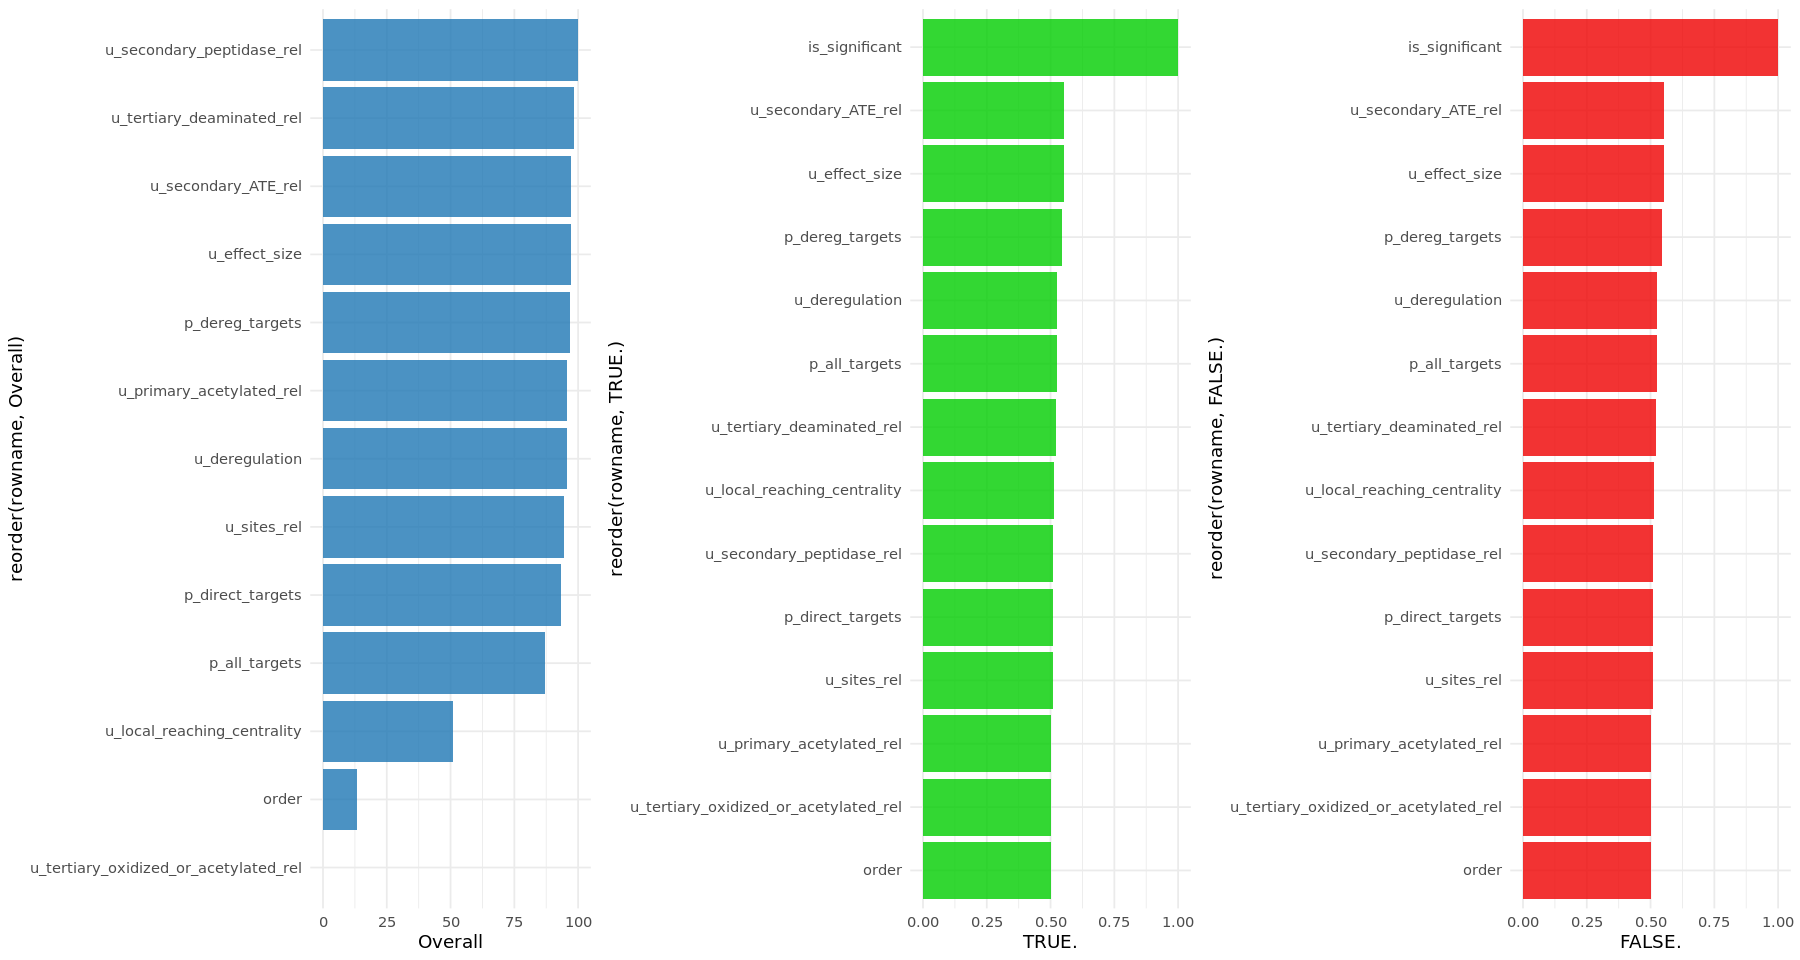

In [29]:
roc_imp = filterVarImp(x =PPPP,
                       y = factor(PPPP$is_significant,levels=c("TRUE","FALSE")))
p2 = roc_imp %>%
  as.data.frame() %>%
  rownames_to_column() %>%
  ggplot(aes(x = reorder(rowname,TRUE.), y = TRUE.)) +
    geom_bar(stat = "identity", fill = "green3", alpha = 0.8) +
    coord_flip()
p3 = roc_imp %>%
  as.data.frame() %>%
  rownames_to_column() %>%
  ggplot(aes(x = reorder(rowname,FALSE.), y = FALSE.)) +
    geom_bar(stat = "identity", fill = "red2", alpha = 0.8) +
    coord_flip()
grid.arrange(p1, p2,p3, ncol = 3)

In [30]:
options(repr.plot.width=12, repr.plot.height=7)

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



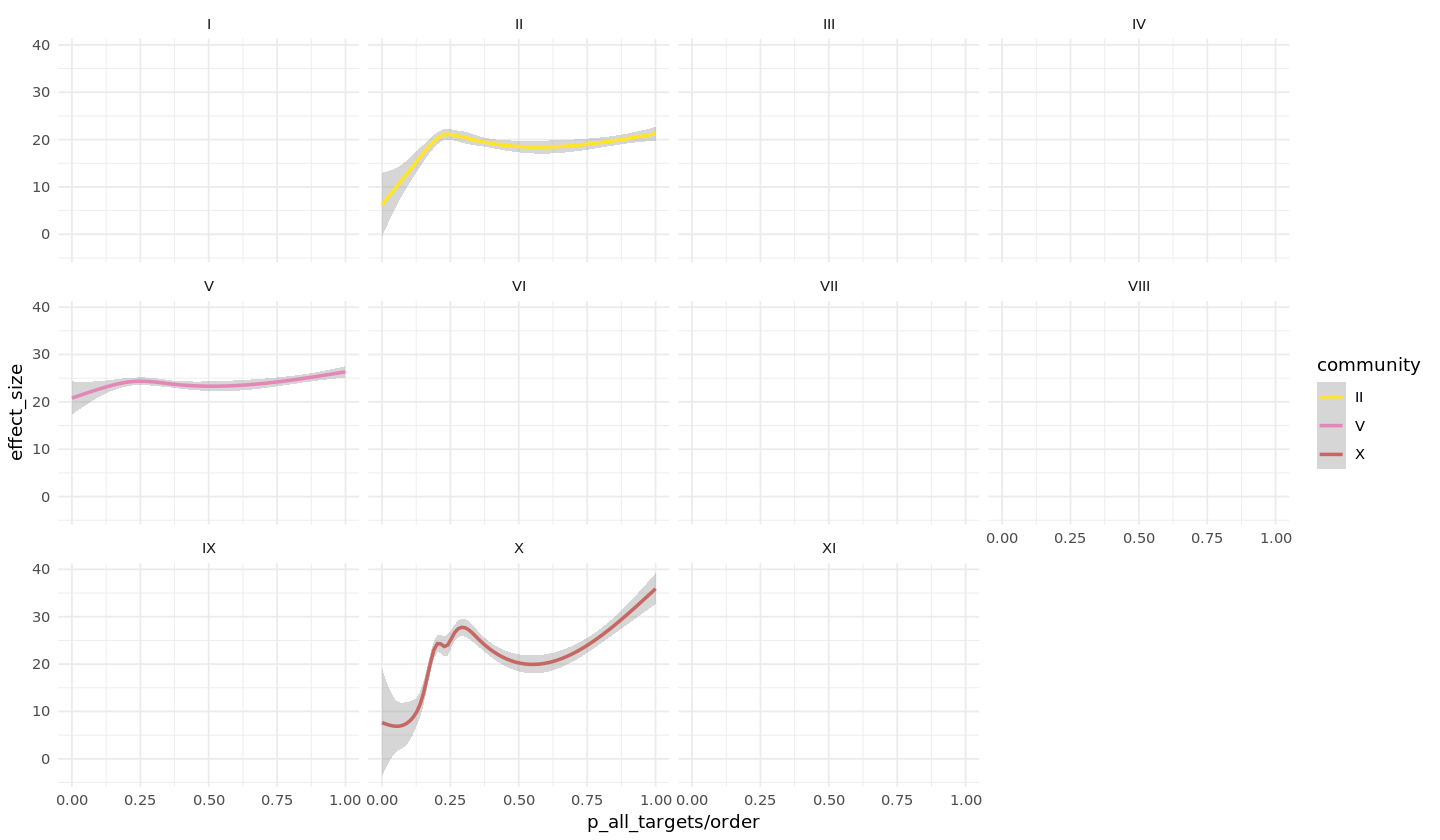

In [31]:
ggplot(PPP, aes(x=p_all_targets/order,y=effect_size,colour=community)) + facet_wrap(~community) +
geom_smooth(method="gam") +scale_colour_manual(values=col2) 

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



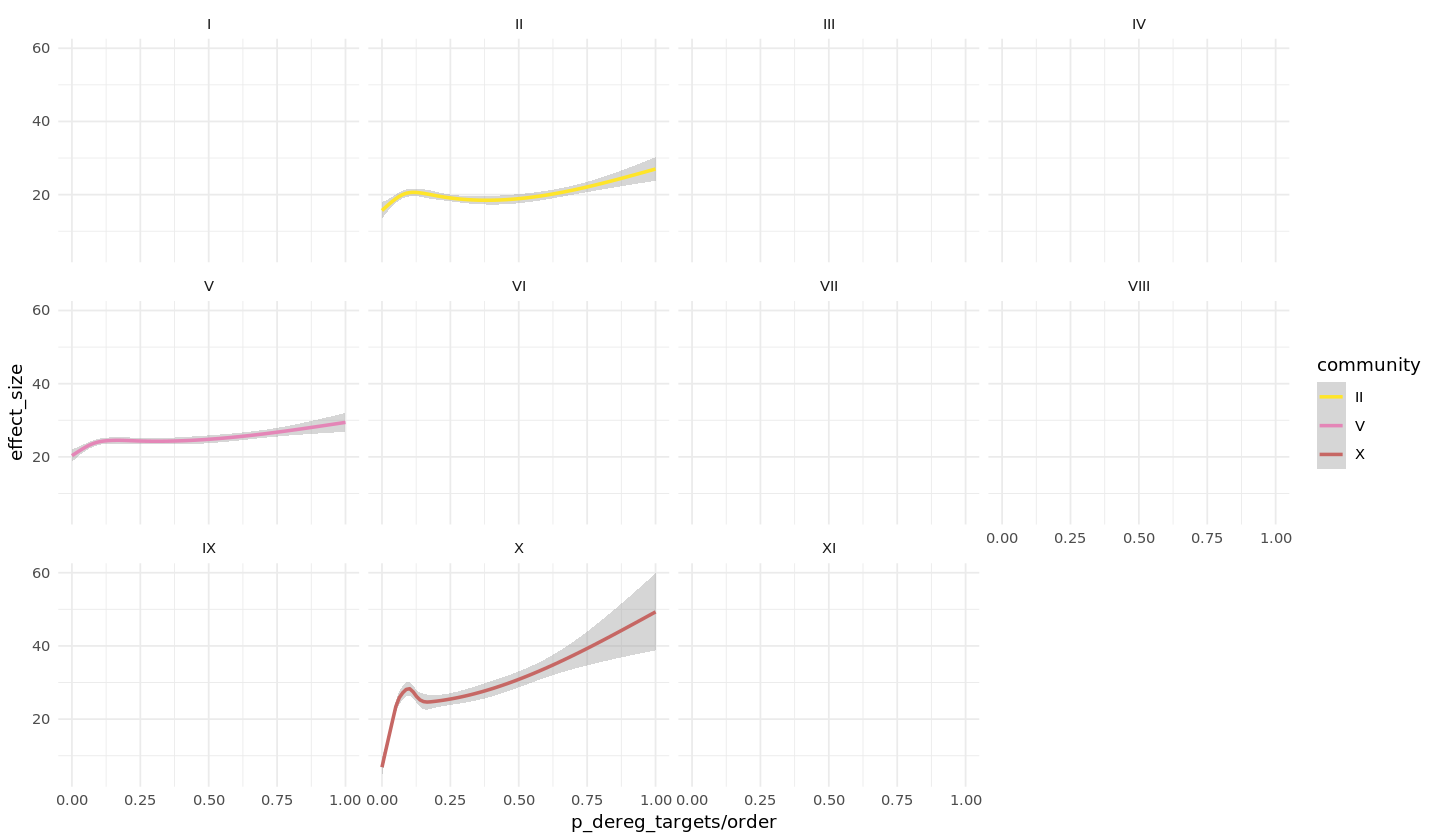

In [32]:
ggplot(PPP, aes(x=p_dereg_targets/order,y=effect_size,colour=community)) + facet_wrap(~community) +
geom_smooth(method="gam") +scale_colour_manual(values=col2) 

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



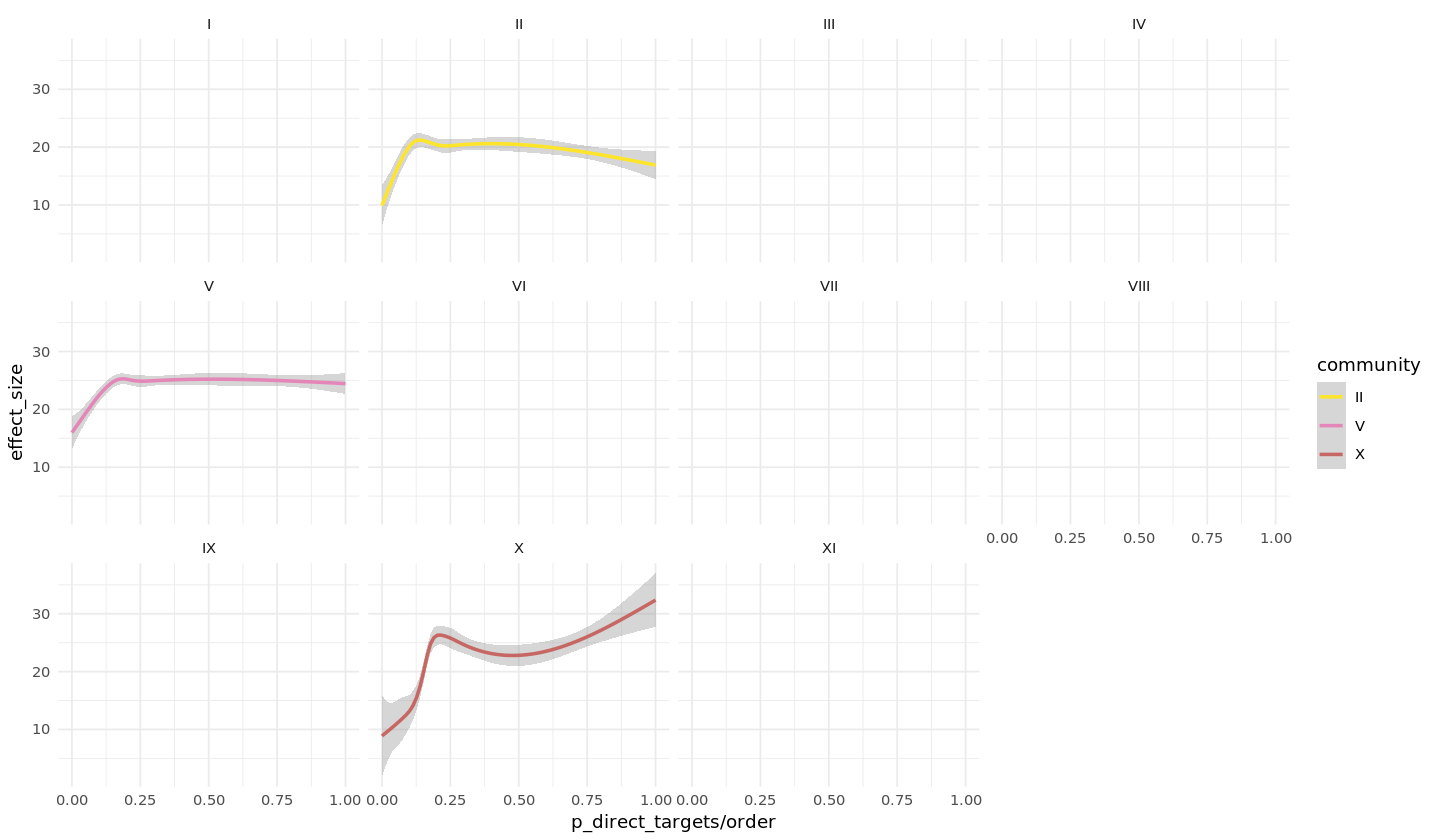

In [33]:
ggplot(PPP, aes(x=p_direct_targets/order,y=effect_size,colour=community)) + facet_wrap(~community) +
geom_smooth(method="gam") +scale_colour_manual(values=col2) 

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



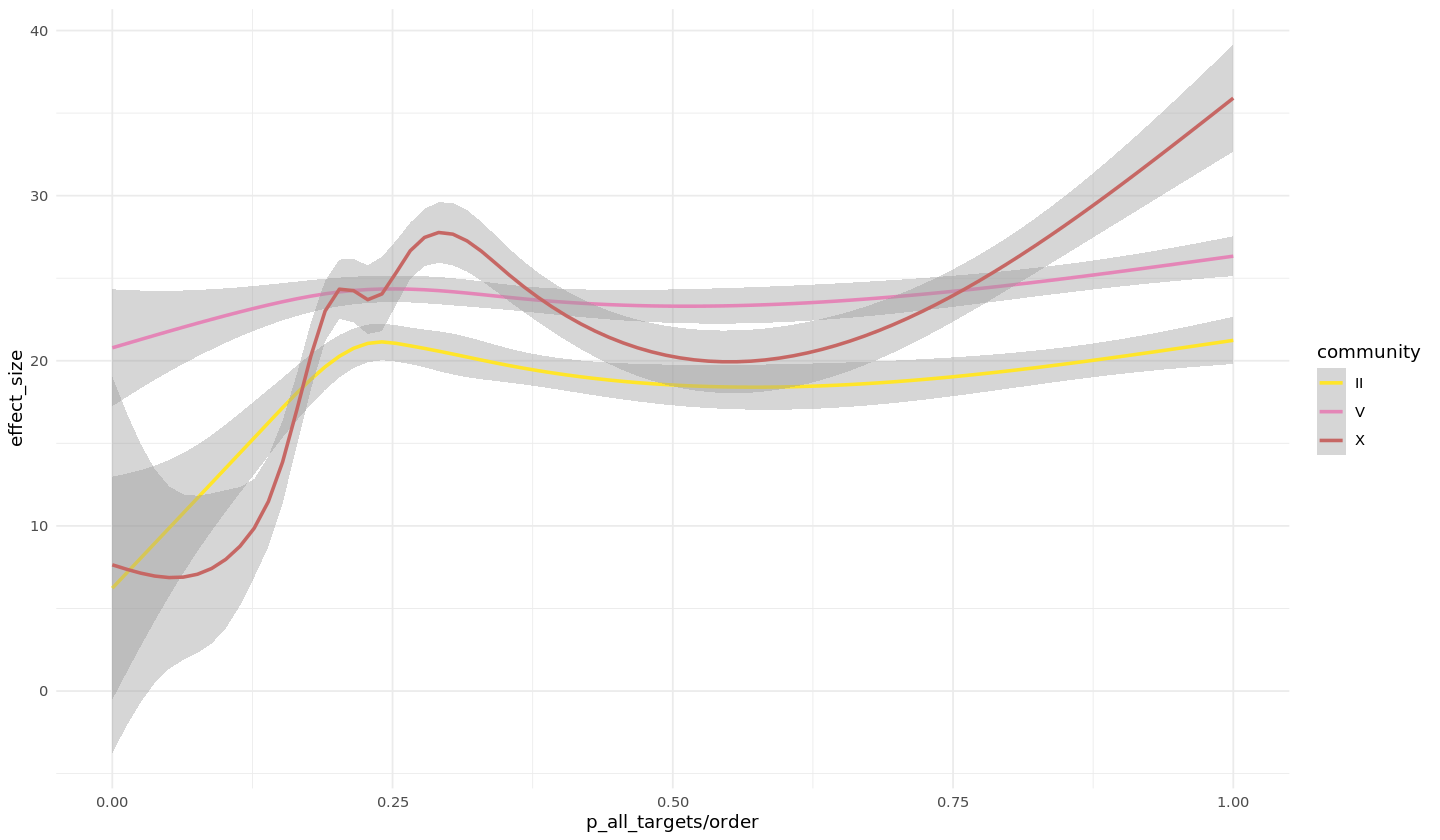

In [34]:
ggplot(PPP, aes(x=p_all_targets/order,y=effect_size,colour=community)) +
geom_smooth() +scale_colour_manual(values=col2) 

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



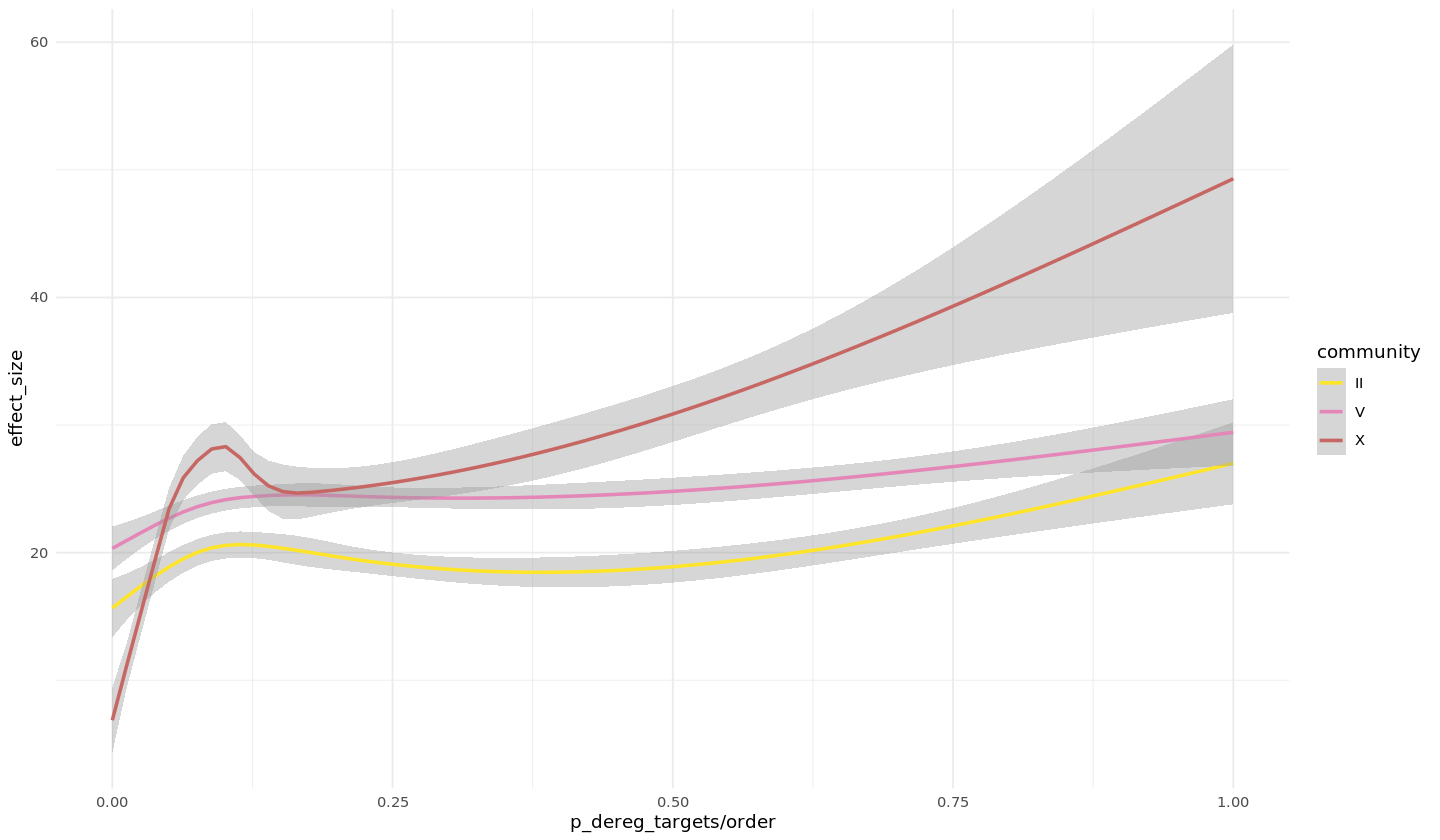

In [35]:
ggplot(PPP, aes(x=p_dereg_targets/order,y=effect_size,colour=community)) +
geom_smooth() +scale_colour_manual(values=col2) 

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



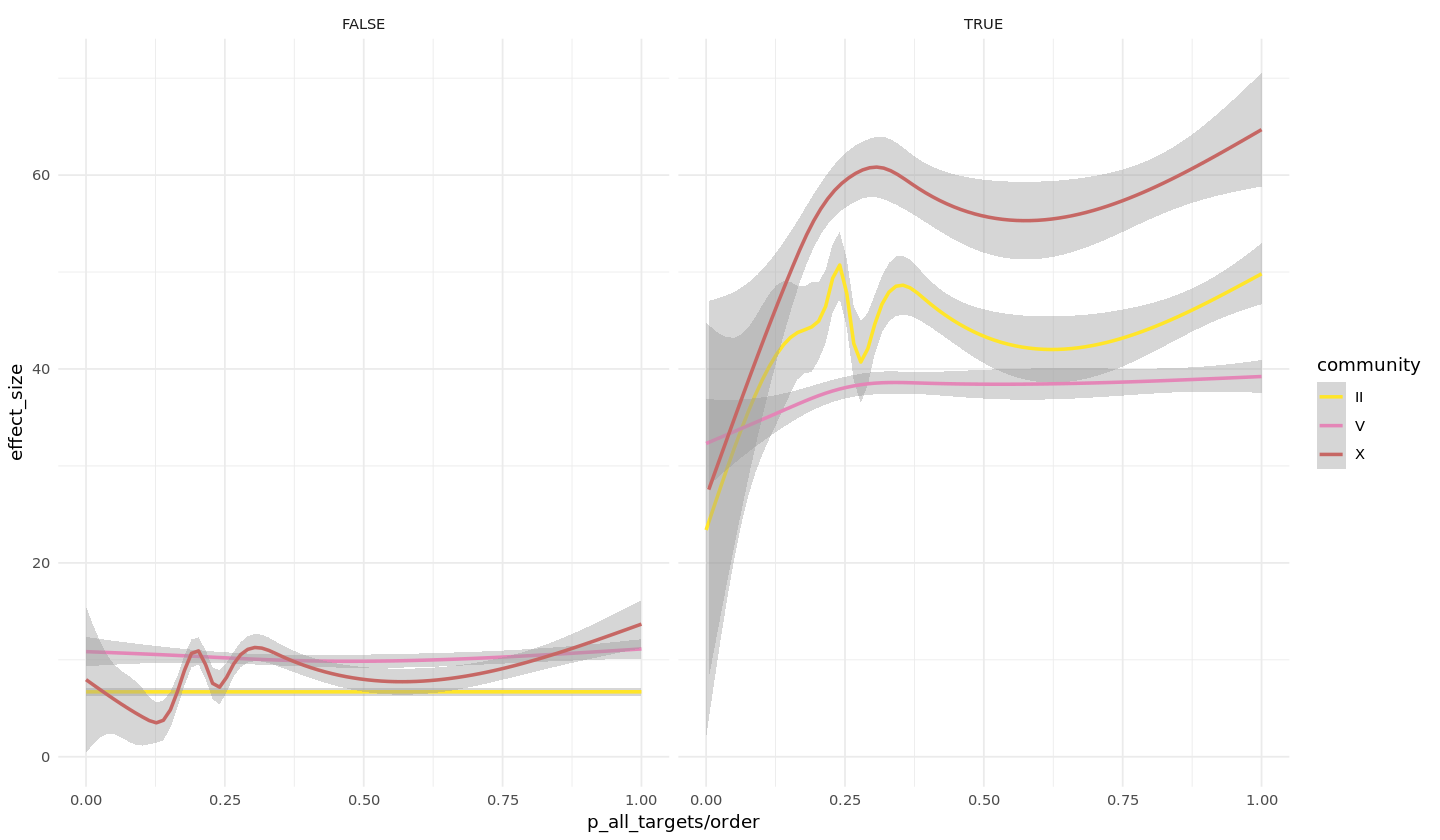

In [36]:
ggplot(PPP, aes(x=p_all_targets/order,y=effect_size,colour=community)) + facet_wrap(~is_significant) +
geom_smooth(method="gam") +scale_colour_manual(values=col2) 

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



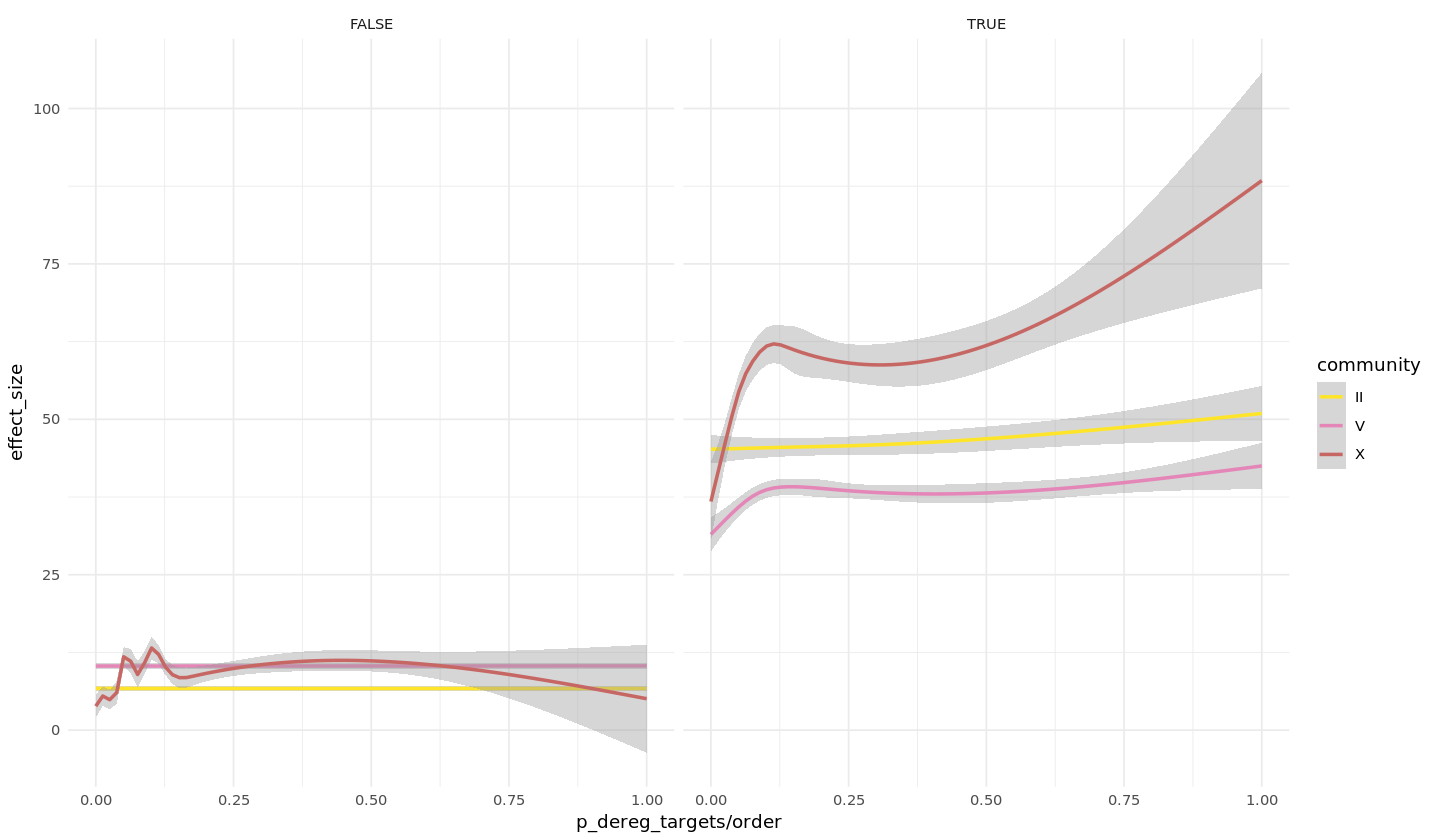

In [37]:
ggplot(PPP, aes(x=p_dereg_targets/order,y=effect_size,colour=community)) + facet_wrap(~is_significant) +
geom_smooth(method="gam") +scale_colour_manual(values=col2) 

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



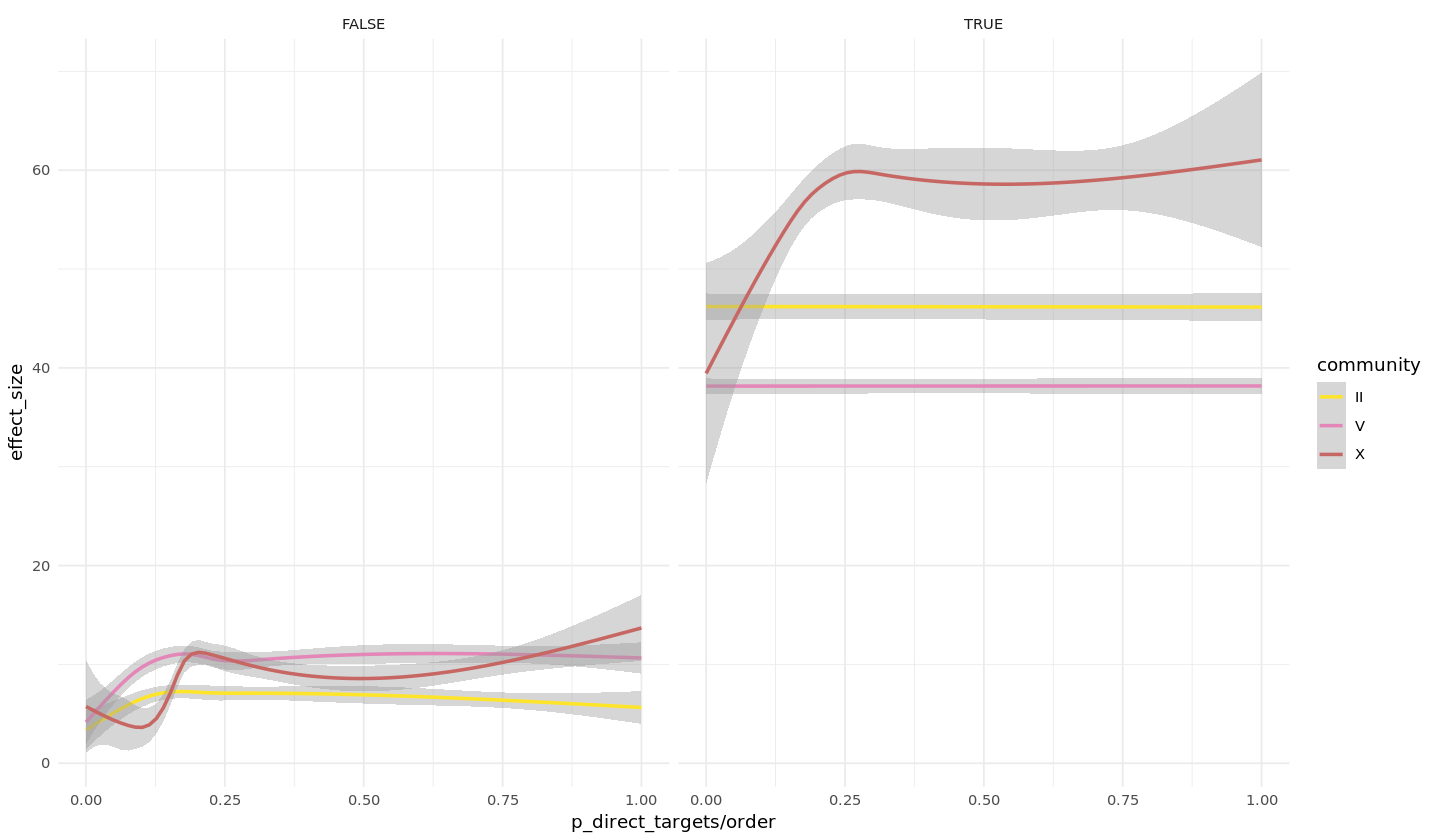

In [38]:
ggplot(PPP, aes(x=p_direct_targets/order,y=effect_size,colour=community)) + facet_wrap(~is_significant) +
geom_smooth(method="gam") +scale_colour_manual(values=col2) 

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



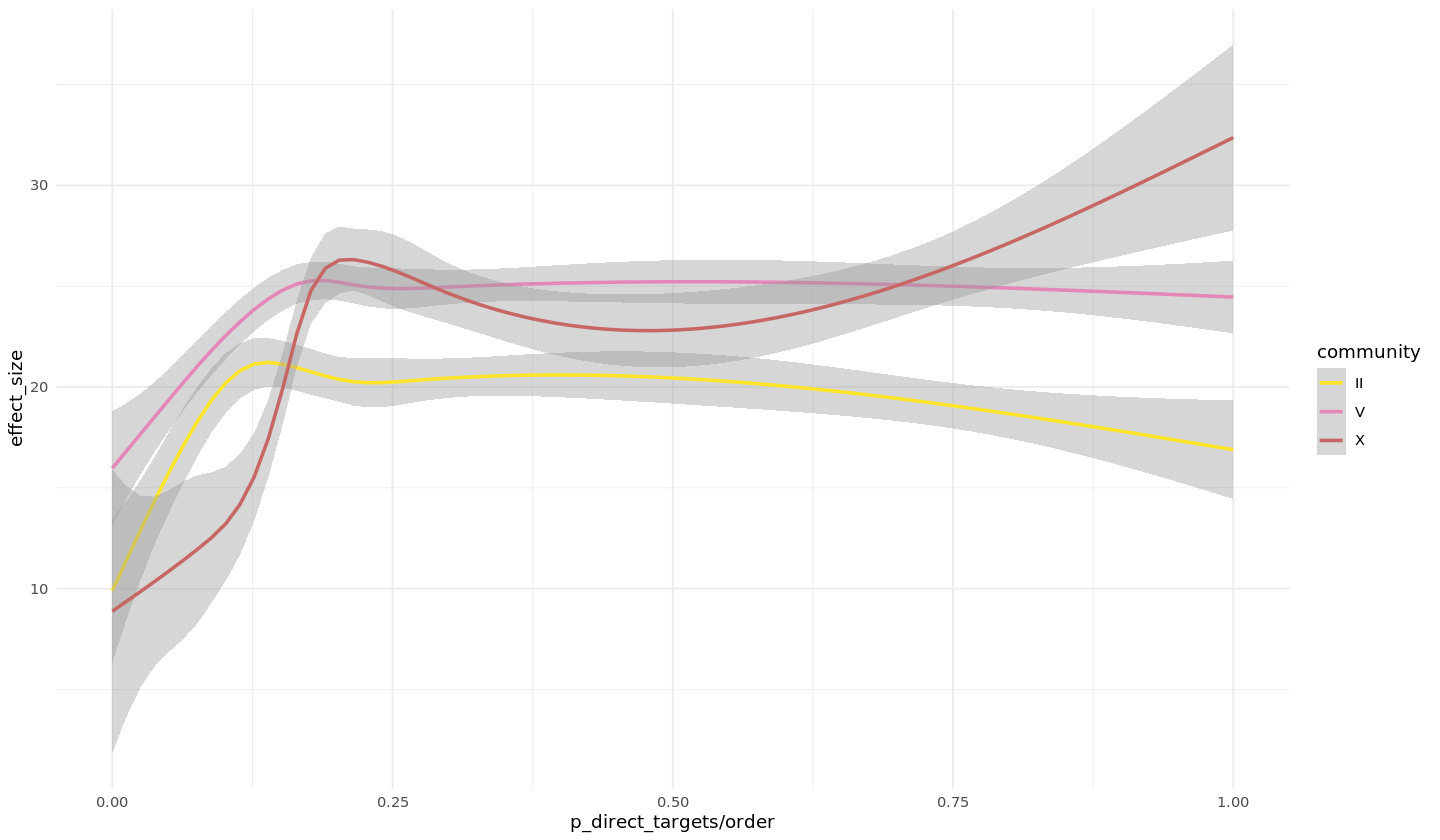

In [39]:
ggplot(PPP, aes(x=p_direct_targets/order,y=effect_size,colour=community)) +
geom_smooth() +scale_colour_manual(values=col2) 

`geom_smooth()` using formula 'y ~ x'



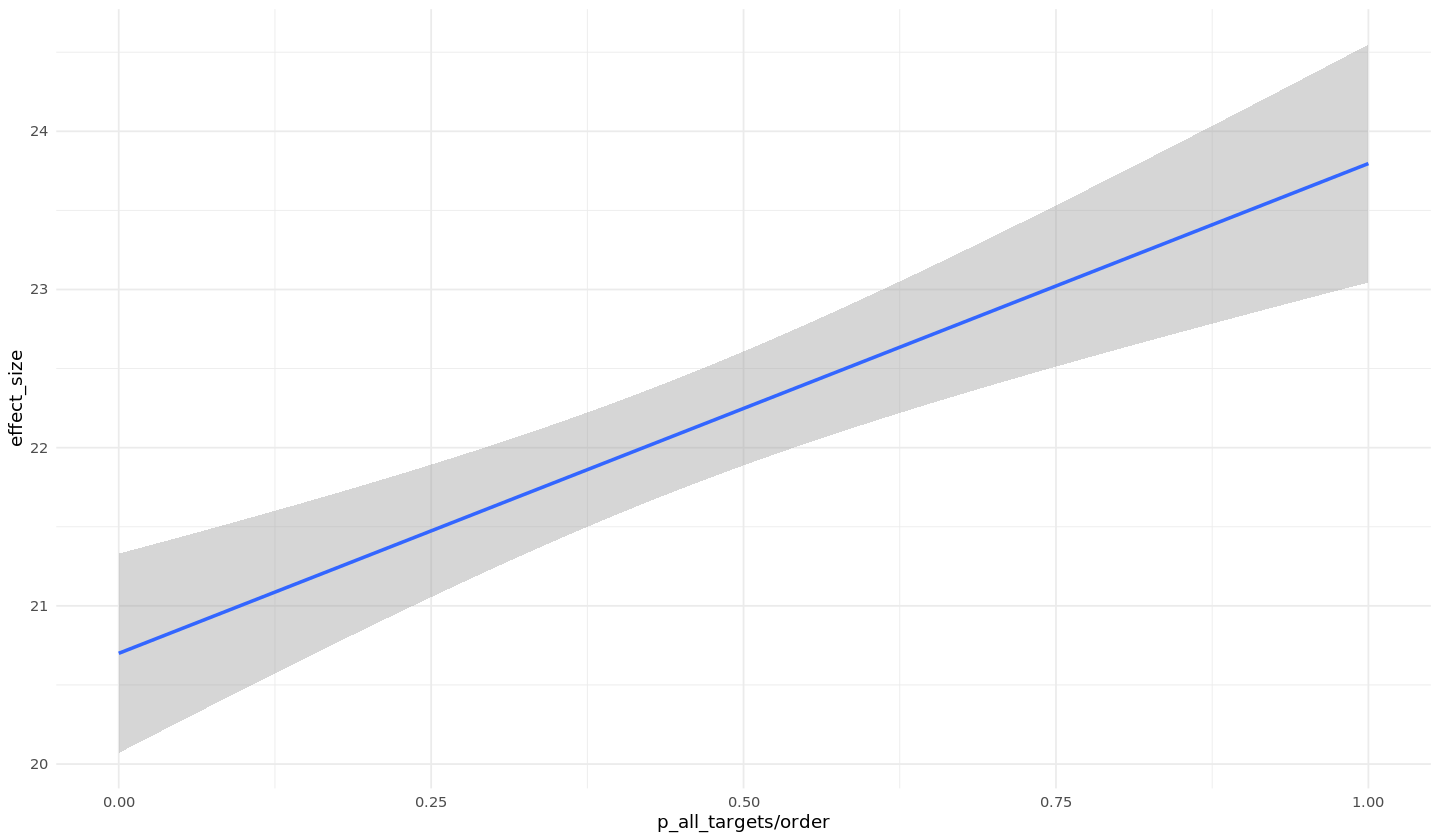

In [40]:
ggplot(PPP, aes(x=p_all_targets/order,y=effect_size)) +
geom_smooth(method="lm") 

`geom_smooth()` using formula 'y ~ x'



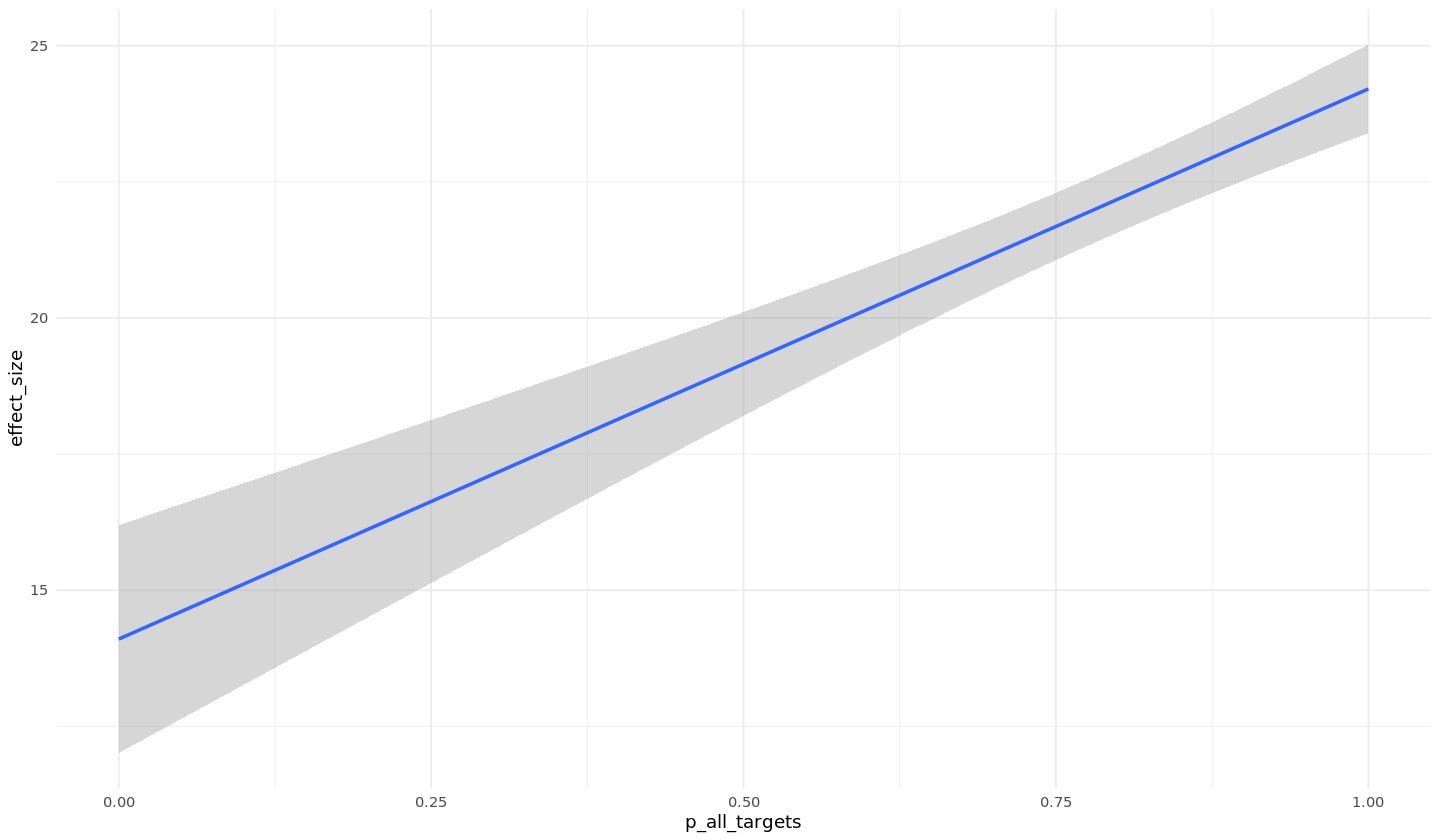

In [41]:
PPP %>% filter(order==1) %>%
ggplot(aes(x=p_all_targets,y=effect_size)) +
geom_smooth(method="lm") 

`geom_smooth()` using formula 'y ~ x'



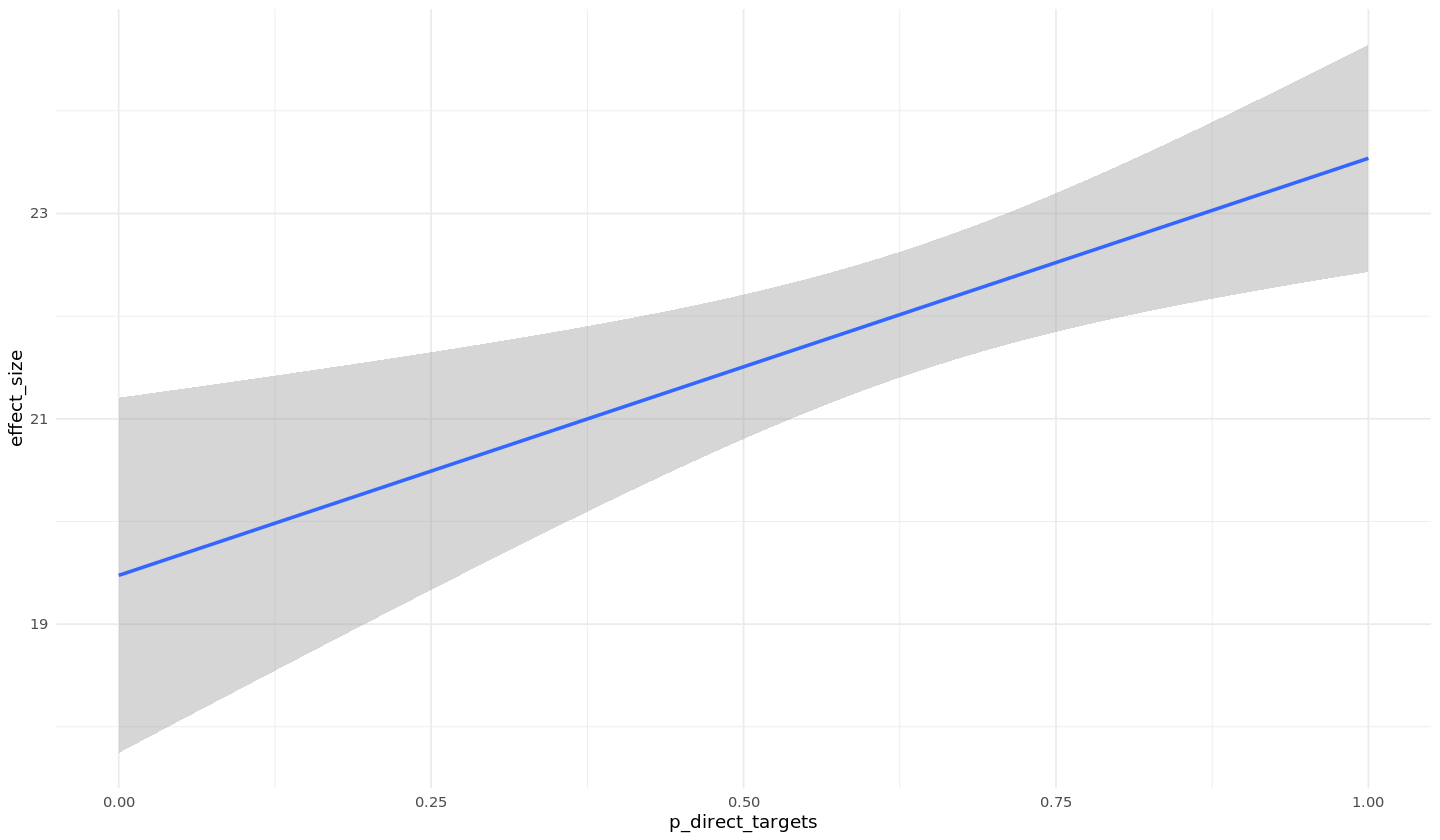

In [42]:
PPP %>% filter(order==1) %>%
ggplot(aes(x=p_direct_targets,y=effect_size)) +
geom_smooth(method="lm") 

`geom_smooth()` using formula 'y ~ x'



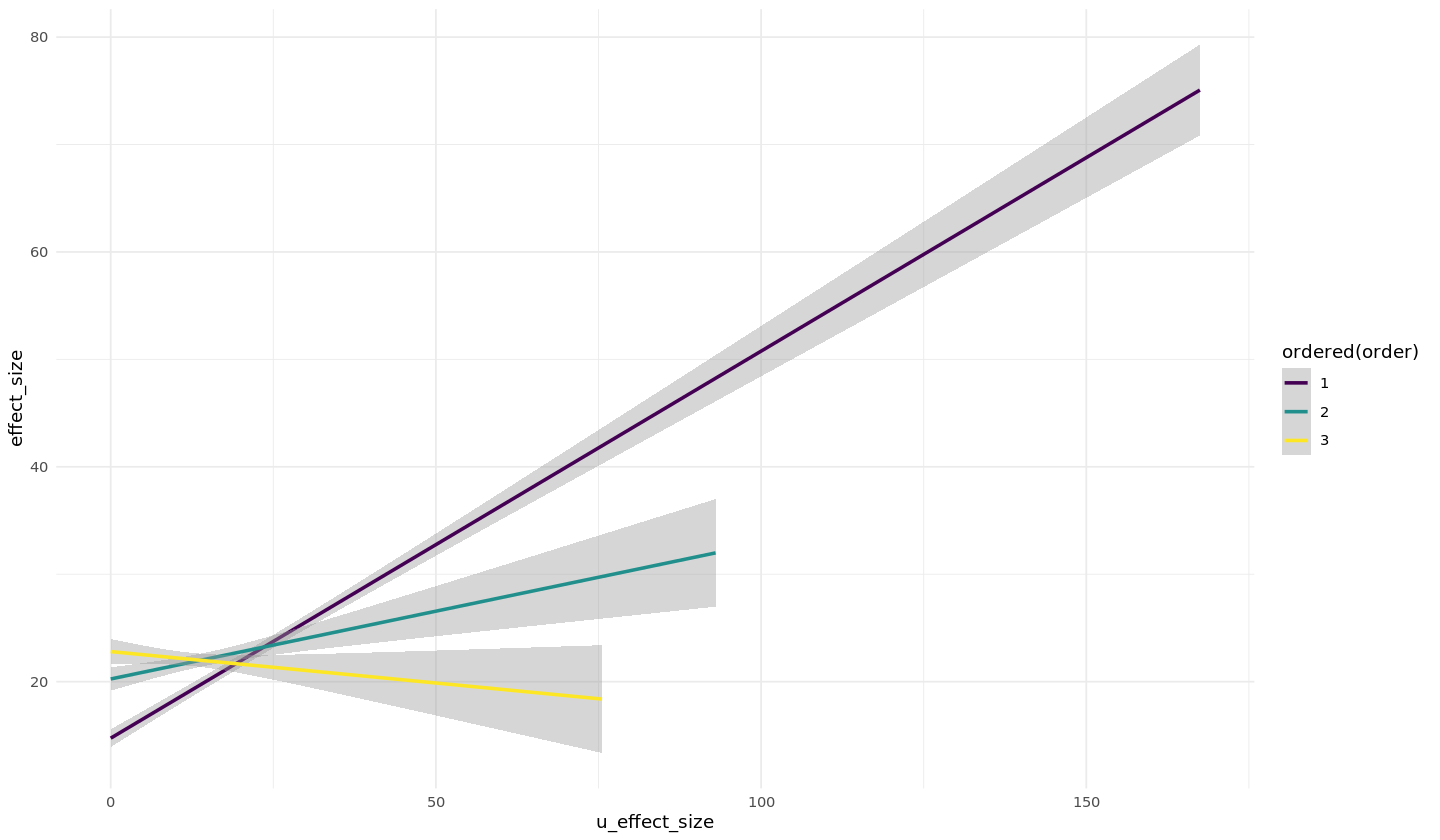

In [43]:
PPP %>%
ggplot(aes(x=u_effect_size,y=effect_size,colour=ordered(order))) +
geom_smooth(method="lm") 

`geom_smooth()` using formula 'y ~ x'



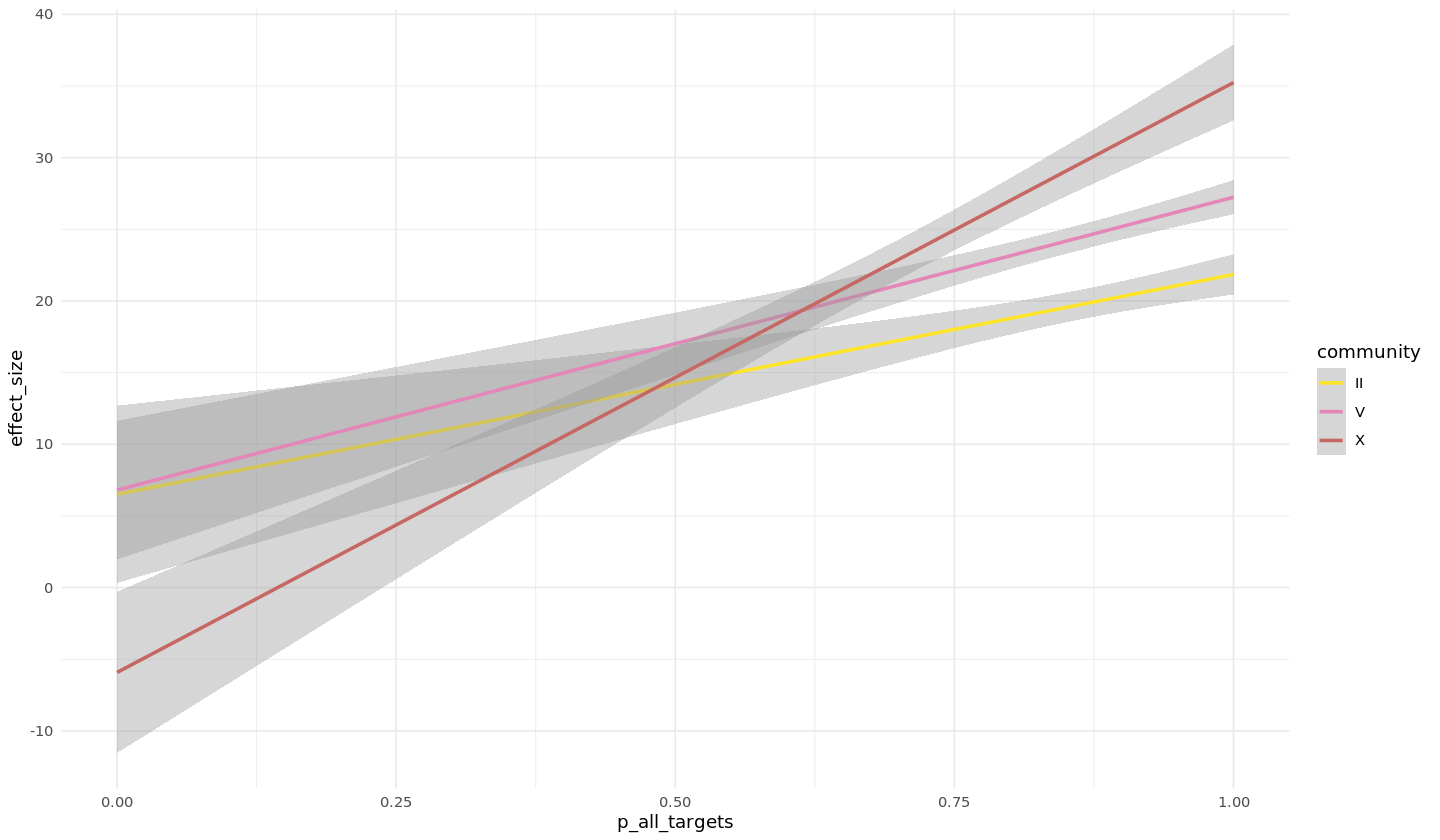

In [44]:
PPP %>% filter(order==1) %>%
ggplot(aes(x=p_all_targets,y=effect_size,colour=community)) +
geom_smooth(method="lm") +
scale_colour_manual(values=col2)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



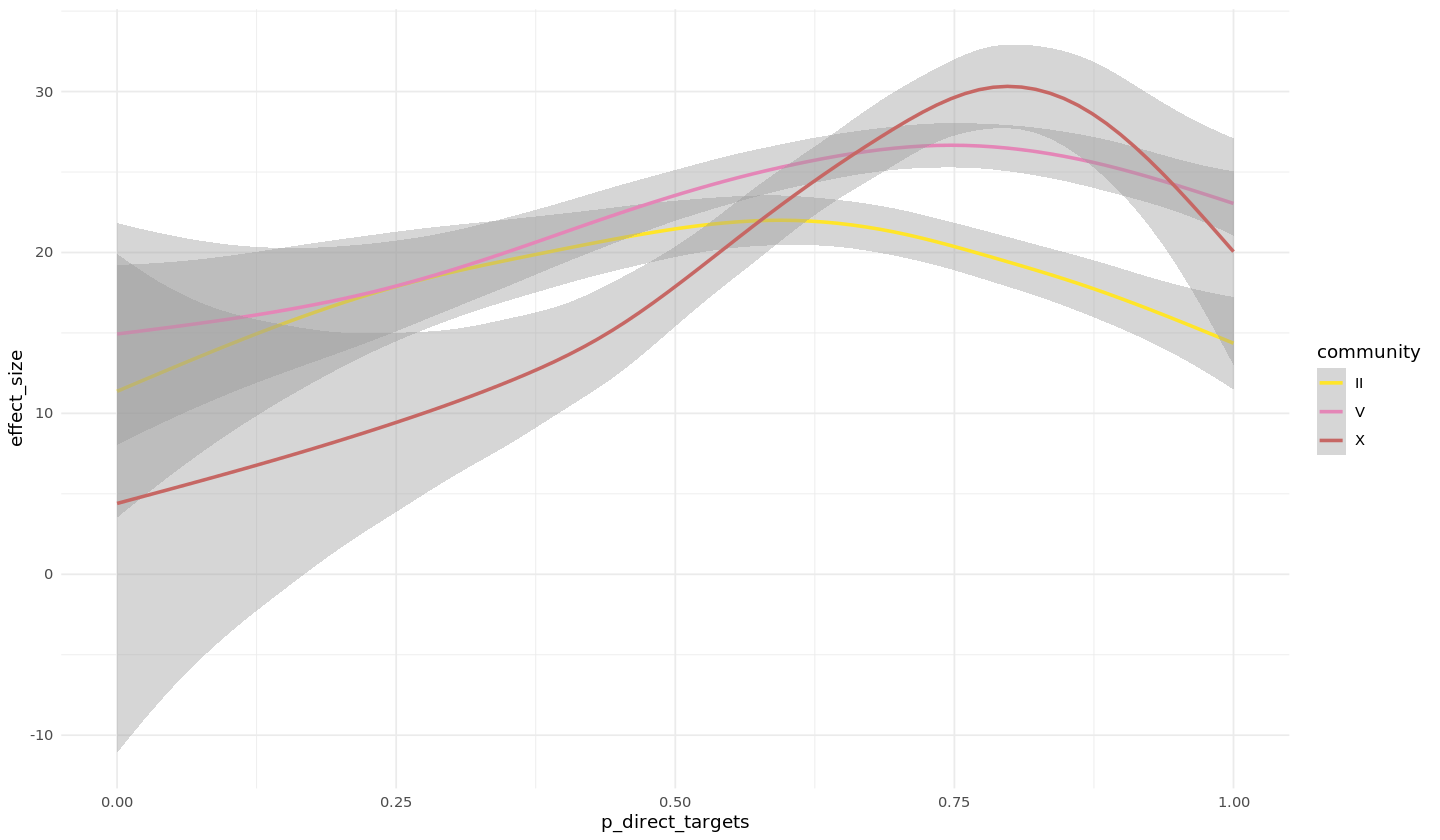

In [45]:
PPP %>% filter(order==1) %>%
ggplot(aes(x=p_direct_targets,y=effect_size,colour=community)) +
geom_smooth() +
scale_colour_manual(values=col2)

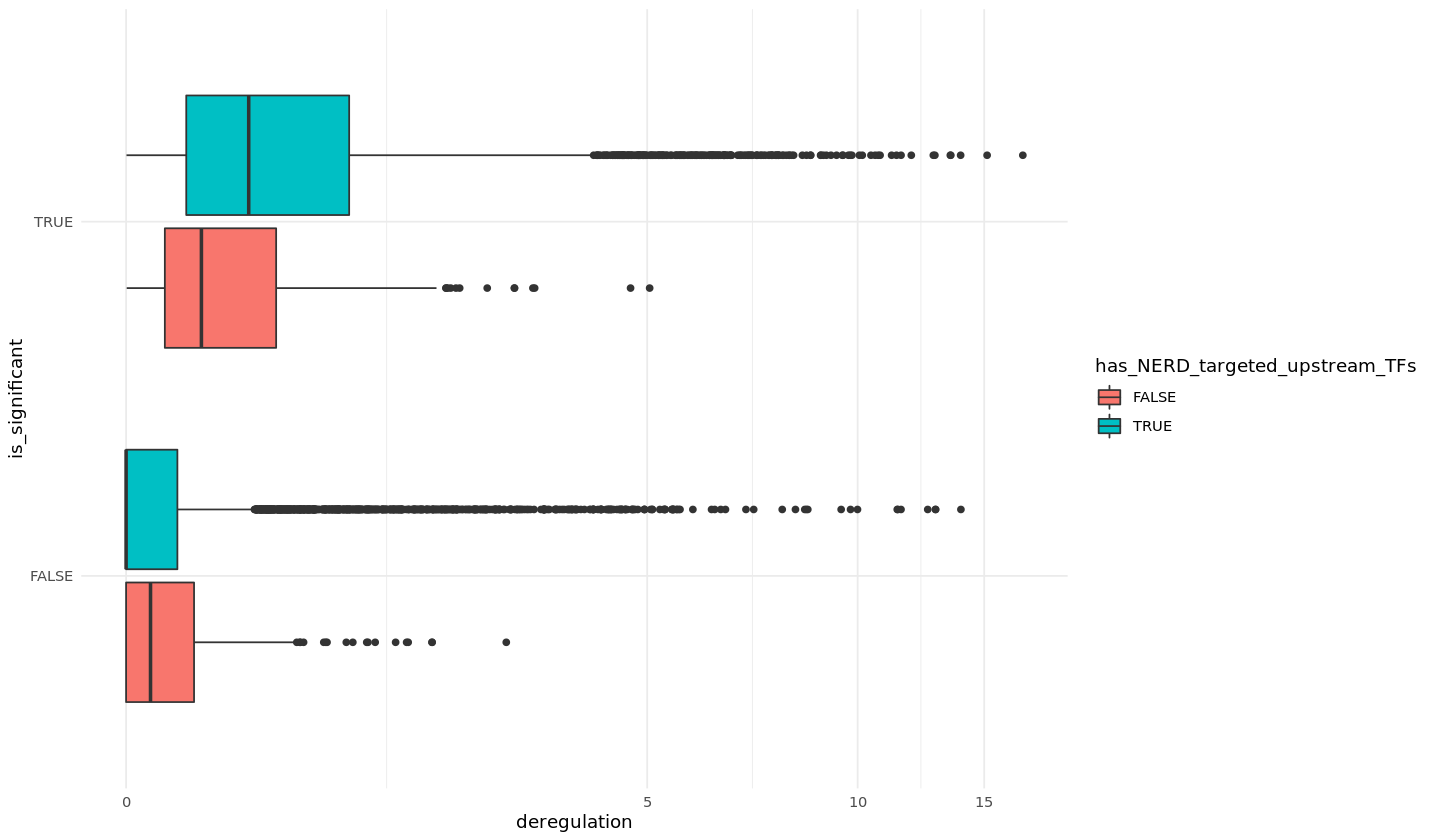

In [46]:
PPP %>% filter(order==1) %>% mutate(has_NERD_targeted_upstream_TFs=direct_targets>0) %>%
ggplot(aes(x=is_significant,y=deregulation,fill=has_NERD_targeted_upstream_TFs))+
geom_boxplot() + scale_y_continuous(trans=scales::pseudo_log_trans(base = 10)) + coord_flip()

In [47]:
fit=step(glm(effect_size~order*p_all_targets*p_direct_targets*community,data=PPP))

Start:  AIC=314816.1
effect_size ~ order * p_all_targets * p_direct_targets * community

                                                 Df Deviance    AIC
<none>                                              32958134 314816
- order:p_all_targets:p_direct_targets:community  2 32970813 314824


In [48]:
summary(fit)


Call:
glm(formula = effect_size ~ order * p_all_targets * p_direct_targets * 
    community, data = PPP)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-65.36  -19.99  -10.12    6.64  367.90  

Coefficients: (48 not defined because of singularities)
                                                     Estimate Std. Error
(Intercept)                                         1.542e+01  4.964e+00
order                                               3.589e-14  2.298e+00
p_all_targets                                       8.783e+01  1.588e+01
p_direct_targets                                    1.221e+01  1.999e+01
communityII                                        -2.997e+01  9.445e+00
communityIII                                       -9.384e-01  8.751e+00
communityIV                                         4.746e+00  8.455e+00
communityV                                         -3.543e+01  9.994e+00
communityVI                                         1.005e+01  1.064e+01
com

In [49]:
head(PPP)

head(PPP %>% select(2,4,8:9,11:13))

geneid           order u_deregulation u_effect_size
1 Pp3c1_10140.mRNA 1     1.1147099      34.10827     
2 Pp3c1_10140.mRNA 2     0.7643324      34.10827     
3 Pp3c1_10140.mRNA 3     0.5811811      30.18948     
4 Pp3c1_10449.mRNA 1     0.3996551      16.93980     
5 Pp3c1_10449.mRNA 2     0.5693604      14.24304     
6 Pp3c1_10449.mRNA 3     0.6705439      18.92206     
  u_local_reaching_centrality u_sites_rel u_tertiary_deaminated_rel
1 0.9988352                   0.06872852  0.010309278              
2 0.9988352                   0.07425743  0.009259259              
3 0.9988352                   0.06872852  0.008385744              
4 0.9893593                   0.09183673  0.005681818              
5 0.9893593                   0.08191222  0.005550936              
6 0.9893593                   0.08203156  0.005722753              
  u_tertiary_oxidized_or_acetylated_rel u_secondary_ATE_rel
1 0                                     0.001808318        
2 0                                     0.002057613        
3 0                                     0.002057613        
4 0                                     0.006122449        
5 0                                     0.002029600        
6 0                                     0.002464086        
  u_secondary_peptidase_rel ⋯ local_reaching_centrality centrality_rank
1 0.01681957                ⋯ 0                         3077           
2 0.01980198                ⋯ 0                         3077           
3 0.01100917                ⋯ 0                         3077           
4 0.01017812                ⋯ 0                          758           
5 0.01717982                ⋯ 0                          758           
6 0.01536098                ⋯ 0                          758           
  NERD_target SLC sites_rel  tertiary_deaminated_rel
1 TRUE        S4  0.12977099 0                      
2 TRUE        S4  0.12977099 0                      
3 TRUE        S4  0.12977099 0                      
4 TRUE        S2  0.03030303 0                      
5 TRUE        S2  0.03030303 0                      
6 TRUE        S2  0.03030303 0                      
  tertiary_oxidized_or_acetylated_rel secondary_ATE_rel secondary_peptidase_rel
1 0                                   0                 0.01526718             
2 0                                   0                 0.01526718             
3 0                                   0                 0.01526718             
4 0                                   0                 0.03030303             
5 0                                   0                 0.03030303             
6 0                                   0                 0.03030303             
  primary_acetylated_rel
1 0.09160305            
2 0.09160305            
3 0.09160305            
4 0.00000000            
5 0.00000000            
6 0.00000000

order u_effect_size u_tertiary_oxidized_or_acetylated_rel u_secondary_ATE_rel
1 1     34.10827      0                                     0.001808318        
2 2     34.10827      0                                     0.002057613        
3 3     30.18948      0                                     0.002057613        
4 1     16.93980      0                                     0.006122449        
5 2     14.24304      0                                     0.002029600        
6 3     18.92206      0                                     0.002464086        
  u_primary_acetylated_rel all_targets dereg_targets
1 0.04123711                3           2           
2 0.04455446                8           5           
3 0.04220183               14           9           
4 0.05113636                6           4           
5 0.04500127               29          15           
6 0.04744731               93          35

In [50]:
PPPP=PPP %>% mutate(col=ordered(ifelse(is_significant,as.character(community),"YY")))
table(PPPP$col)


    I    II   III    IV    IX     V    VI   VII  VIII     X    XI    YY 
   99  4386    48    87   237  5178    51    96    75  2103    99 19761 

In [51]:
#res.pca=PCA(PPP %>% filter(order==3) %>% select(4,8:9,11:13), graph = FALSE, scale.unit=TRUE,quali.sup=5:6)
res.pca=PCA(PPP %>% select(2,4,8:9,11:13), graph = FALSE, scale.unit=TRUE,quali.sup=6:7)

In [52]:
options(repr.plot.width=7, repr.plot.height=7)

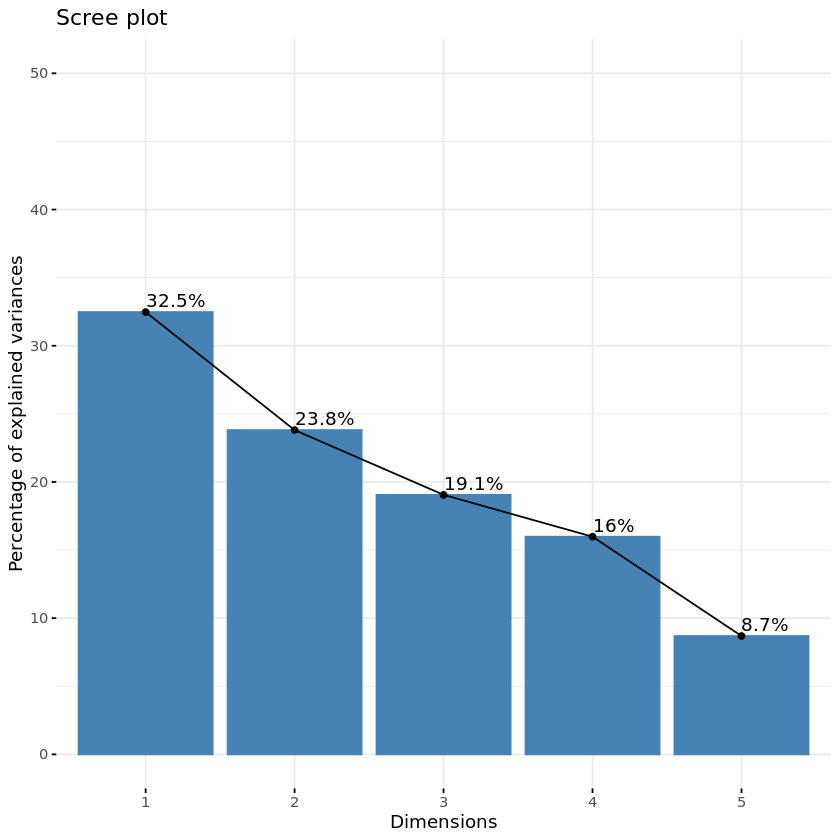

In [53]:
fviz_eig(res.pca, addlabels = TRUE, ylim = c(0, 50))

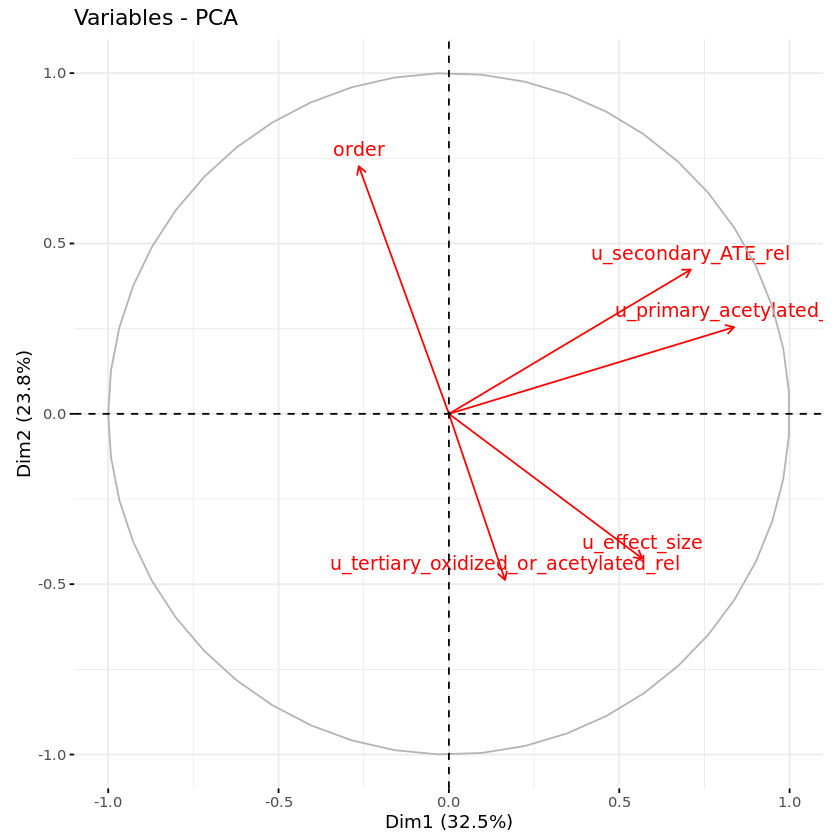

In [54]:
fviz_pca_var(res.pca, col.var = "red")

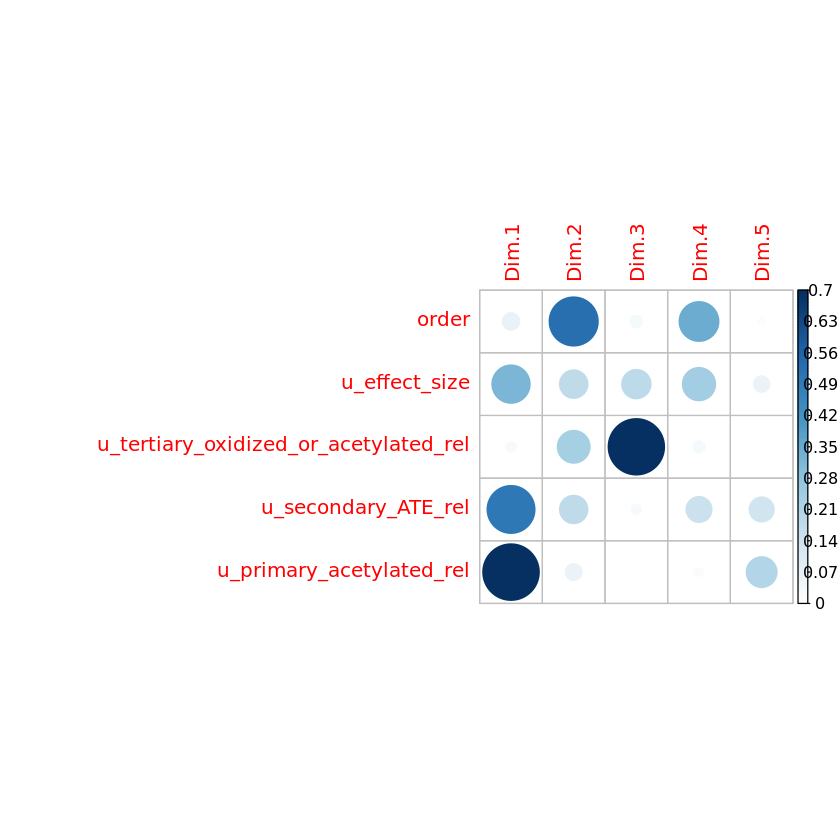

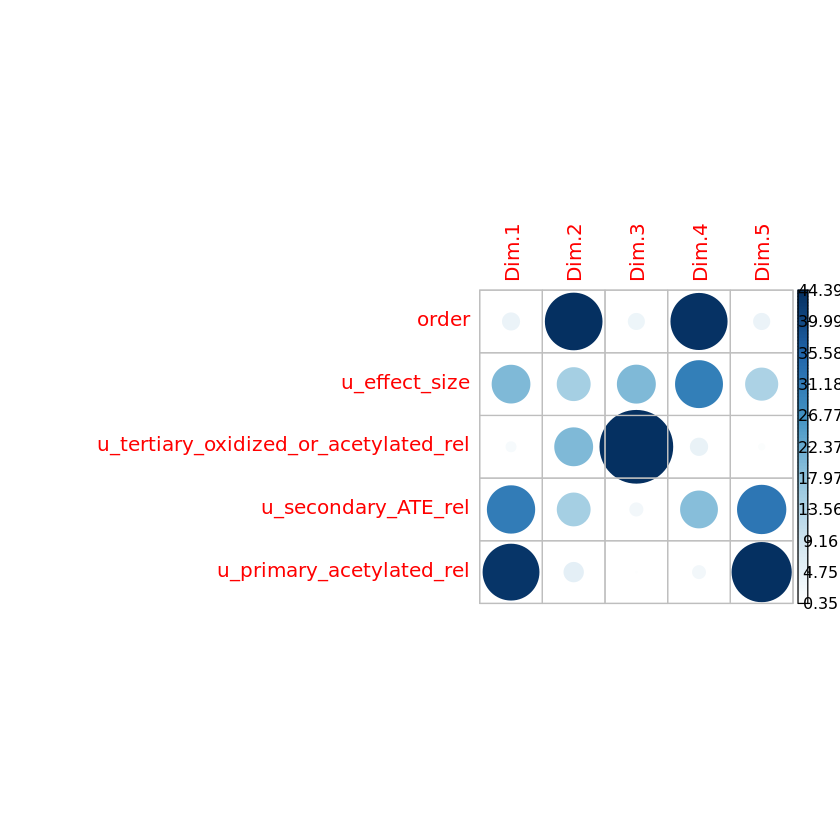

In [55]:
corrplot(res.pca$var$cos2, is.corr=FALSE)
corrplot(res.pca$var$contrib, is.corr=FALSE)    

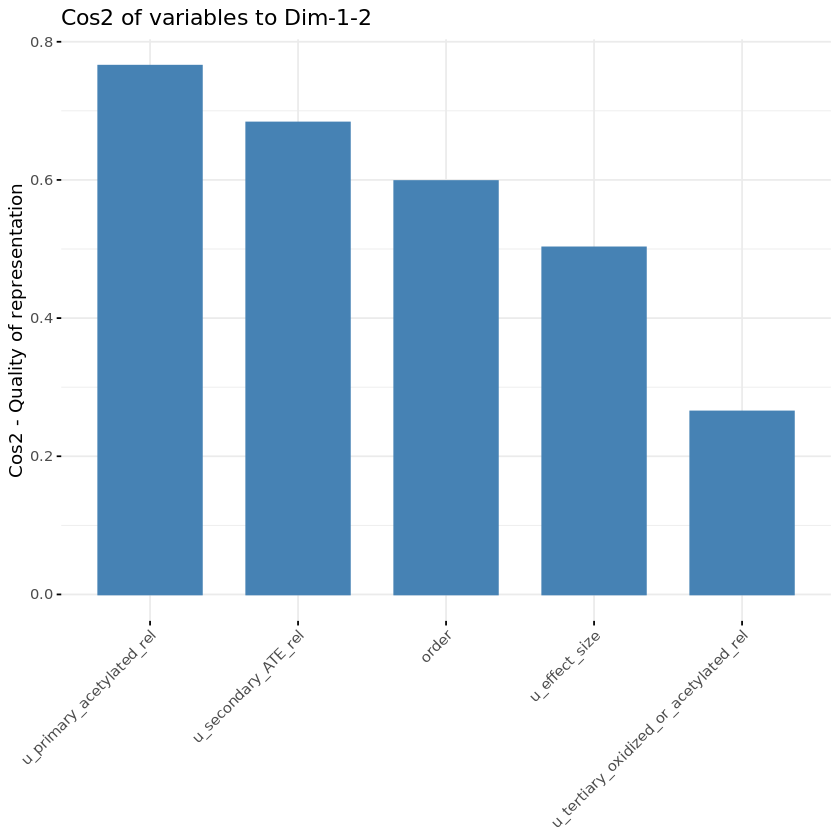

In [56]:
fviz_cos2(res.pca, choice = "var", axes = 1:2)

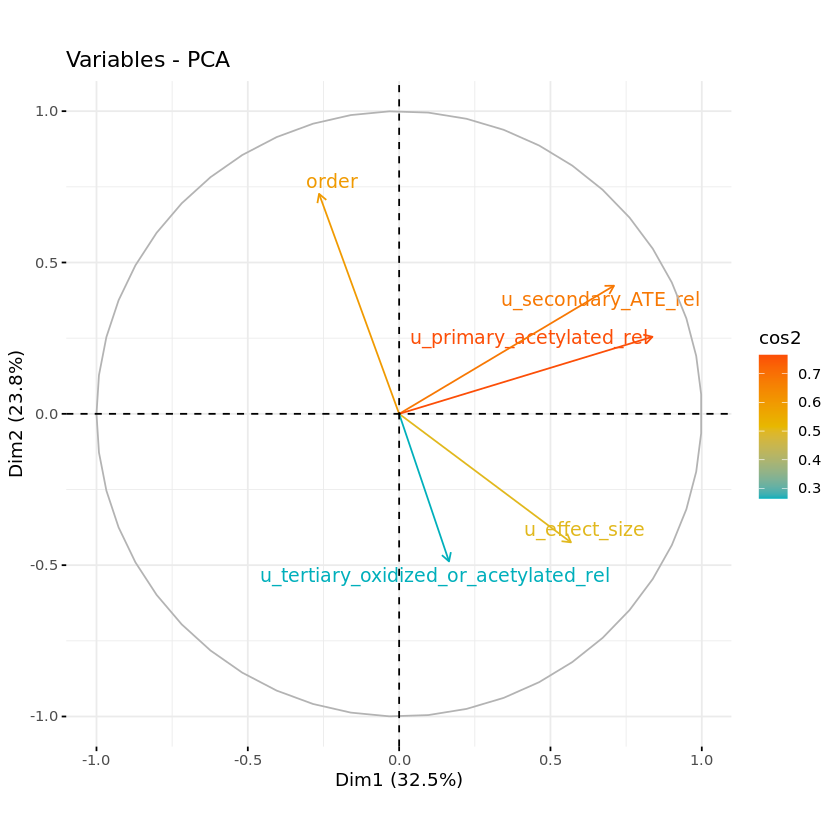

In [57]:
fviz_pca_var(res.pca, col.var = "cos2",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"), 
             repel = TRUE # Avoid text overlapping
             )

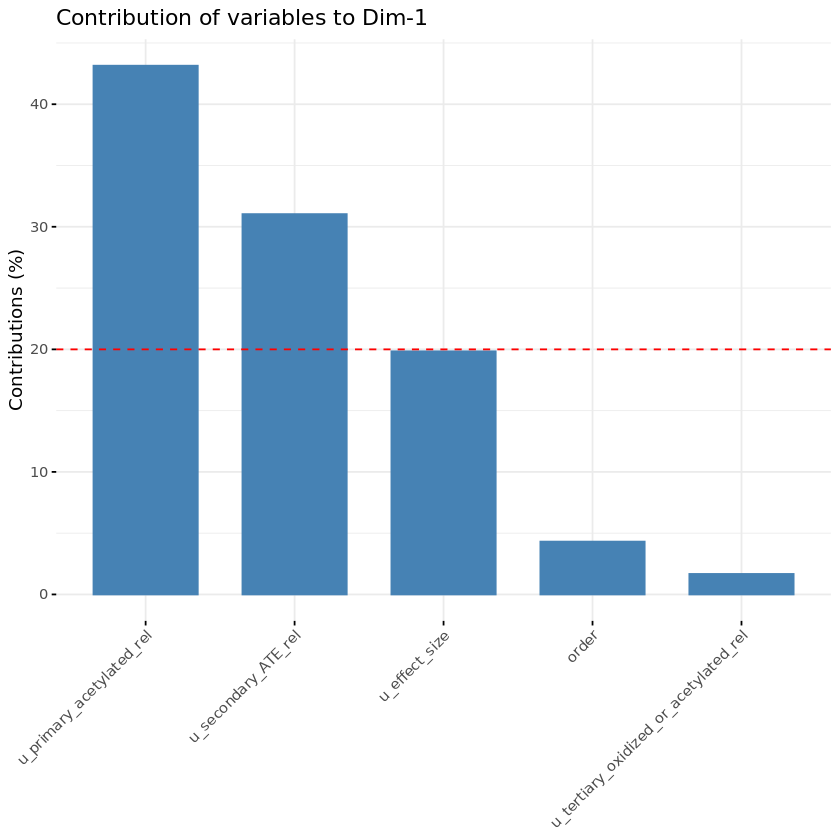

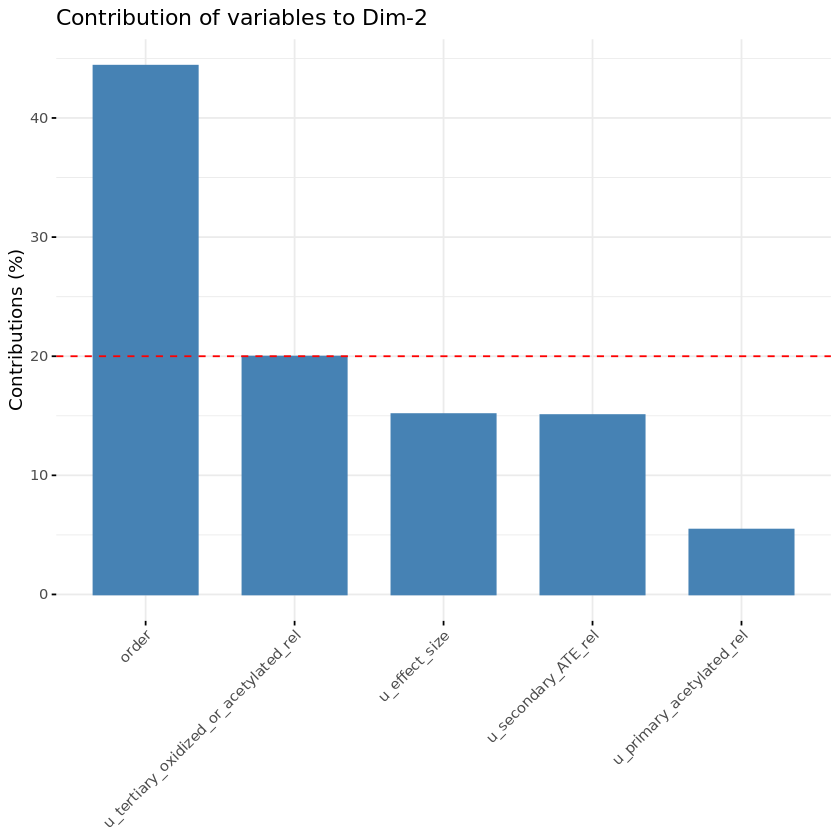

In [58]:
# Contributions of variables to PC1
fviz_contrib(res.pca, choice = "var", axes = 1, top = 10)
# Contributions of variables to PC2
fviz_contrib(res.pca, choice = "var", axes = 2, top = 10)

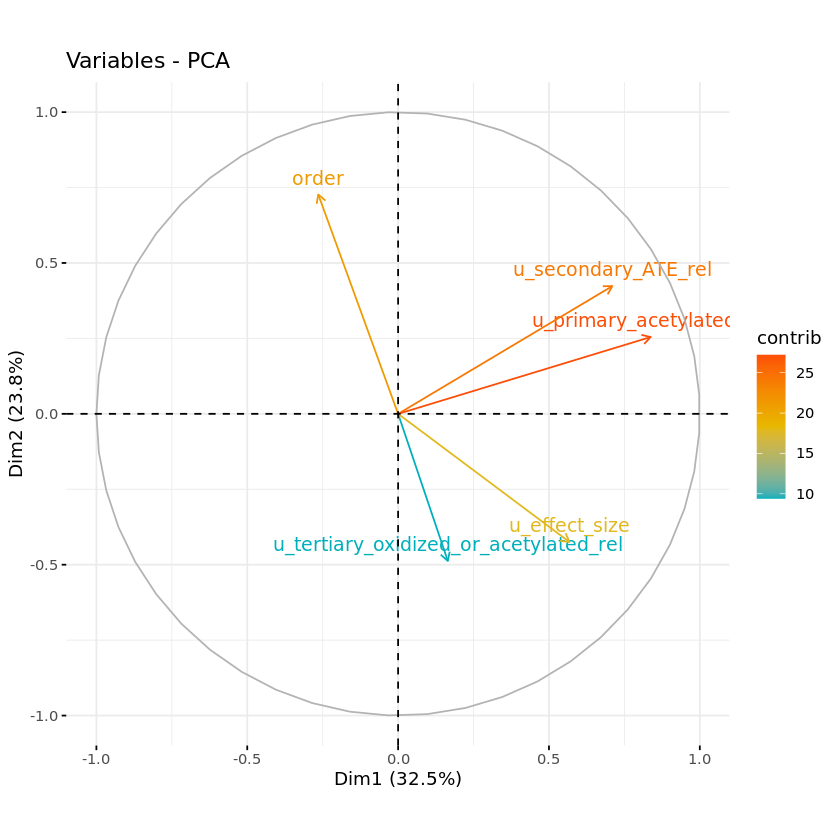

In [59]:
fviz_pca_var(res.pca, col.var = "contrib",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07")
             )

In [60]:
options(repr.plot.width=15, repr.plot.height=12)

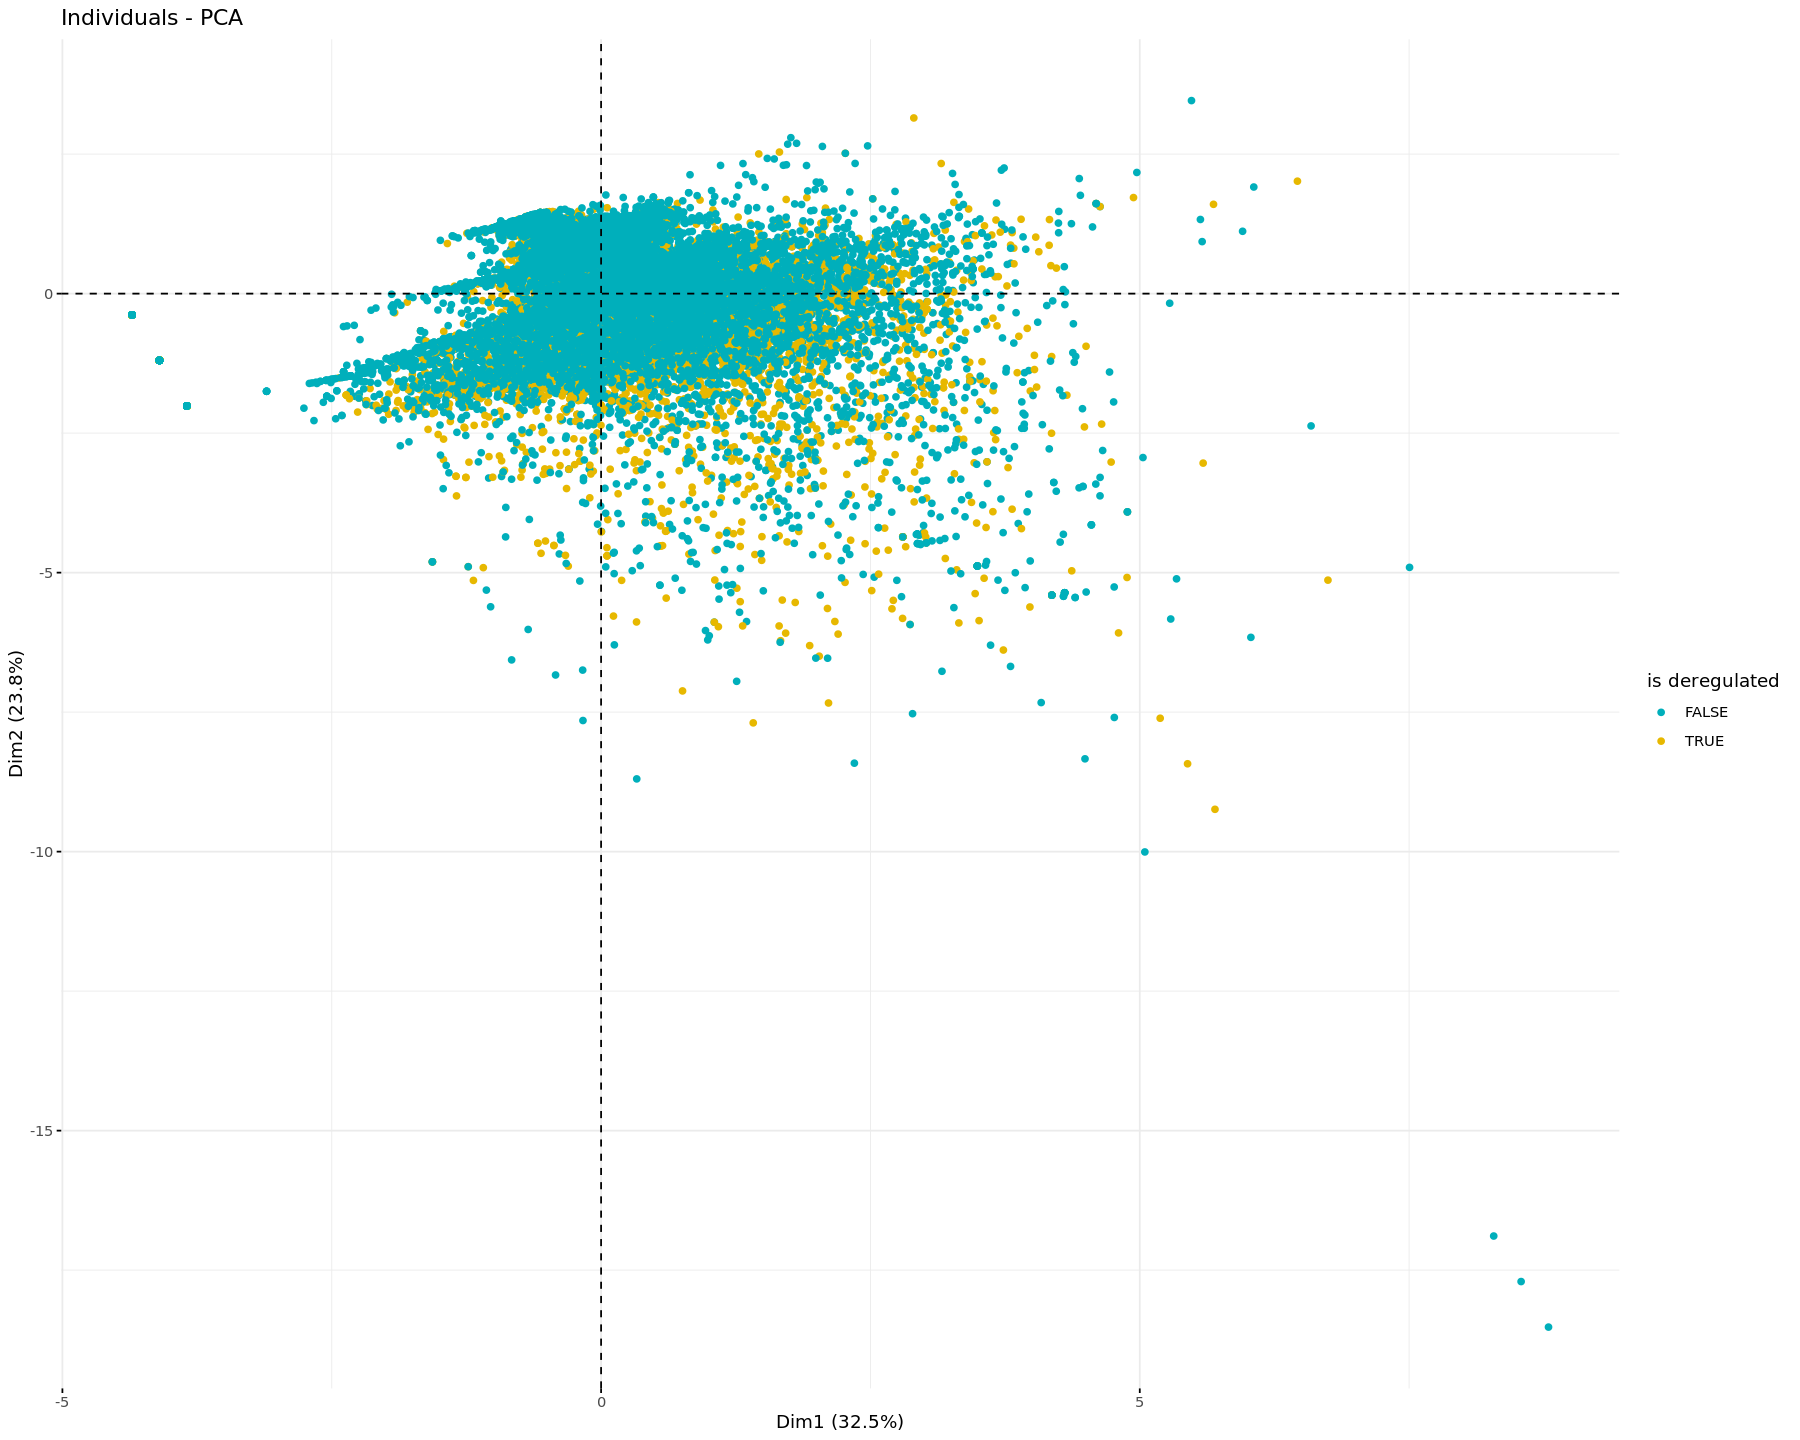

In [61]:
fviz_pca_ind(res.pca,
             geom.ind = "point", # show points only (nbut not "text")
             #col.ind = PPP%>% filter(order==2) %>% select(is_significant) %>% unlist(.,use.names=F), # color by groups
             col.ind = PPP%>% select(is_significant) %>% unlist(.,use.names=F), # color by groups
             palette = c("#00AFBB", "#E7B800", "#FC4E07"),
             addEllipses = FALSE, # Concentration ellipses
             legend.title = "is deregulated"
             )

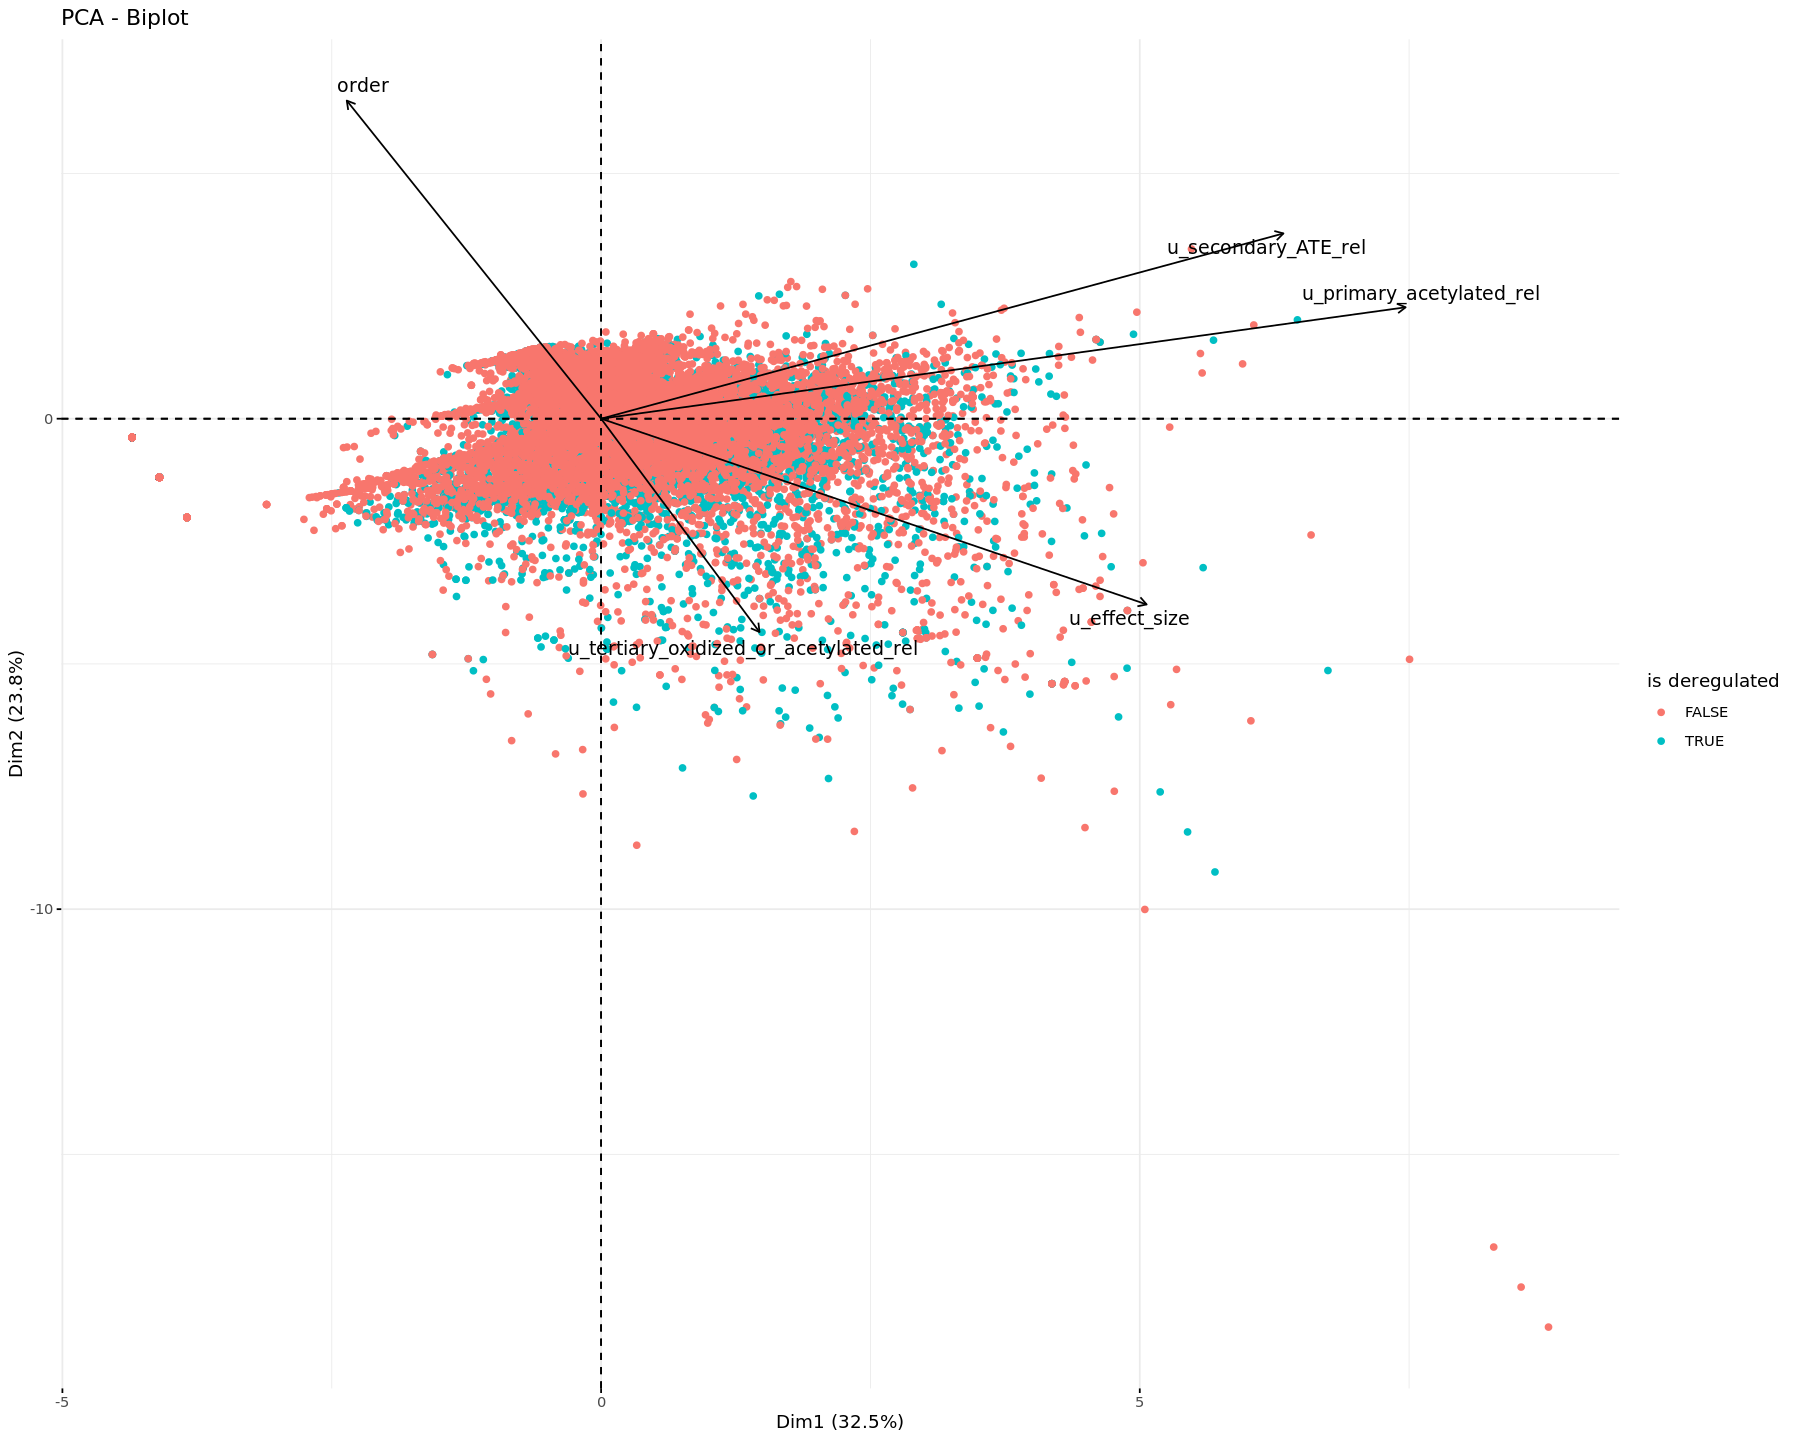

In [62]:
fviz_pca_biplot(res.pca, repel = TRUE,
             geom.ind = "point", # show points only (nbut not "text")
                col.var = "black", # Variables color
             #col.ind = PPP%>% filter(order==2) %>% select(is_significant) %>% unlist(.,use.names=F), # color by groups
             col.ind = PPP %>% select(is_significant) %>% unlist(.,use.names=F), # color by groups
             legend.title = "is deregulated"
            )

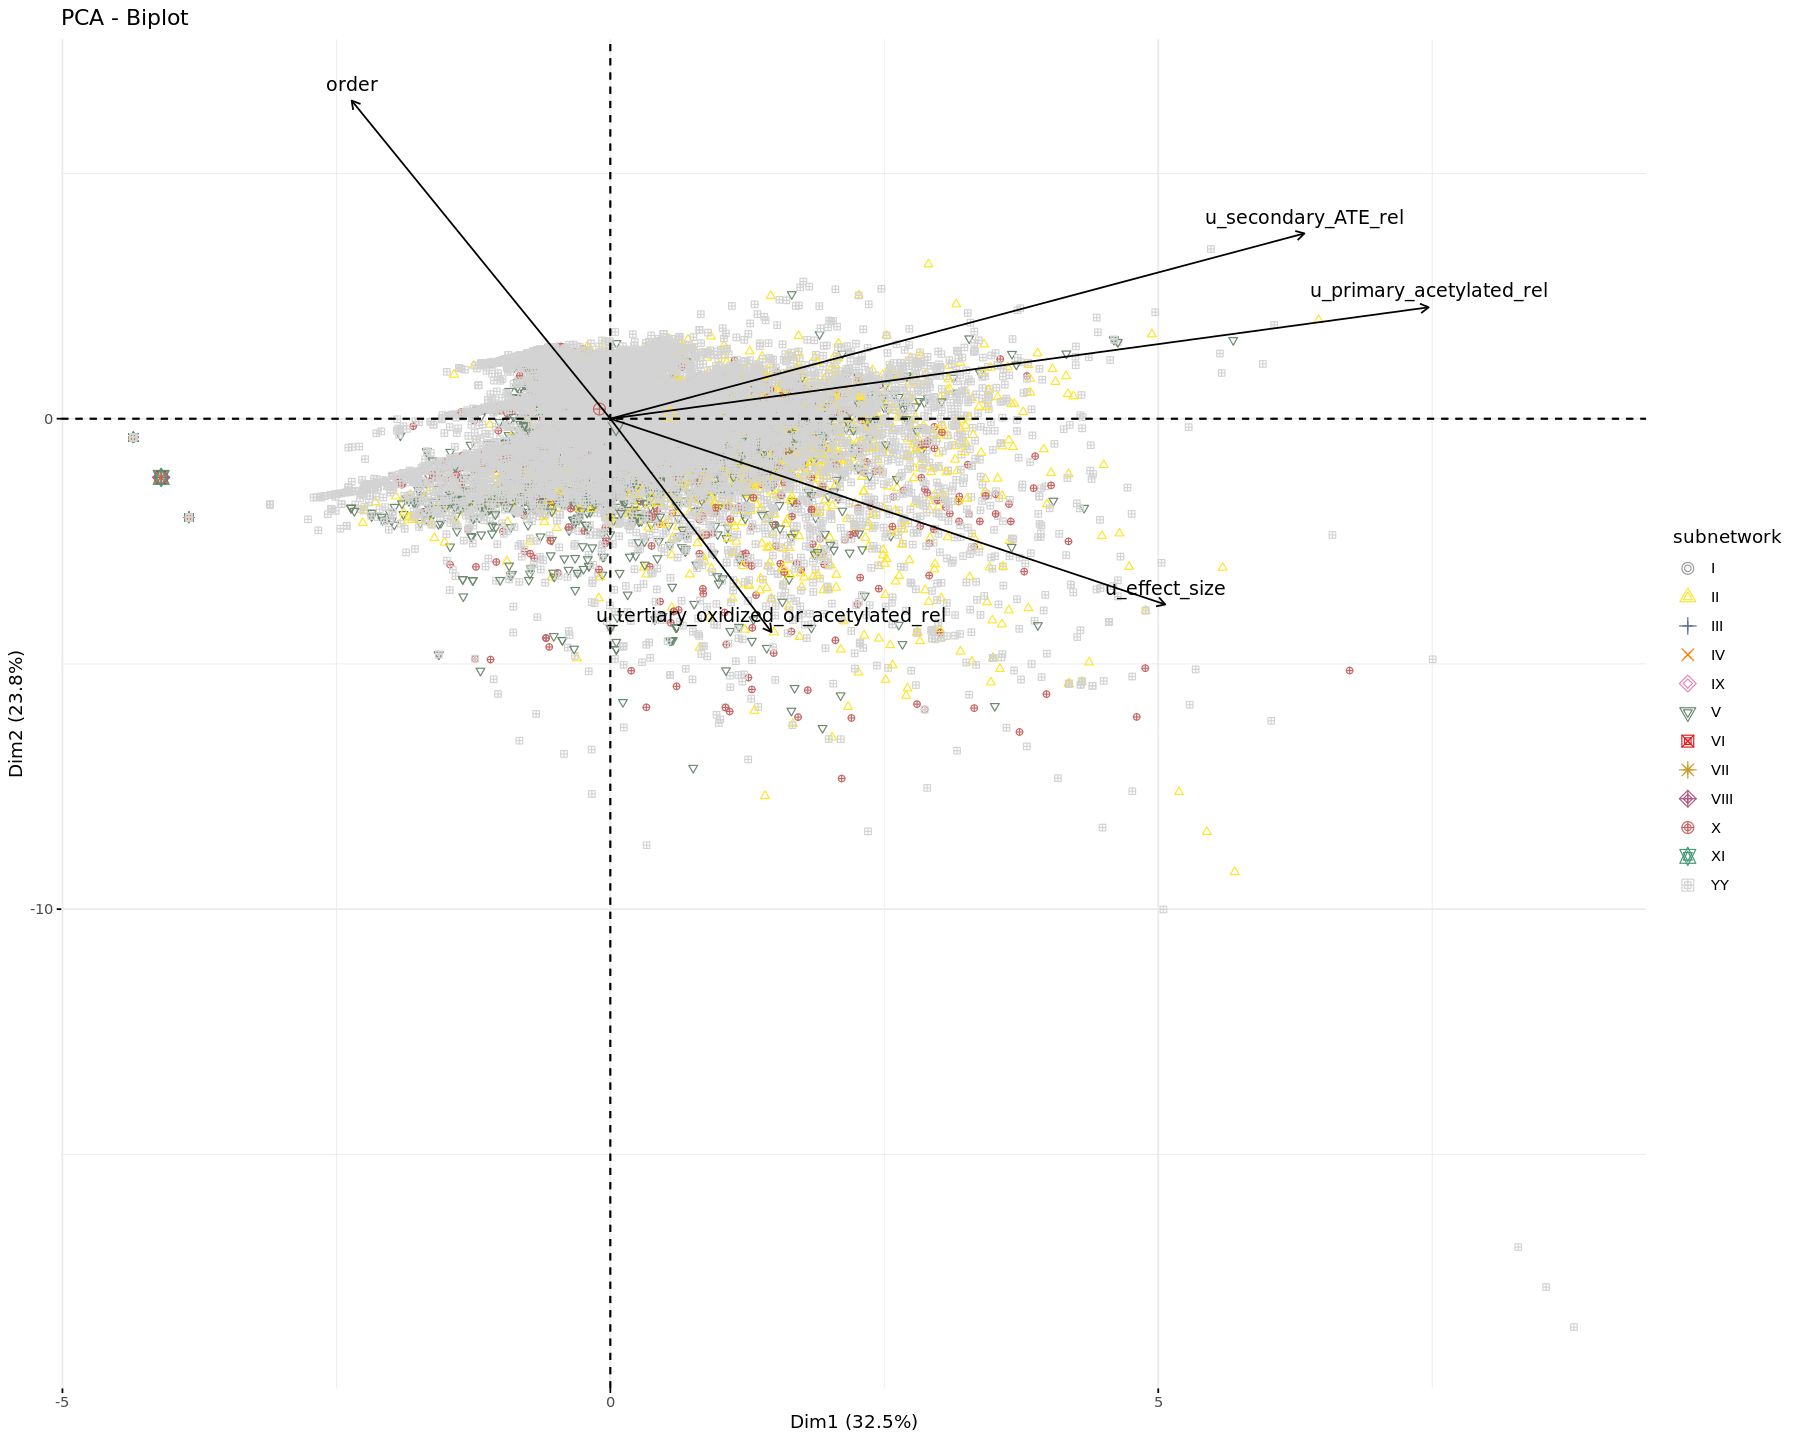

In [63]:
g= fviz_pca_biplot(res.pca, repel = FALSE,
             geom.ind = "point", # show points only (nbut not "text")
                 #col.ind = PPP%>% filter(order==2) %>% select(community) %>% unlist(.,use.names=F), # color by groups
                 col.ind = PPPP%>% select(col) %>% unlist(.,use.names=F), # color by groups
                col.var="black",
                palette=c(col2,"lightgrey"),
             legend.title = "subnetwork"
            )
g

In [64]:
dd=dimdesc(res.pca)

In [65]:
dd[[1]]$quanti
dd[[2]]$quanti

correlation p.value      
u_primary_acetylated_rel               0.83697121  0.000000e+00
u_secondary_ATE_rel                    0.70984850  0.000000e+00
u_effect_size                          0.56755258  0.000000e+00
u_tertiary_oxidized_or_acetylated_rel  0.16478506 6.792406e-195
dereg_targets                          0.10420863  1.738096e-78
all_targets                            0.04689502  3.703339e-17
order                                 -0.26457589  0.000000e+00

correlation p.value
order                                  0.7268873  0      
all_targets                            0.5433951  0      
u_secondary_ATE_rel                    0.4233532  0      
dereg_targets                          0.3945167  0      
u_primary_acetylated_rel               0.2545746  0      
u_effect_size                         -0.4245119  0      
u_tertiary_oxidized_or_acetylated_rel -0.4875352  0

In [66]:
dd[[1]]$quali
dd[[2]]$quali

NULL

NULL

In [67]:
dd[[1]]$category
dd[[2]]$category

NULL

NULL

In [68]:
names(PPP)

[1] "geneid"                               
 [2] "order"                                
 [3] "u_deregulation"                       
 [4] "u_effect_size"                        
 [5] "u_local_reaching_centrality"          
 [6] "u_sites_rel"                          
 [7] "u_tertiary_deaminated_rel"            
 [8] "u_tertiary_oxidized_or_acetylated_rel"
 [9] "u_secondary_ATE_rel"                  
[10] "u_secondary_peptidase_rel"            
[11] "u_primary_acetylated_rel"             
[12] "all_targets"                          
[13] "dereg_targets"                        
[14] "direct_targets"                       
[15] "upstream"                             
[16] "p_all_targets"                        
[17] "p_dereg_targets"                      
[18] "p_direct_targets"                     
[19] "deregulation"                         
[20] "effect_size"                          
[21] "is_significant"                       
[22] "community"                            
[23] "degree_centrality"                    
[24] "betweenness_centrality"               
[25] "eigenvector_centrality"               
[26] "local_reaching_centrality"            
[27] "centrality_rank"                      
[28] "NERD_target"                          
[29] "SLC"                                  
[30] "sites_rel"                            
[31] "tertiary_deaminated_rel"              
[32] "tertiary_oxidized_or_acetylated_rel"  
[33] "secondary_ATE_rel"                    
[34] "secondary_peptidase_rel"              
[35] "primary_acetylated_rel"

In [69]:
P3=droplevels(subset(PPP,order==3 ))
nrow(PPP)
nrow(P3)

[1] 32220

[1] 10740

In [70]:
table(target_deregulated=P3$is_significant,has_upstream_NERD_cleavage=P3$p_direct_targets>0,has_deregulated_regulon=P3$p_dereg_targets>0)
prop.table(table(target_deregulated=P3$is_significant,has_upstream_NERD_cleavage=P3$p_direct_targets>0,has_deregulated_regulon=P3$p_dereg_targets>0))

, , has_deregulated_regulon = FALSE

                  has_upstream_NERD_cleavage
target_deregulated FALSE TRUE
             FALSE   231  295
             TRUE    266   92

, , has_deregulated_regulon = TRUE

                  has_upstream_NERD_cleavage
target_deregulated FALSE TRUE
             FALSE    58 6003
             TRUE     19 3776


, , has_deregulated_regulon = FALSE

                  has_upstream_NERD_cleavage
target_deregulated       FALSE        TRUE
             FALSE 0.021508380 0.027467412
             TRUE  0.024767225 0.008566108

, , has_deregulated_regulon = TRUE

                  has_upstream_NERD_cleavage
target_deregulated       FALSE        TRUE
             FALSE 0.005400372 0.558938547
             TRUE  0.001769088 0.351582868


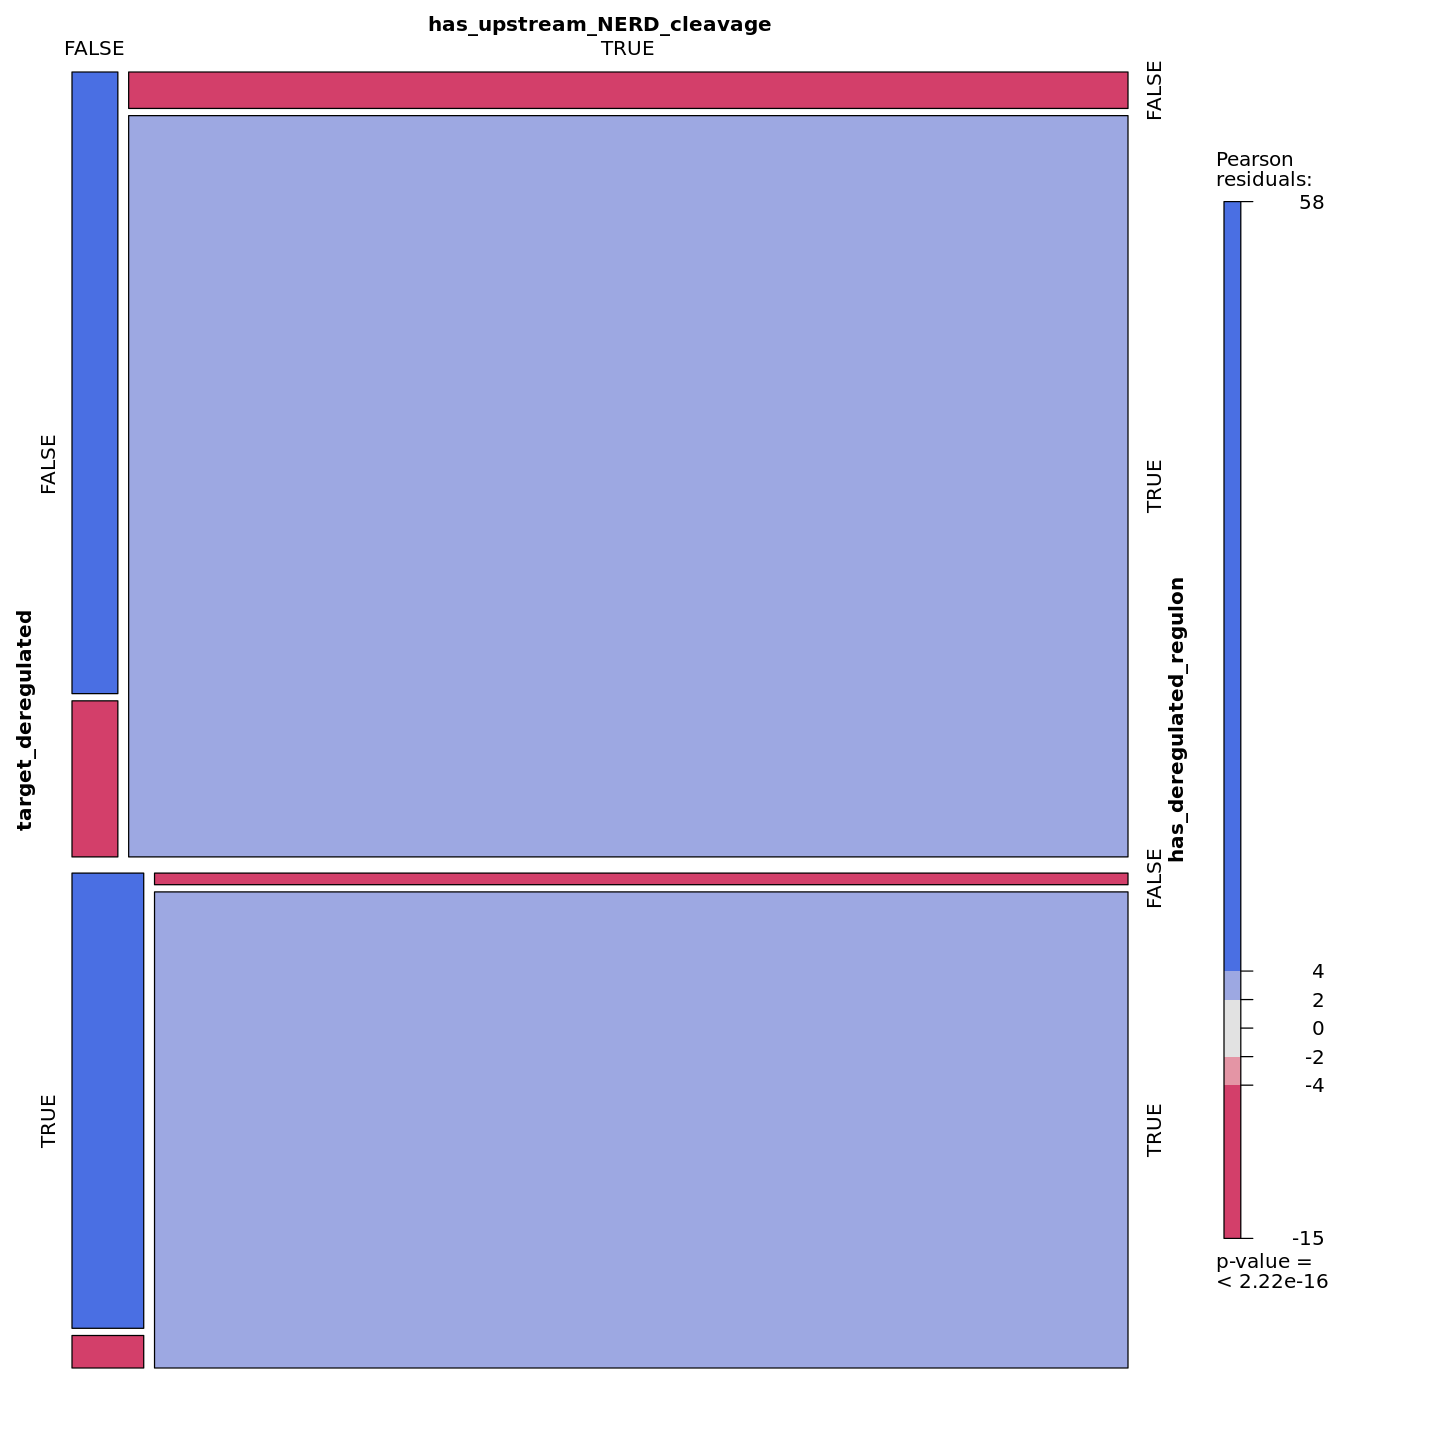

In [71]:
X=data.frame(table(target_deregulated=P3$is_significant,has_upstream_NERD_cleavage=P3$p_direct_targets>0,has_deregulated_regulon=P3$p_dereg_targets>0))
XX=xtabs(Freq~target_deregulated+has_upstream_NERD_cleavage+has_deregulated_regulon,X)
options(repr.plot.width=12, repr.plot.height=12)
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl)#, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 

## Larger upstream regulon (up to order==3)  - >0% direct NERD-DEK1 targets & >5% deregulated TFs

, , has_deregulated_regulon = FALSE

                  has_upstream_NERD_cleavage
target_deregulated FALSE TRUE
             FALSE   237  834
             TRUE    268  303

, , has_deregulated_regulon = TRUE

                  has_upstream_NERD_cleavage
target_deregulated FALSE TRUE
             FALSE    52 5464
             TRUE     17 3565


, , has_deregulated_regulon = FALSE

                  has_upstream_NERD_cleavage
target_deregulated       FALSE        TRUE
             FALSE 0.022067039 0.077653631
             TRUE  0.024953445 0.028212291

, , has_deregulated_regulon = TRUE

                  has_upstream_NERD_cleavage
target_deregulated       FALSE        TRUE
             FALSE 0.004841713 0.508752328
             TRUE  0.001582868 0.331936685


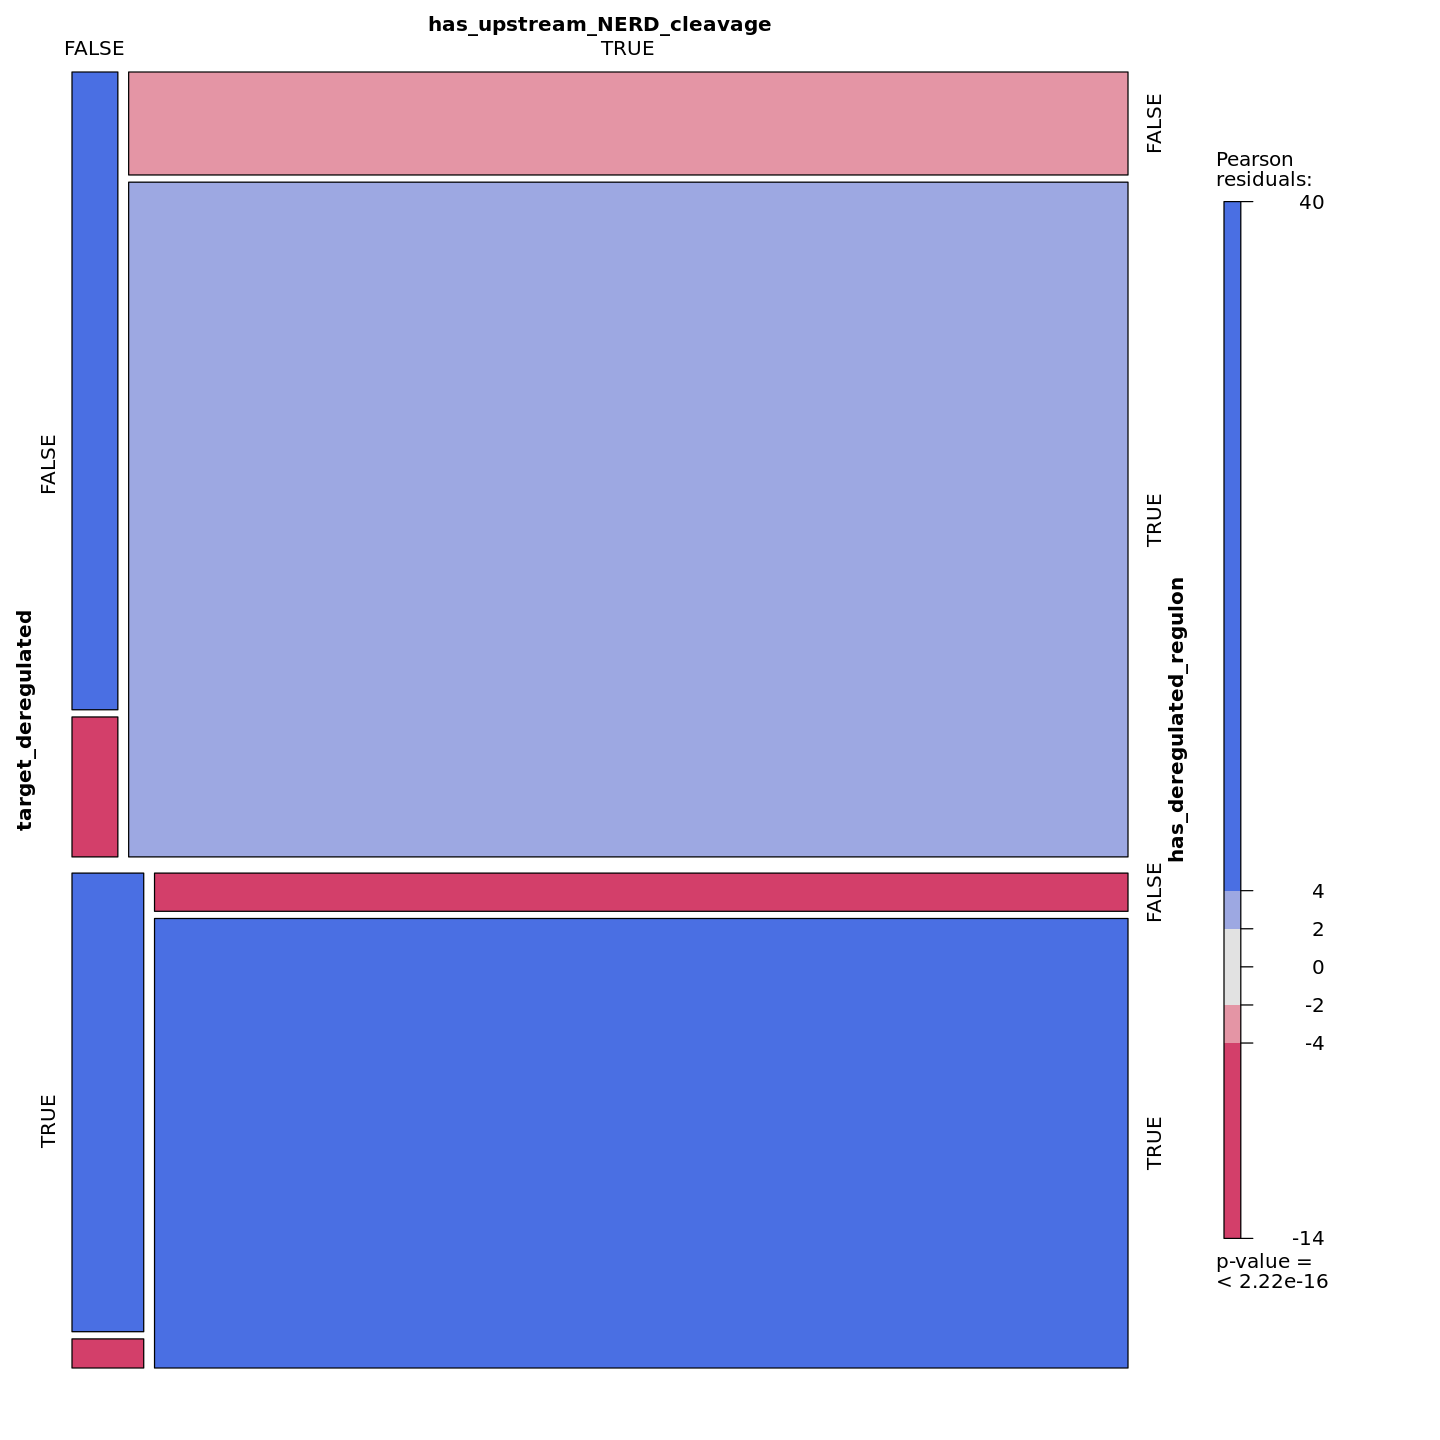

In [72]:
X=table(target_deregulated=P3$is_significant,has_upstream_NERD_cleavage=P3$p_direct_targets>0,has_deregulated_regulon=P3$p_dereg_targets>0.05)
X
prop.table(X)
X=data.frame(X)
XX=xtabs(Freq~target_deregulated+has_upstream_NERD_cleavage+has_deregulated_regulon,X)
options(repr.plot.width=12, repr.plot.height=12)
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl)#, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 

In [73]:
P1=droplevels(subset(PPP,order==1 ))
nrow(PPP)
nrow(P1)

[1] 32220

[1] 10740

## Direct upstream regulon (order==1)  - >0% direct NERD-DEK1 targets & >15% deregulated TFs

, , has_deregulated_regulon = FALSE

                  has_upstream_NERD_cleavage
target_deregulated FALSE TRUE
             FALSE   231  763
             TRUE    266  225

, , has_deregulated_regulon = TRUE

                  has_upstream_NERD_cleavage
target_deregulated FALSE TRUE
             FALSE    58 5535
             TRUE     19 3643


, , has_deregulated_regulon = FALSE

                  has_upstream_NERD_cleavage
target_deregulated       FALSE        TRUE
             FALSE 0.021508380 0.071042831
             TRUE  0.024767225 0.020949721

, , has_deregulated_regulon = TRUE

                  has_upstream_NERD_cleavage
target_deregulated       FALSE        TRUE
             FALSE 0.005400372 0.515363128
             TRUE  0.001769088 0.339199255


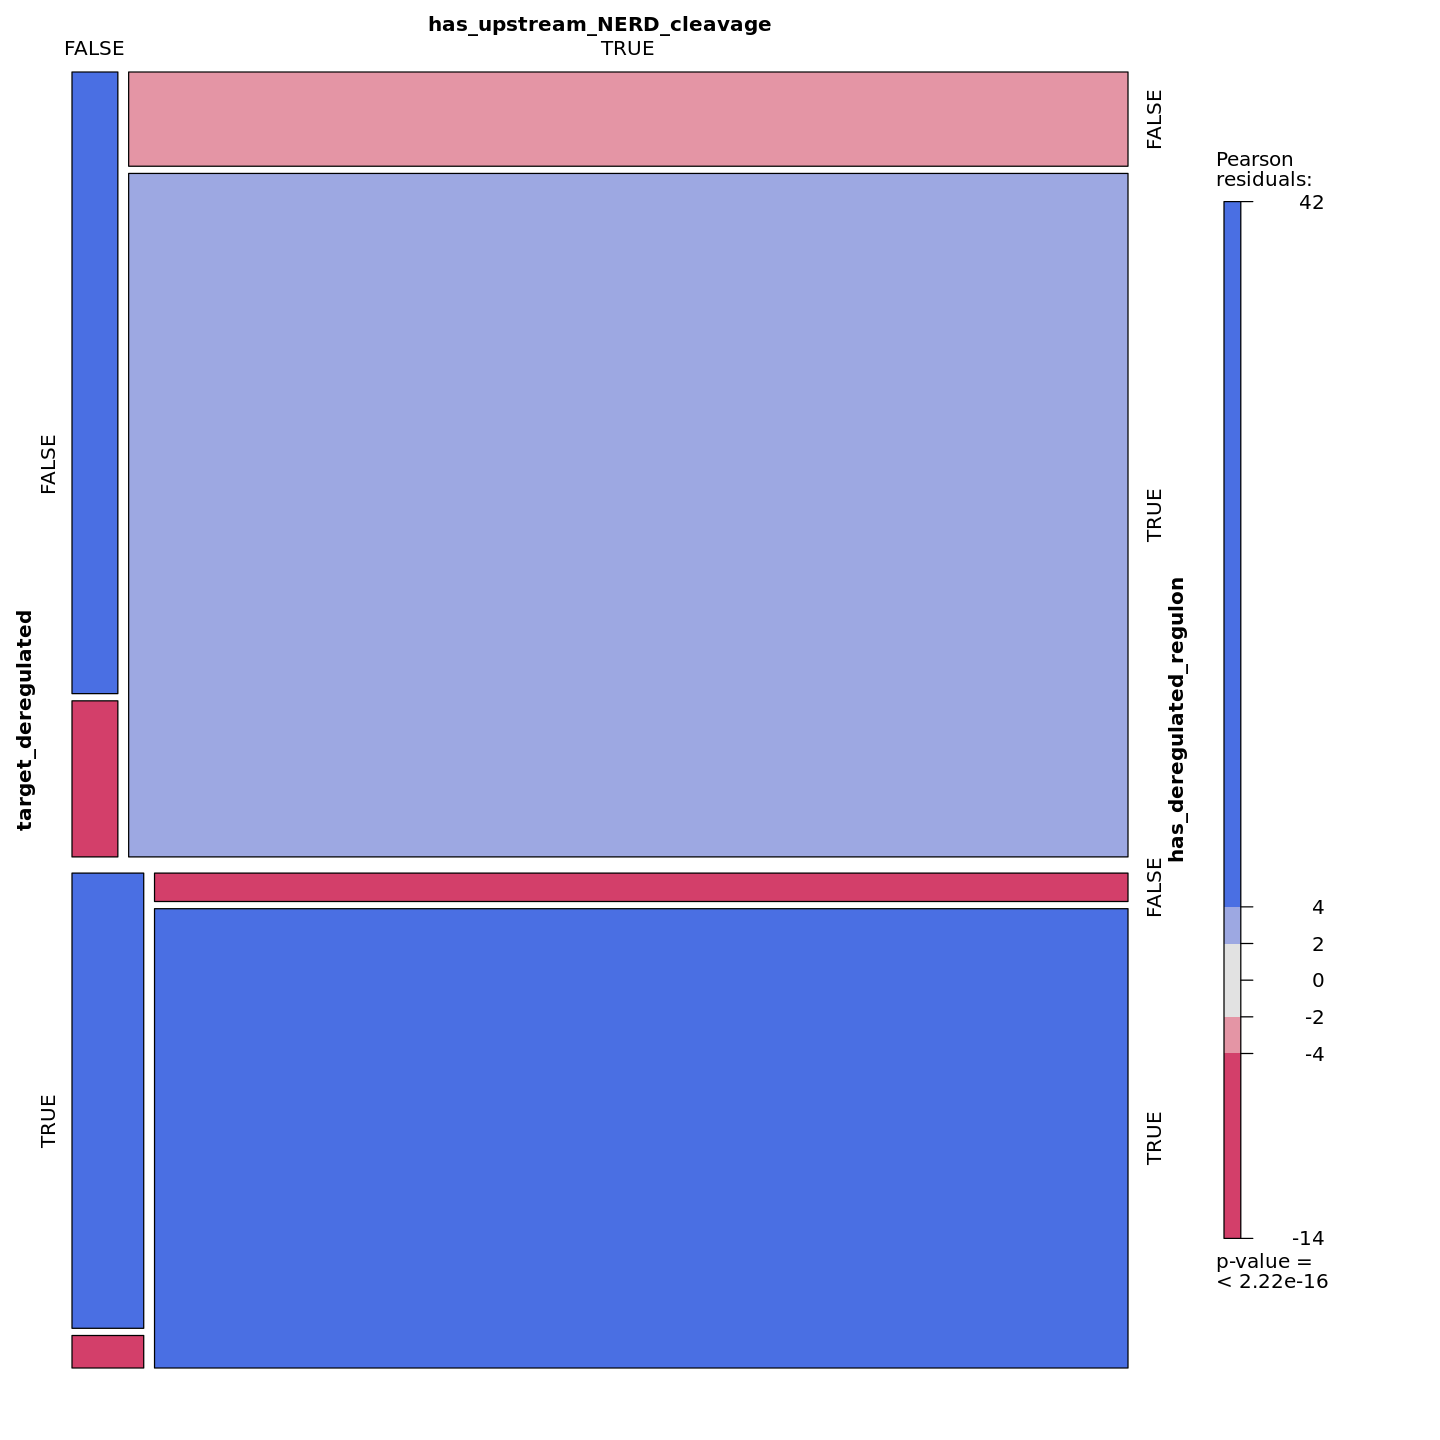

In [74]:
X=table(target_deregulated=P1$is_significant,has_upstream_NERD_cleavage=P1$p_direct_targets>0,has_deregulated_regulon=P1$p_dereg_targets>0.15)
X
prop.table(X)
X=data.frame(X)
XX=xtabs(Freq~target_deregulated+has_upstream_NERD_cleavage+has_deregulated_regulon,X)
options(repr.plot.width=12, repr.plot.height=12)
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl)#, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 

## Deregulated targets - direct upstream regulon (order==1) 

In [75]:
PP1=droplevels(subset(PPP,order==1 & is_significant ==TRUE))
nrow(PPP)
nrow(PP1)

[1] 32220

[1] 4153

In [76]:
PP2=droplevels(subset(PPP,order==2 & is_significant ==TRUE))
nrow(PPP)
nrow(PP2)

[1] 32220

[1] 4153

In [77]:
x=cut(PP1$p_dereg_targets[PP1$p_dereg_targets>0],breaks=seq(min(PP1$p_dereg_targets[PP1$p_dereg_targets>0]),1,by=.5),right=TRUE,include.lowest=TRUE,dig.lab=1,ordered.result=TRUE)
PP1$p_dereg_cut=ordered(ifelse(PP1$p_dereg_targets>0,as.character(x),"0"),levels=c(0,levels(x)))
x=cut(PP1$p_direct_targets[PP1$p_direct_targets>0],breaks=seq(min(PP1$p_direct_targets[PP1$p_direct_targets>0]),1,by=.5),right=TRUE,include.lowest=TRUE,dig.lab=1,ordered.result=TRUE)
PP1$p_direct_cut=ordered(ifelse(PP1$p_direct_targets>0,as.character(x),"0"),levels=c(0,levels(x)))

In [78]:
x=cut(PP2$p_dereg_targets[PP2$p_dereg_targets>0],breaks=seq(min(PP2$p_dereg_targets[PP2$p_dereg_targets>0]),1,by=.5),right=TRUE,include.lowest=TRUE,dig.lab=1,ordered.result=TRUE)
PP2$p_dereg_cut=ordered(ifelse(PP2$p_dereg_targets>0,as.character(x),"0"),levels=c(0,levels(x)))
x=cut(PP2$p_direct_targets[PP2$p_direct_targets>0],breaks=seq(min(PP2$p_direct_targets[PP2$p_direct_targets>0]),1,by=.5),right=TRUE,include.lowest=TRUE,dig.lab=1,ordered.result=TRUE)
PP2$p_direct_cut=ordered(ifelse(PP2$p_direct_targets>0,as.character(x),"0"),levels=c(0,levels(x)))

                      upstream_deregulation
upstream_NERD_cleavage   0 [0.1,0.6]
             0         266        10
             [0.1,0.6]  35       941

                      upstream_deregulation
upstream_NERD_cleavage          0  [0.1,0.6]
             0         0.21246006 0.00798722
             [0.1,0.6] 0.02795527 0.75159744

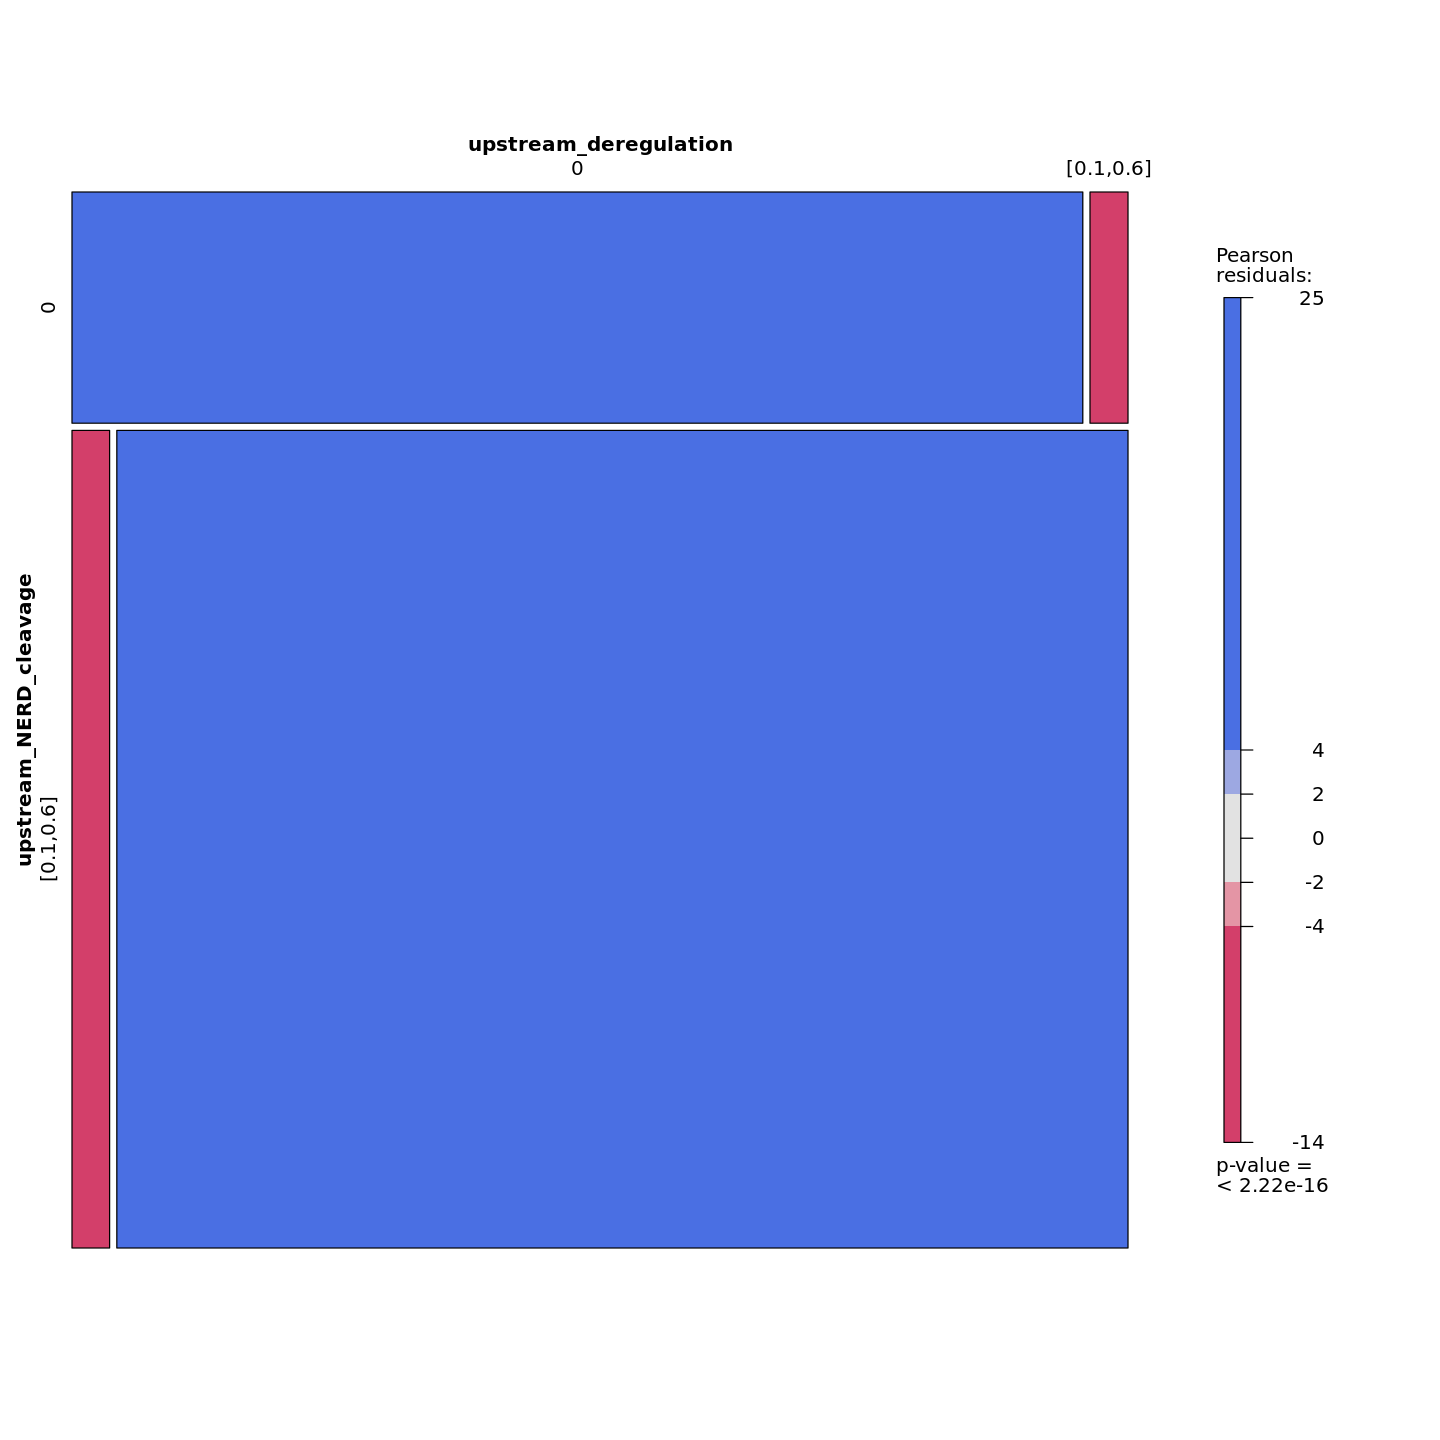

In [79]:
X=table(upstream_NERD_cleavage=PP1$p_direct_cut,upstream_deregulation=PP1$p_dereg_cut)
X
prop.table(X)
X=data.frame(X)
XX=xtabs(Freq~upstream_NERD_cleavage+upstream_deregulation,X)
options(repr.plot.width=12, repr.plot.height=12)
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl)#, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 

## Deregulated targets - direct upstream regulon (up to order==3) 

In [80]:
PP3=droplevels(subset(PPP,order==3 & is_significant ==TRUE ))
nrow(PPP)
nrow(PP3)

[1] 32220

[1] 4153

In [81]:
x=cut(PP3$p_dereg_targets[PP3$p_dereg_targets>0],breaks=seq(min(PP3$p_dereg_targets[PP3$p_dereg_targets>0]),1,by=.5),right=TRUE,include.lowest=TRUE,dig.lab=1,ordered.result=TRUE)
PP3$p_dereg_cut=ordered(ifelse(PP3$p_dereg_targets>0,as.character(x),"0"),levels=c(0,levels(x)))
x=cut(PP3$p_direct_targets[PP3$p_direct_targets>0],breaks=seq(min(PP3$p_direct_targets[PP3$p_direct_targets>0]),1,by=.5),right=TRUE,include.lowest=TRUE,dig.lab=1,ordered.result=TRUE)
PP3$p_direct_cut=ordered(ifelse(PP3$p_direct_targets>0,as.character(x),"0"),levels=c(0,levels(x)))

                      upstream_deregulation
upstream_NERD_cleavage    0 [0.008,0.5]
           0            266          19
           [0.009,0.5]   58        2197

                      upstream_deregulation
upstream_NERD_cleavage           0 [0.008,0.5]
           0           0.104724409 0.007480315
           [0.009,0.5] 0.022834646 0.864960630

png 
  2

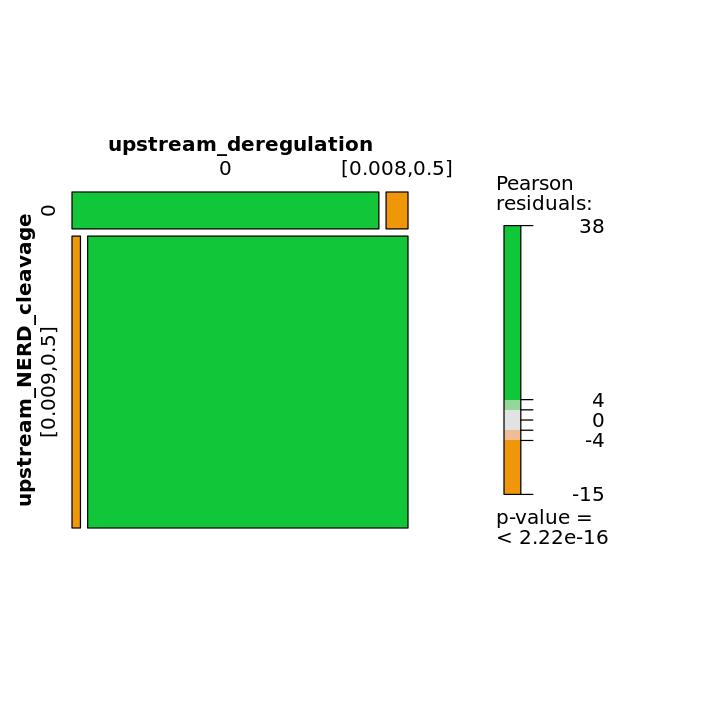

In [82]:
X=table(upstream_NERD_cleavage=PP3$p_direct_cut,upstream_deregulation=PP3$p_dereg_cut)
X
prop.table(X)
X=data.frame(X)
XX=xtabs(Freq~upstream_NERD_cleavage+upstream_deregulation,X)
options(repr.plot.width=6, repr.plot.height=6)
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 
pdf("chisq_test.impact.upstream_deregulation.deregulated_targets.II_V_X.pdf",width=6,height=6)
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 
dev.off()

                      upstream_deregulation
upstream_NERD_cleavage    0 [0.008,0.5]
           0            266          19
           [0.009,0.5]   58        2197

                      upstream_deregulation
upstream_NERD_cleavage           0 [0.008,0.5]
           0           0.104724409 0.007480315
           [0.009,0.5] 0.022834646 0.864960630

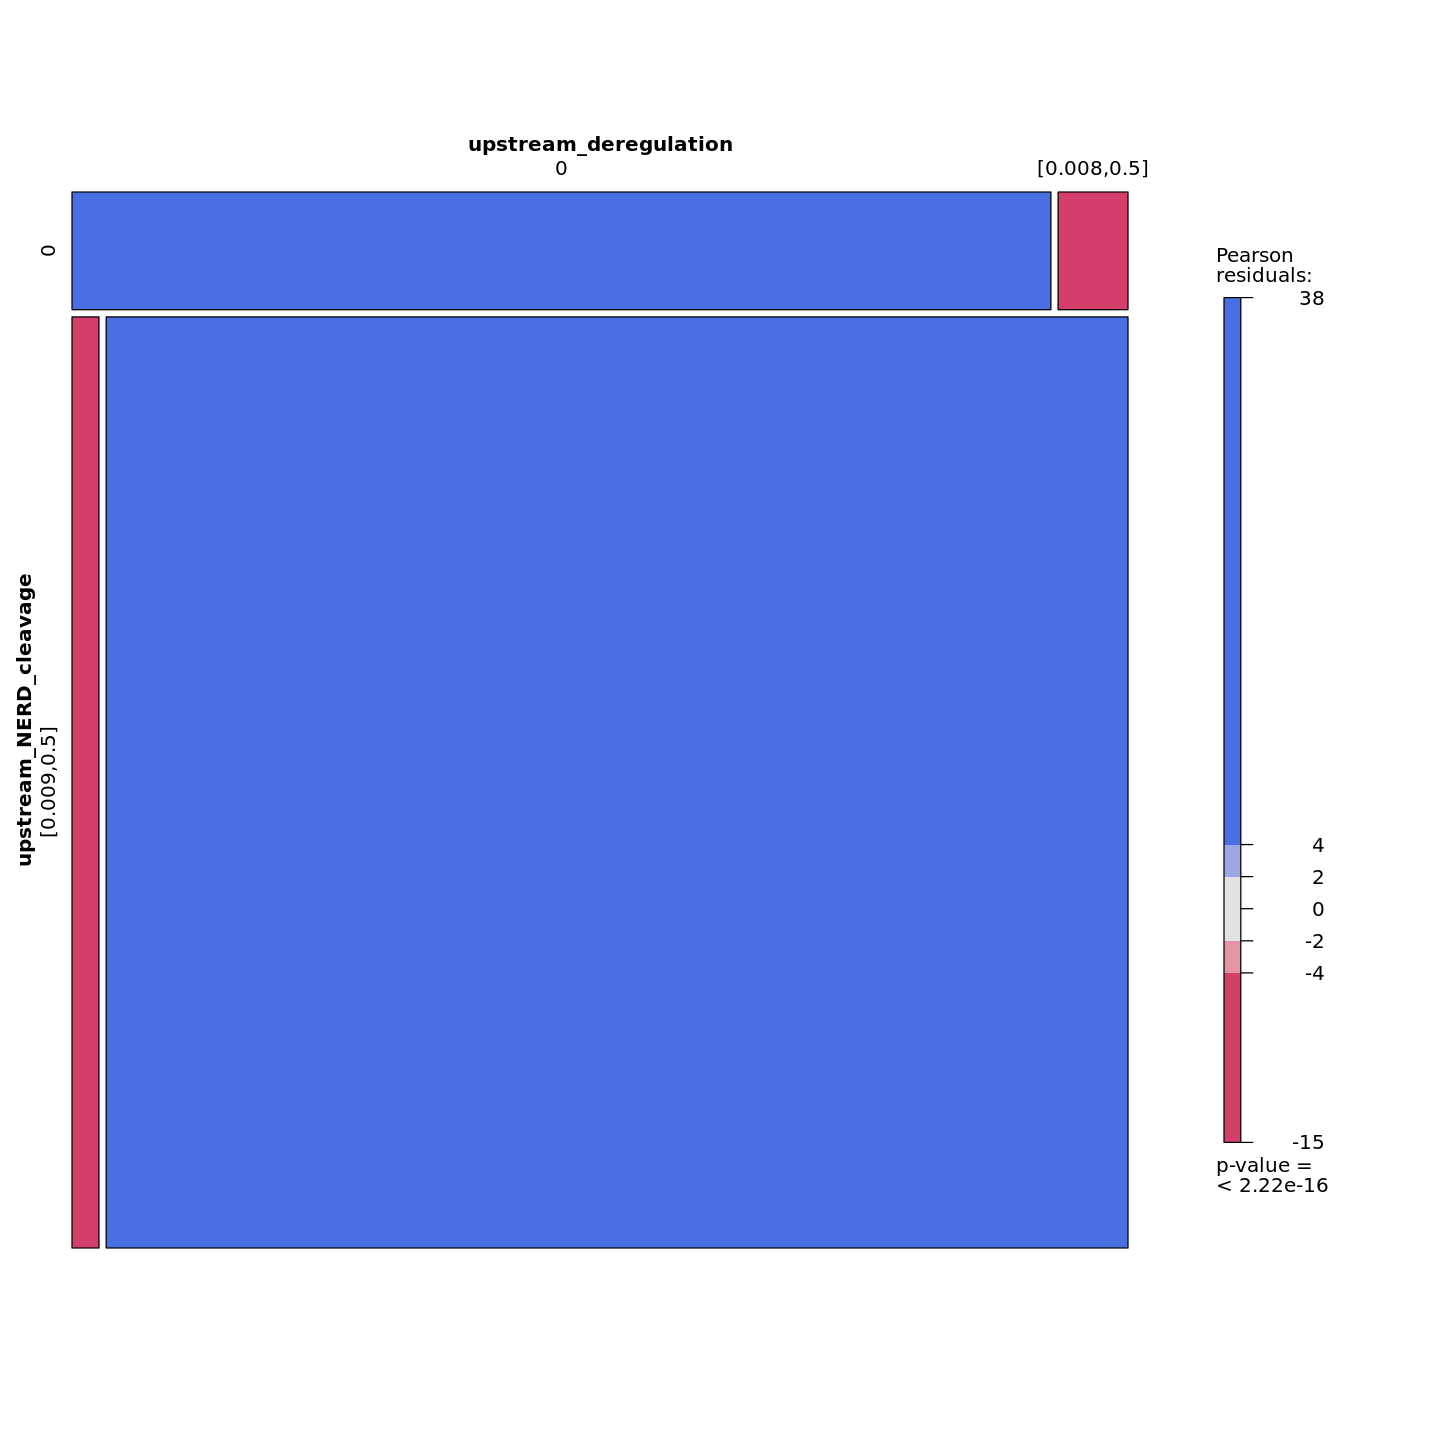

In [83]:
X=table(upstream_NERD_cleavage=PP3$p_direct_cut,upstream_deregulation=PP3$p_dereg_cut)
X
prop.table(X)
X=data.frame(X)
XX=xtabs(Freq~upstream_NERD_cleavage+upstream_deregulation,X)
options(repr.plot.width=12, repr.plot.height=12)
mosaic(XX, shade=TRUE, clegend=TRUE,legend_width=10,gp =shading_hcl)#, gp_args = list(h = c(130, 43), c = 100, l = c(90, 70))) 

In [84]:
info=function(ds) {
    X=ds %>% summarise(
        p_all_targets=summary(p_all_targets), 
        p_direct_targets=summary(p_direct_targets), 
        p_dereg_targets=summary(p_dereg_targets), 
                ) %>%
        t()  

    colnames(X)=names(summary(ds$p_all_targets))
    X
    }

In [85]:
info(PP1)

Min. 1st Qu.   Median    Mean      3rd Qu.   Max.
p_all_targets    0    0.7500000 0.8571429 0.7988925 1.0000000 1   
p_direct_targets 0    0.5000000 0.6666667 0.6346882 0.8000000 1   
p_dereg_targets  0    0.3333333 0.5000000 0.4982508 0.6666667 1

In [86]:
info(PP2)

Min. 1st Qu.   Median    Mean      3rd Qu.   Max.
p_all_targets    0    0.5833333 0.7187500 0.6709239 0.8301887 1   
p_direct_targets 0    0.3793103 0.5161290 0.4880579 0.6333333 1   
p_dereg_targets  0    0.2000000 0.3333333 0.3306871 0.4666667 1

In [87]:
info(PP3)

Min. 1st Qu.   Median    Mean      3rd Qu.   Max.
p_all_targets    0    0.5205479 0.6400000 0.5940752 0.7378049 1   
p_direct_targets 0    0.3157895 0.4579439 0.4165386 0.5483871 1   
p_dereg_targets  0    0.1311475 0.2235294 0.2283374 0.3157895 1

In [88]:
prop.table(table(PPP$order, sig=PPP$is_significant, dereg=PPP$p_dereg_targets>0.1),1)

, , dereg = FALSE

   sig
         FALSE       TRUE
  1 0.05344507 0.03398510
  2 0.11154562 0.05363128
  3 0.16582868 0.07849162

, , dereg = TRUE

   sig
         FALSE       TRUE
  1 0.55986965 0.35270019
  2 0.50176909 0.33305400
  3 0.44748603 0.30819367


In [89]:
prop.table(table(PP1$p_dereg_targets>0.05))
prop.table(table(PP2$p_dereg_targets>0.05))
prop.table(table(PP3$p_dereg_targets>0.05))


     FALSE       TRUE 
0.08620275 0.91379725 


     FALSE       TRUE 
0.09776065 0.90223935 


   FALSE     TRUE 
0.137491 0.862509 

In [90]:
prop.table(table(PP1$p_direct_targets>0.05))
prop.table(table(PP2$p_direct_targets>0.05))
prop.table(table(PP3$p_direct_targets>0.05))


     FALSE       TRUE 
0.06862509 0.93137491 


    FALSE      TRUE 
0.0707922 0.9292078 


    FALSE      TRUE 
0.0825909 0.9174091 

In [91]:
prop.table(table(PP1$p_all_targets>0.05))
prop.table(table(PP2$p_all_targets>0.05))
prop.table(table(PP3$p_all_targets>0.05))


     FALSE       TRUE 
0.06405008 0.93594992 


     FALSE       TRUE 
0.06429087 0.93570913 


     FALSE       TRUE 
0.06790272 0.93209728 

In [92]:
plot_trend=function(ds,tit,method="lm",max=100) {
ds %>% filter(community %in% subnetworks) %>%  
    select(geneid, effect_size,p_all_targets, p_dereg_targets,p_direct_targets) %>% 
    mutate_if(str_detect(names(.),"p_"),function(x) x*100) %>%
    rename ("direct or indirect"="p_all_targets","direct"="p_direct_targets","indirect"="p_dereg_targets") %>% 
    pivot_longer(-c(geneid,effect_size),names_to="targeting_type",values_to="percent_regulon") %>%
    ggplot(aes(x=percent_regulon,y=effect_size,colour=targeting_type)) +
              scale_colour_manual(name="DEK1 targeting of upstream TFs", values=c("#3165a8","#00be38","#fb776e")) +
              geom_smooth(method=method) +
              xlab("% upstream regulon") +
              ylab("deregulation in mutants")+
              xlim(0,max) +
              ggtitle(tit)
}

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'

`geom_smooth()` using formula 'y ~ s(x, bs = "cs")'



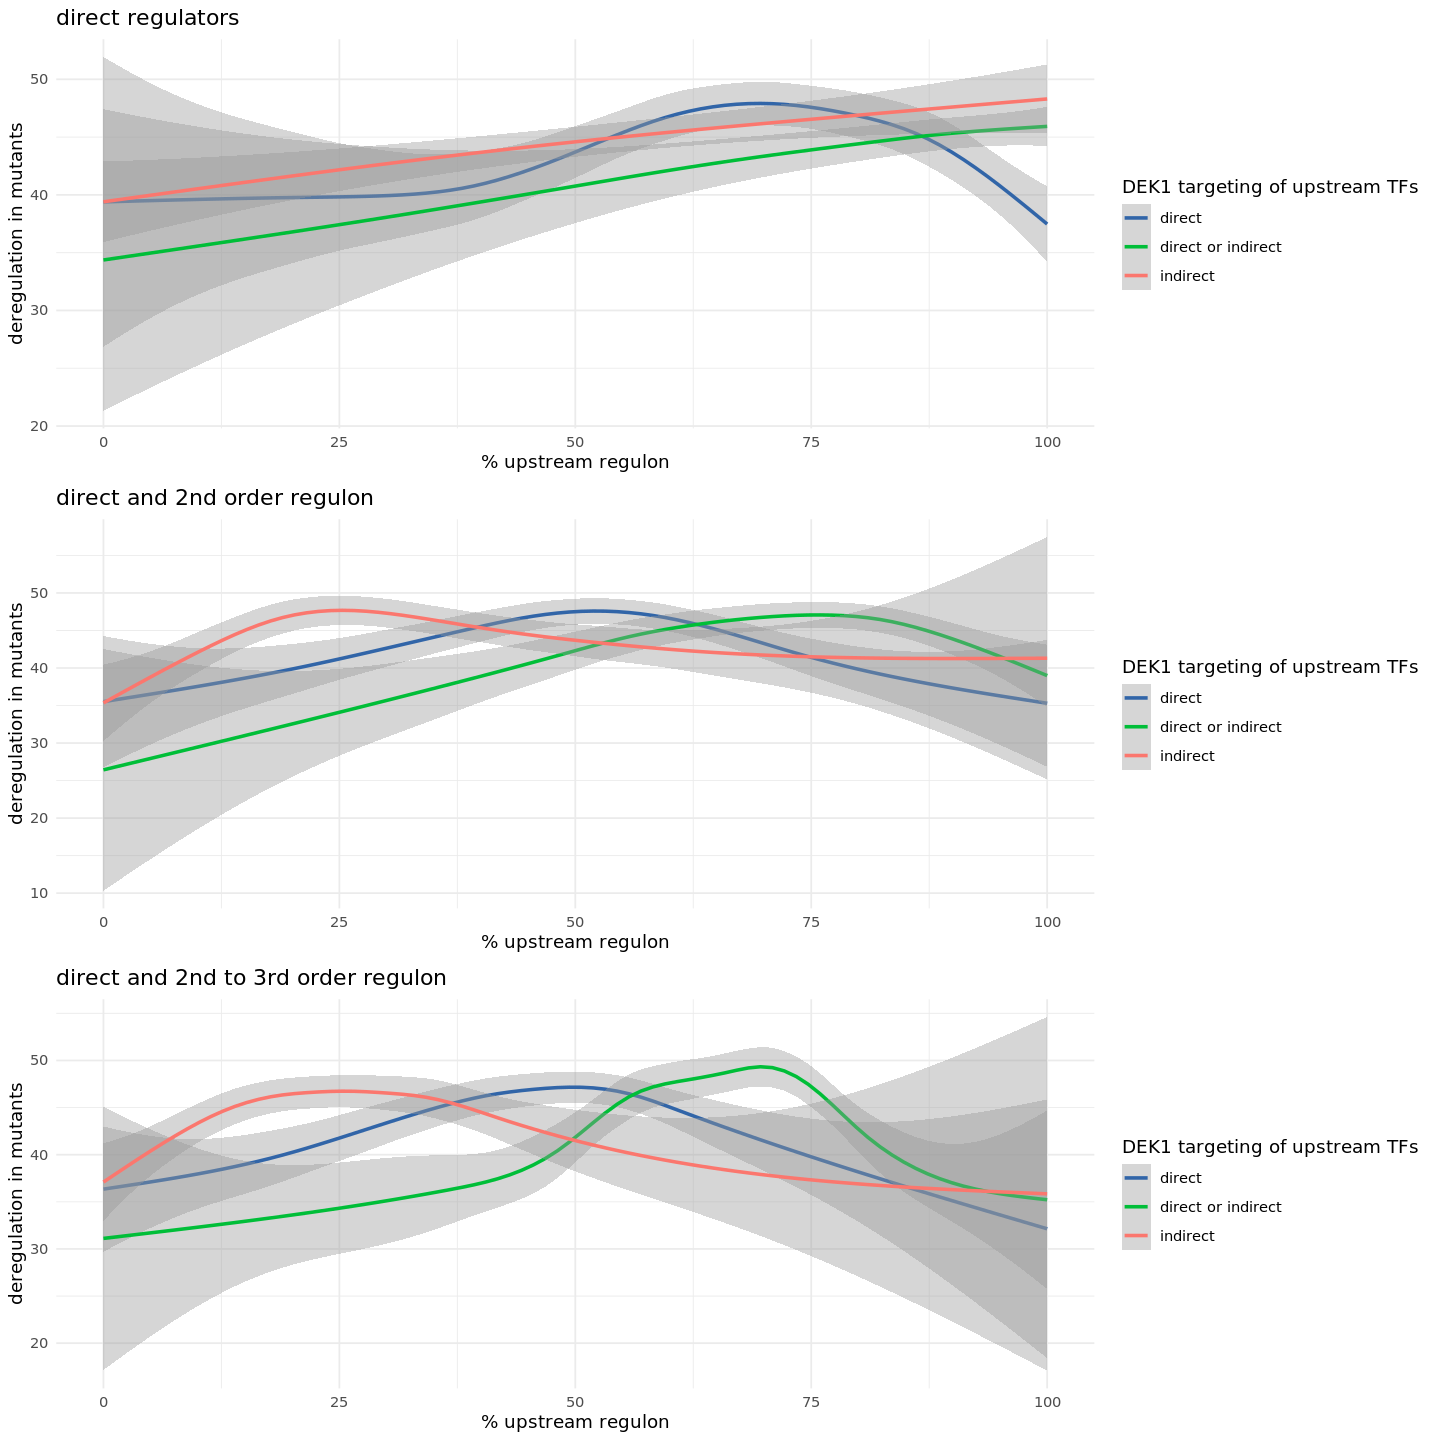

In [93]:
p1=plot_trend(PP1,"direct regulators","gam")
p2=plot_trend(PP2,"direct and 2nd order regulon","gam")
p3=plot_trend(PP3,"direct and 2nd to 3rd order regulon","gam")

grid.arrange(p1, p2,p3, nrow = 3)
              

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



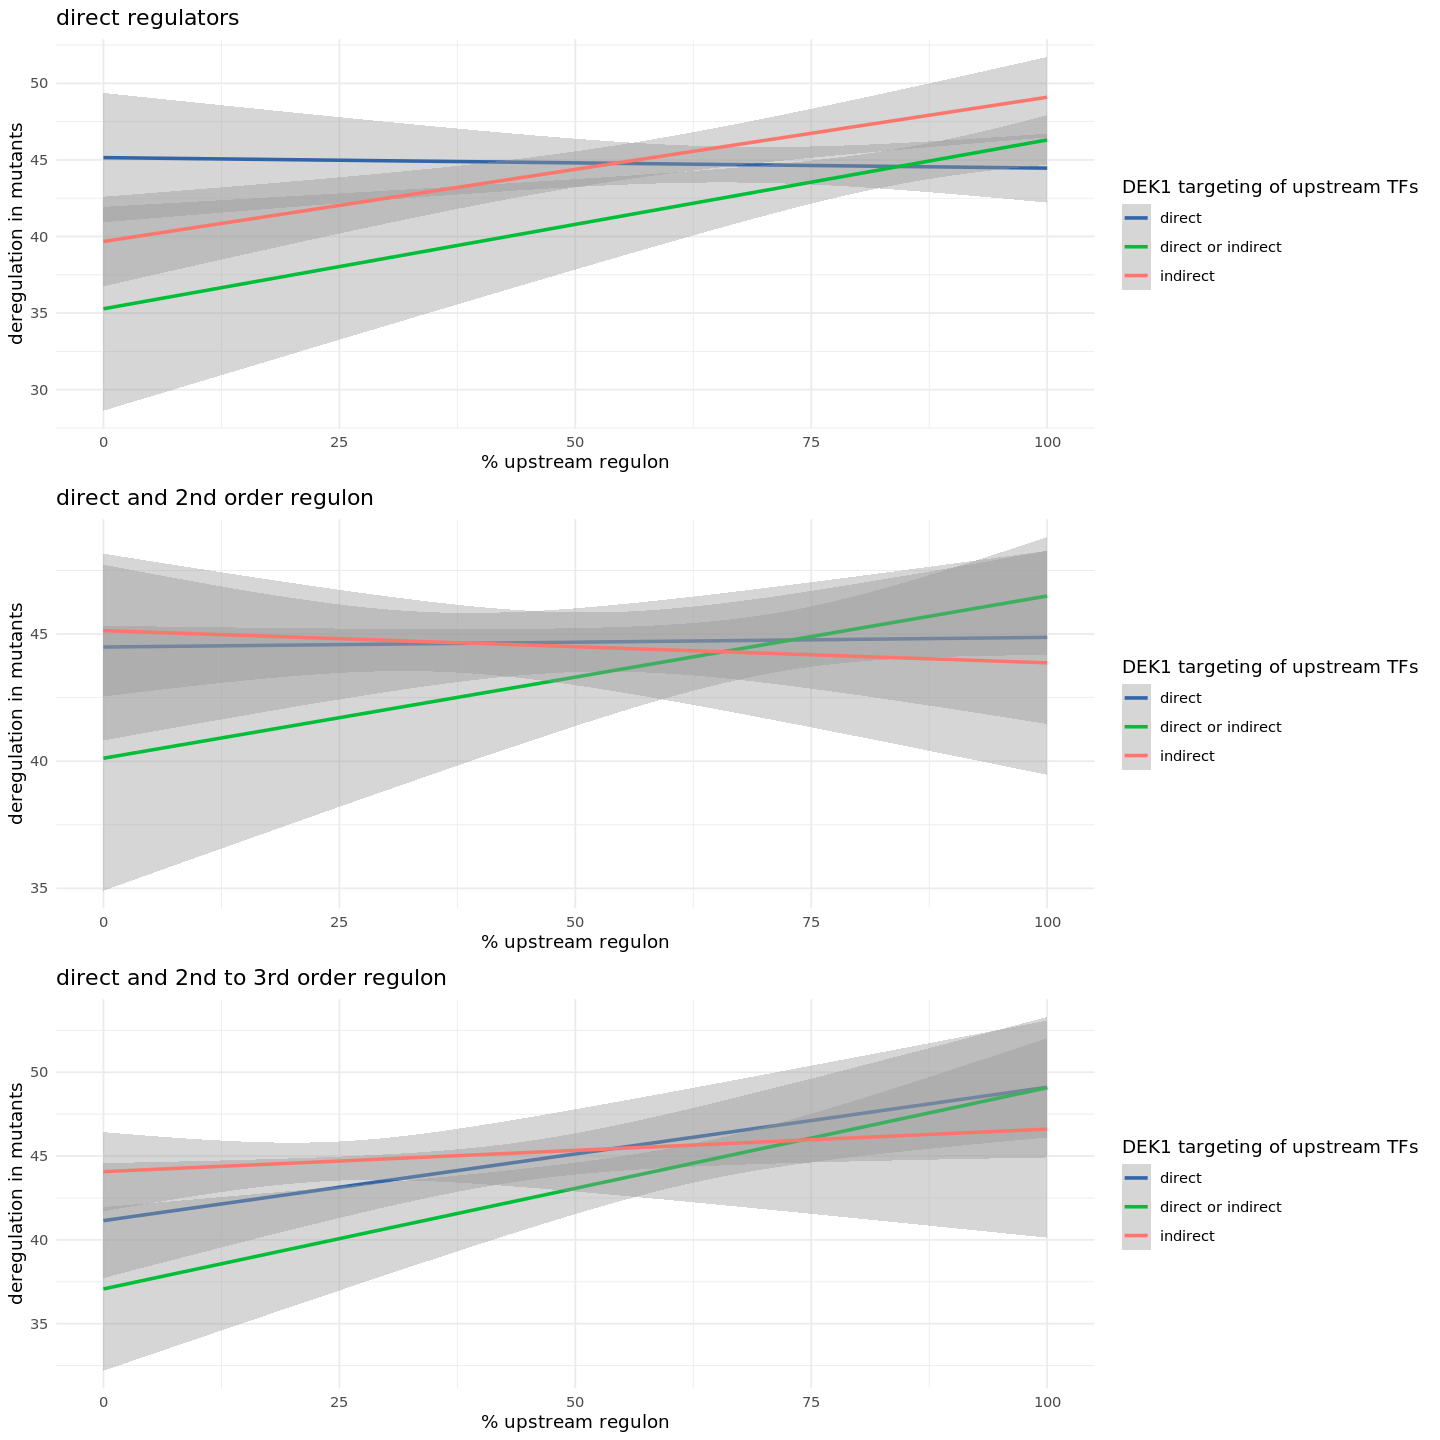

In [94]:
p1=plot_trend(PP1,"direct regulators")
p2=plot_trend(PP2,"direct and 2nd order regulon")
p3=plot_trend(PP3,"direct and 2nd to 3rd order regulon")

grid.arrange(p1, p2,p3, nrow = 3)
              

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



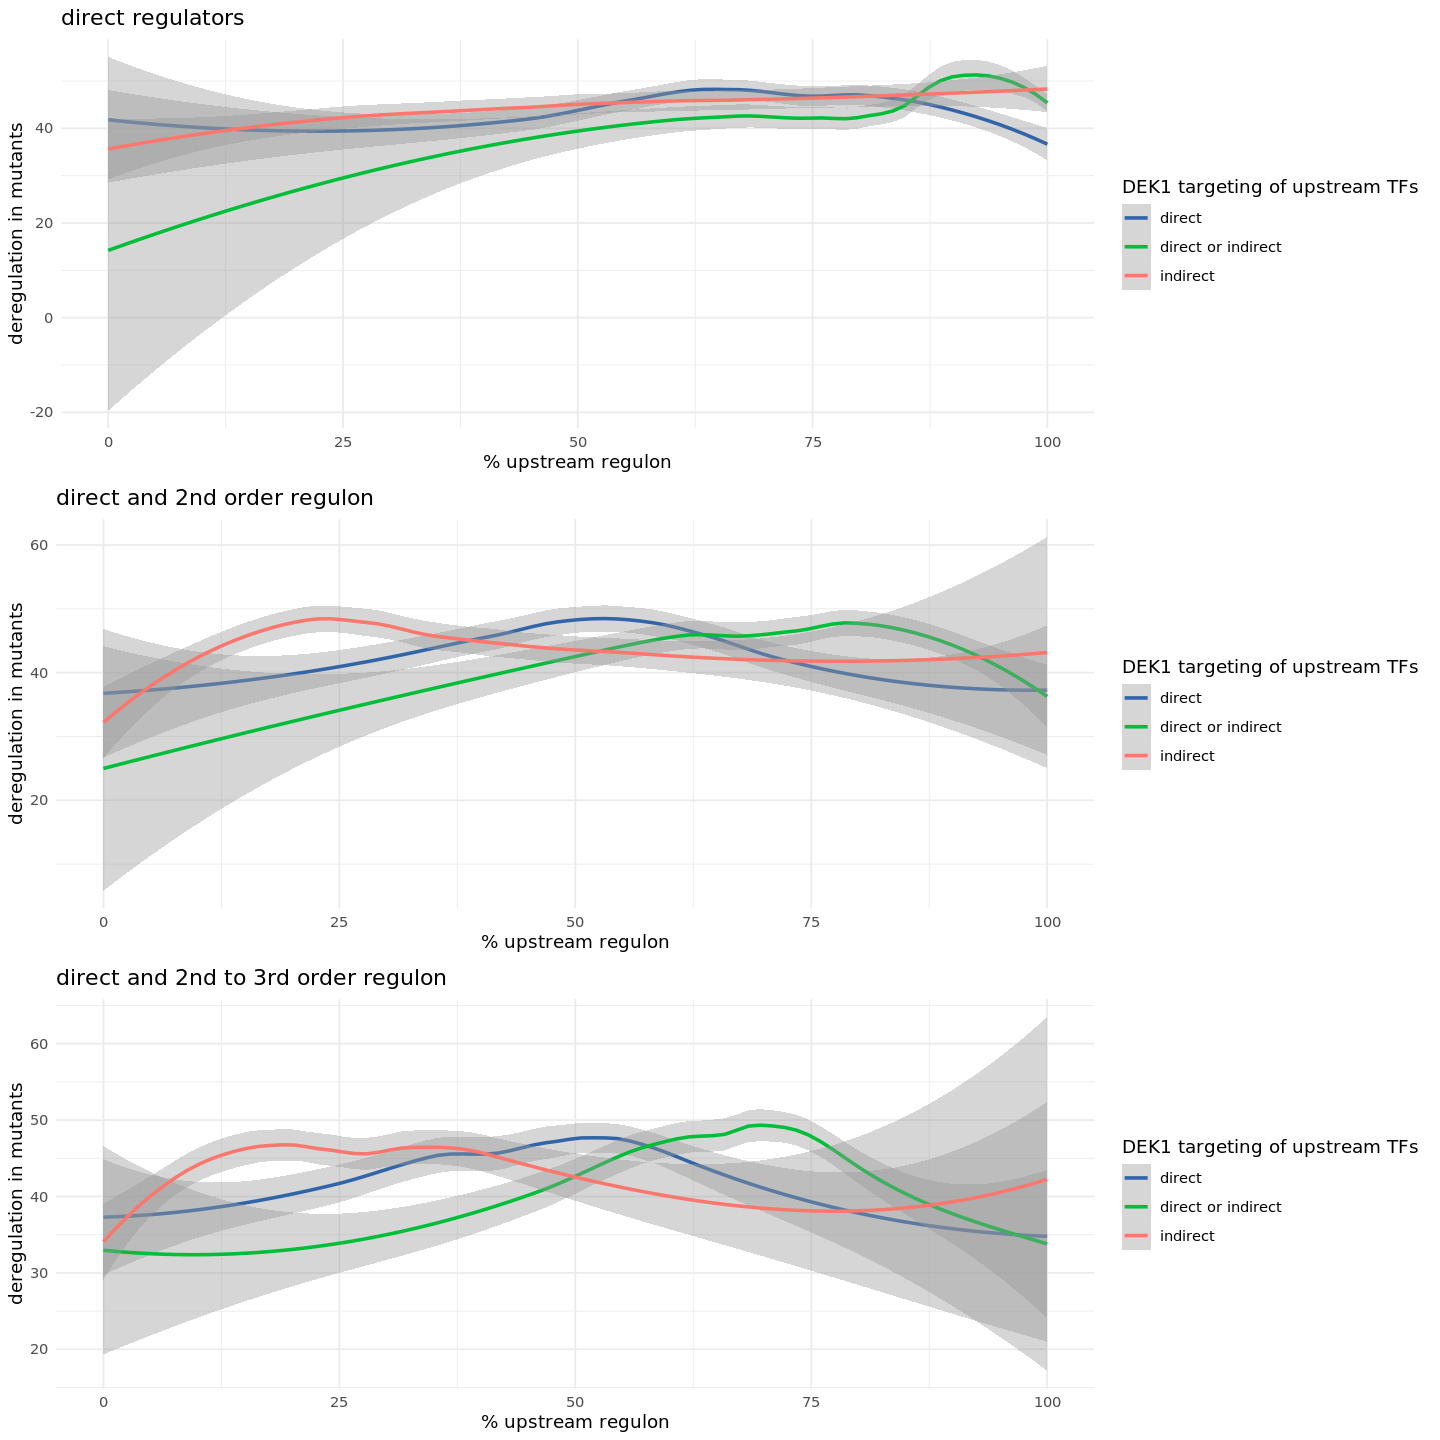

In [95]:
p1=plot_trend(PP1,"direct regulators","loess")
p2=plot_trend(PP2,"direct and 2nd order regulon","loess")
p3=plot_trend(PP3,"direct and 2nd to 3rd order regulon","loess")

grid.arrange(p1, p2,p3, nrow = 3)
              

`geom_smooth()` using formula 'y ~ x'



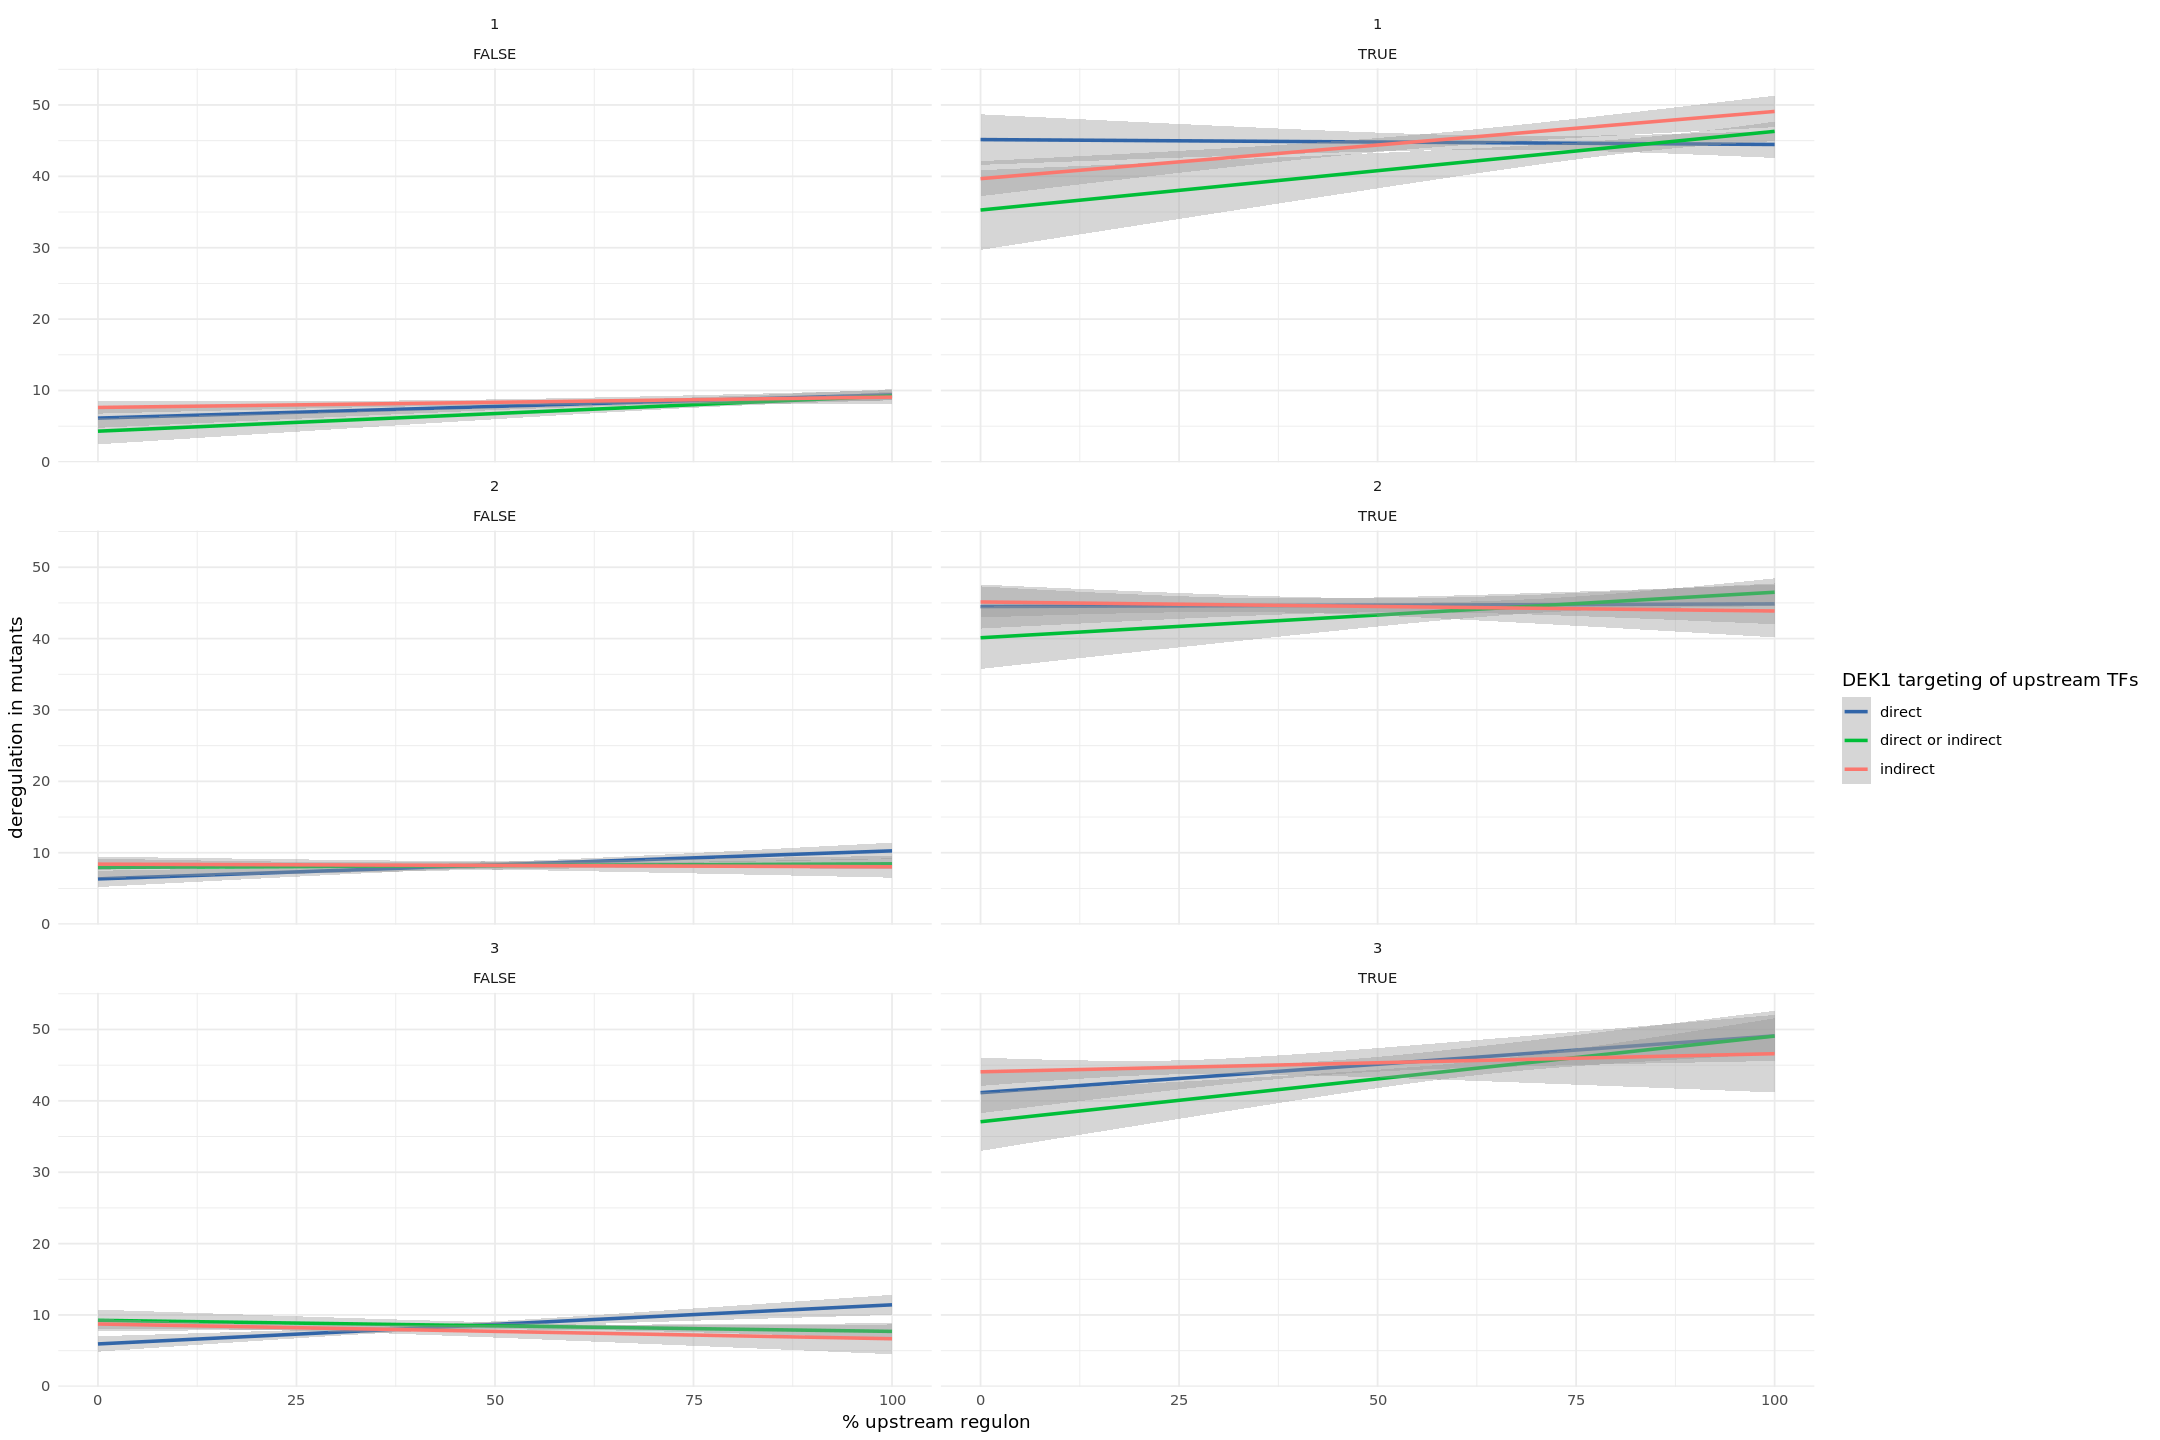

In [96]:

options(repr.plot.width=18, repr.plot.height=12)
max=100
method="glm"
PPP %>% filter(community %in% subnetworks) %>%  
    select(geneid, order, is_significant, effect_size,p_all_targets, p_dereg_targets,p_direct_targets) %>% 
    mutate_if(str_detect(names(.),"p_"),function(x) x*100) %>%
    rename ("direct or indirect"="p_all_targets","direct"="p_direct_targets","indirect"="p_dereg_targets") %>% 
    pivot_longer(-c(geneid,effect_size,is_significant,order),names_to="targeting_type",values_to="percent_regulon") %>%
    ggplot(aes(x=percent_regulon,y=effect_size,colour=targeting_type)) +
              scale_colour_manual(name="DEK1 targeting of upstream TFs", values=c("#3165a8","#00be38","#fb776e")) +
              geom_smooth(method=method,level = 0.9) +
              facet_wrap(order~is_significant,ncol=2) +
              xlab("% upstream regulon") +
              ylab("deregulation in mutants")+
              xlim(0,max) 

In [111]:
cr=function(ds,target,method="kendall") print(cor.test(ds[[target]],ds[["effect_size"]],method=method))
cr(PP1,"p_direct_targets")
cr(PP1,"p_dereg_targets")
cr(PP1,"p_all_targets")


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 2.8141, p-value = 0.004892
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.03006188 


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 3.5203, p-value = 0.000431
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.03744377 


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 3.3523, p-value = 0.0008015
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.03707847 



In [98]:
cr=function(ds,target,method="kendall") print(cor.test(ds[[target]],ds[["effect_size"]],method=method))
cr(PP2,"p_direct_targets")
cr(PP2,"p_dereg_targets")
cr(PP2,"p_all_targets")


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 3.5995, p-value = 0.0003188
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.03747819 


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 1.5479, p-value = 0.1216
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.01612583 


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 2.3926, p-value = 0.01673
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.02490562 



In [99]:
cr=function(ds,target,method="kendall") print(cor.test(ds[[target]],ds[["effect_size"]],method=method))
cr(PP3,"p_direct_targets")
cr(PP3,"p_dereg_targets")
cr(PP3,"p_all_targets")


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 5.8752, p-value = 4.224e-09
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.06100664 


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 3.0047, p-value = 0.002658
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.03123494 


	Kendall's rank correlation tau

data:  ds[[target]] and ds[["effect_size"]]
z = 4.0691, p-value = 4.719e-05
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.04224417 



In [100]:
summary(step(glm(effect_size~p_direct_targets+p_dereg_targets+p_all_targets,data=subset(PP3,community %in% subnetworks))))

Start:  AIC=39123.39
effect_size ~ p_direct_targets + p_dereg_targets + p_all_targets

                   Df Deviance   AIC
- p_direct_targets  1  5311958 39121
- p_dereg_targets   1  5313677 39123
<none>                 5311956 39123
- p_all_targets     1  5320881 39128

Step:  AIC=39121.39
effect_size ~ p_dereg_targets + p_all_targets

                  Df Deviance   AIC
- p_dereg_targets  1  5313920 39121
<none>                5311958 39121
- p_all_targets    1  5327001 39130

Step:  AIC=39120.82
effect_size ~ p_all_targets

                Df Deviance   AIC
<none>              5313920 39121
- p_all_targets  1  5327479 39129



Call:
glm(formula = effect_size ~ p_all_targets, data = subset(PP3, 
    community %in% subnetworks))

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-42.00  -24.26  -13.94   11.98  342.80  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)     37.074      2.489  14.895  < 2e-16 ***
p_all_targets   12.001      3.810   3.149  0.00165 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 1367.101)

    Null deviance: 5327479  on 3888  degrees of freedom
Residual deviance: 5313920  on 3887  degrees of freedom
AIC: 39121

Number of Fisher Scoring iterations: 2


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



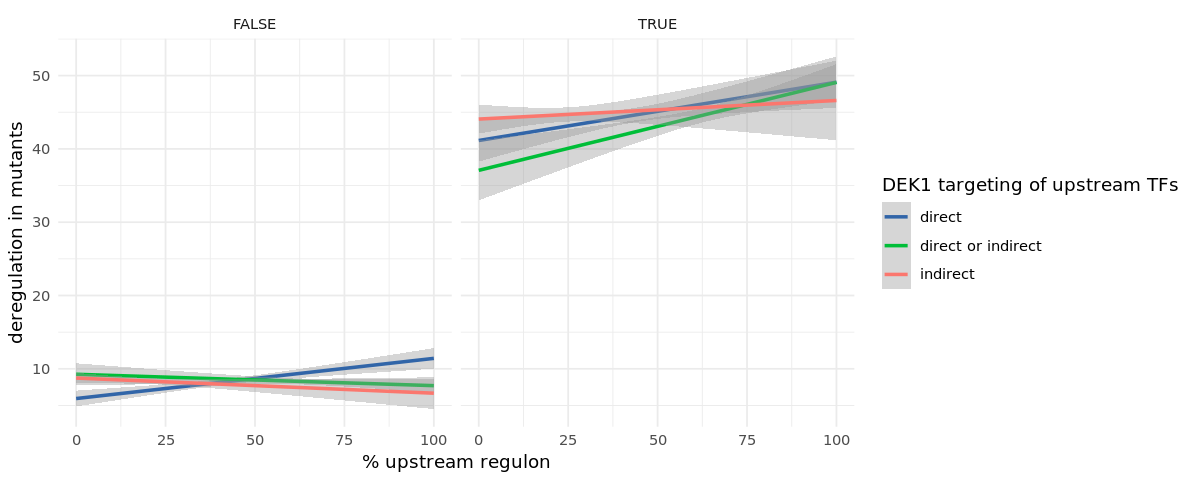

In [101]:
options(repr.plot.width=10, repr.plot.height=4)
g=PPP %>% filter(community %in% subnetworks & order == 3) %>%  
    select(geneid, order, is_significant, effect_size,p_all_targets, p_dereg_targets,p_direct_targets) %>% 
    mutate_if(str_detect(names(.),"p_"),function(x) x*100) %>%
    rename ("direct or indirect"="p_all_targets","direct"="p_direct_targets","indirect"="p_dereg_targets") %>% 
    pivot_longer(-c(geneid,effect_size,is_significant,order),names_to="targeting_type",values_to="percent_regulon") %>%
    ggplot(aes(x=percent_regulon,y=effect_size,colour=targeting_type)) +
              scale_colour_manual(name="DEK1 targeting of upstream TFs", values=c("#3165a8","#00be38","#fb776e")) +
              geom_smooth(method="glm",level = 0.9) +
              facet_wrap(~is_significant,ncol=2) +
              xlab("% upstream regulon") +
              ylab("deregulation in mutants")
g
ggsave(g,filename="dependency.target_effect_size.3rd_order_deregulation.II_V_X.pdf",width=10,height=4)

### Target ~ TF deregulation

In [102]:
head(a)

regulatoryGene   targetGene                 full_cor   full_reg our_cor      
1 Pp3c4_31920.mRNA Pp3c13_21080.mRNA           0.1577695 +        -4.337281e-16
2 Pp3c4_350.mRNA   Pp3c3_28370.C_D_box_snoRNA  1.0000000 +         1.000000e+00
3 Pp3c12_10.mRNA   Pp3c1_12760.mRNA           -0.1279099 -         1.873743e-15
4 Pp3c1_21610.mRNA Pp3s178_40.mRNA             0.2570535 +         2.713689e-16
5 Pp3c1_32440.mRNA Pp3c7_19620.mRNA            0.7938397 +         6.887235e-01
6 Pp3c2_9700.mRNA  Pp3c5_14180.mRNA            0.1967969 +        -2.155251e-15
  our_reg weight     regulator_rank target_rank mutual_rank regulator_community
1 -       0.06337407 1              1           1           II                 
2 +       0.05976139 1              1           1           II                 
3 +       0.05927444 1              1           1           V                  
4 +       0.05903109 1              1           1           II                 
5 +       0.05734152 1              1           1           II                 
6 -       0.05491606 1              1           1           II                 
  target_community community
1 II               II       
2 II               II       
3 V                V        
4 II               II       
5 II               II       
6 II               II

In [103]:
table(a$community)


    0    II     V     X 
22401 17231 10140 14636 

In [104]:
head(P)

geneid           deregulation effect_size is_significant community
1 Pp3c1_10140.mRNA 0.0000000     0.000000   FALSE          V        
2 Pp3c1_10449.mRNA 0.0000000     0.000000   FALSE          II       
3 Pp3c1_10452.mRNA 0.0000000     0.000000   FALSE          II       
4 Pp3c1_10460.mRNA 2.8918323    34.796214   FALSE          X        
5 Pp3c1_10620.mRNA 0.3923224     7.267784   FALSE          V        
6 Pp3c1_10680.mRNA 0.0000000     0.000000   FALSE          X        
  degree_centrality betweenness_centrality eigenvector_centrality
1 0                 0                      0.002088643           
2 0                 0                      0.004726781           
3 0                 0                      0.005055768           
4 0                 0                      0.018057803           
5 0                 0                      0.009271654           
6 0                 0                      0.006481991           
  local_reaching_centrality centrality_rank NERD_target SLC sites_rel 
1 0                         3077             TRUE       S4  0.12977099
2 0                          758             TRUE       S2  0.03030303
3 0                          740             TRUE       S3  0.07777778
4 0                          820            FALSE       S2  0.03154574
5 0                         1473            FALSE       S3  0.05111111
6 0                         1641             TRUE       S3  0.06428972
  tertiary_deaminated_rel tertiary_oxidized_or_acetylated_rel secondary_ATE_rel
1 0.000000000             0.0000000000                        0.000000000      
2 0.000000000             0.0000000000                        0.000000000      
3 0.000000000             0.0111111111                        0.000000000      
4 0.000000000             0.0000000000                        0.000000000      
5 0.002222222             0.0000000000                        0.002222222      
6 0.007580011             0.0002807412                        0.005334082      
  secondary_peptidase_rel primary_acetylated_rel
1 0.015267176             0.09160305            
2 0.030303030             0.00000000            
3 0.011111111             0.04444444            
4 0.006309148             0.02208202            
5 0.013333333             0.03222222            
6 0.016563728             0.03284672

In [105]:
A=inner_join(a, P %>% select(geneid, effect_size,is_significant),by=c("targetGene"="geneid")) %>%
    rename("target_deregulation"="effect_size","target_significant"="is_significant") %>%
    inner_join(.,P %>% select(geneid,effect_size,is_significant,
                              sites_rel,tertiary_deaminated_rel,tertiary_oxidized_or_acetylated_rel,secondary_ATE_rel,
                              secondary_peptidase_rel,primary_acetylated_rel),by=c("regulatoryGene"="geneid")) %>%
    rename("TF_deregulation"="effect_size","TF_significant"="is_significant") 
head(A)

regulatoryGene   targetGene                 full_cor   full_reg our_cor      
1 Pp3c4_31920.mRNA Pp3c13_21080.mRNA           0.1577695 +        -4.337281e-16
2 Pp3c4_350.mRNA   Pp3c3_28370.C_D_box_snoRNA  1.0000000 +         1.000000e+00
3 Pp3c12_10.mRNA   Pp3c1_12760.mRNA           -0.1279099 -         1.873743e-15
4 Pp3c1_21610.mRNA Pp3s178_40.mRNA             0.2570535 +         2.713689e-16
5 Pp3c1_32440.mRNA Pp3c7_19620.mRNA            0.7938397 +         6.887235e-01
6 Pp3c2_9700.mRNA  Pp3c5_14180.mRNA            0.1967969 +        -2.155251e-15
  our_reg weight     regulator_rank target_rank mutual_rank ⋯
1 -       0.06337407 1              1           1           ⋯
2 +       0.05976139 1              1           1           ⋯
3 +       0.05927444 1              1           1           ⋯
4 +       0.05903109 1              1           1           ⋯
5 +       0.05734152 1              1           1           ⋯
6 -       0.05491606 1              1           1           ⋯
  target_deregulation target_significant TF_deregulation TF_significant
1 0.000000            FALSE              51.032238        TRUE         
2 0.000000            FALSE               0.000000       FALSE         
3 0.000000            FALSE              17.424235       FALSE         
4 0.000000            FALSE               0.000000       FALSE         
5 1.064409            FALSE              15.490770        TRUE         
6 0.000000            FALSE               5.020095       FALSE         
  sites_rel  tertiary_deaminated_rel tertiary_oxidized_or_acetylated_rel
1 0.08977556 0.009975062             0.0000                             
2 0.01960784 0.000000000             0.0000                             
3 0.07268170 0.005012531             0.0000                             
4 0.05500000 0.007500000             0.0025                             
5 0.07531381 0.004184100             0.0000                             
6 0.07894737 0.015037594             0.0000                             
  secondary_ATE_rel secondary_peptidase_rel primary_acetylated_rel
1 0.004987531       0.01745636              0.05236908            
2 0.000000000       0.01960784              0.00000000            
3 0.001253133       0.01127820              0.05012531            
4 0.002500000       0.01000000              0.03250000            
5 0.004184100       0.00418410              0.05020921            
6 0.005639098       0.01879699              0.03195489

`geom_smooth()` using formula 'y ~ x'



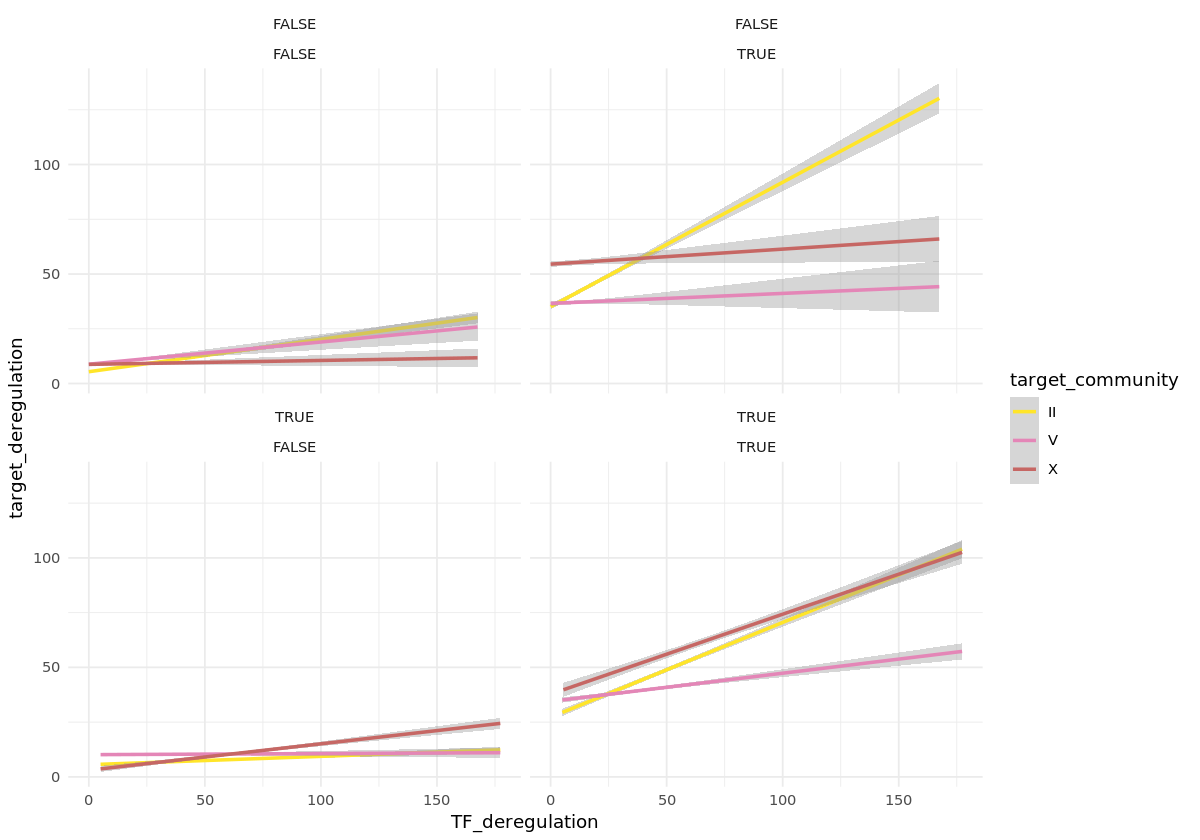

In [106]:
options(repr.plot.width=10, repr.plot.height=7)
ggplot(A, aes(x=TF_deregulation,y=target_deregulation,colour=target_community)) +
    geom_smooth(method="glm") + facet_wrap(TF_significant~target_significant) + 
    scale_colour_manual(values=col2)

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



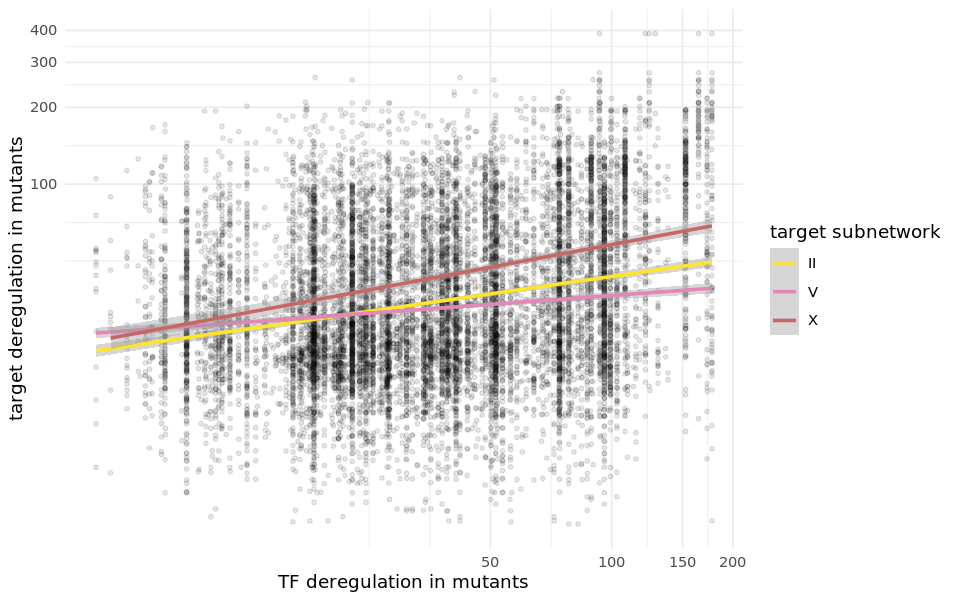

In [107]:
options(repr.plot.width=8, repr.plot.height=5)
g=A %>% filter(TF_significant==TRUE & target_significant==TRUE & target_deregulation>0 & TF_deregulation>0) %>%
ggplot(., 
       aes(x=TF_deregulation,y=target_deregulation,colour=target_community)) +
    geom_point(alpha=1/10,size=1,color="black") +
    geom_smooth(method="glm") + 
    scale_colour_manual(values=col2,name="target subnetwork") + 
    scale_x_continuous( trans="pseudo_log") + scale_y_continuous(trans="pseudo_log") +
    xlab("TF deregulation in mutants") +
    ylab("target deregulation in mutants") 
g
ggsave(g,filename="relationship.TF-target.deregulation.II_V_X.pdf",width=8,height=5)

In [108]:
summary(glm(target_deregulation~TF_deregulation+target_community+0,data=A))


Call:
glm(formula = target_deregulation ~ TF_deregulation + target_community + 
    0, data = A)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-48.28  -20.03  -11.41    8.06  362.86  

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
TF_deregulation     0.158298   0.003793   41.74   <2e-16 ***
target_communityII 15.600635   0.228904   68.15   <2e-16 ***
target_communityV  20.213020   0.269568   74.98   <2e-16 ***
target_communityX  20.032711   0.256848   77.99   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 1078.433)

    Null deviance: 104248998  on 64408  degrees of freedom
Residual deviance:  69455400  on 64404  degrees of freedom
AIC: 632566

Number of Fisher Scoring iterations: 2


In [109]:
cor.test(A$target_deregulation,A$TF_deregulation,method="kendall")


	Kendall's rank correlation tau

data:  A$target_deregulation and A$TF_deregulation
z = 27.103, p-value < 2.2e-16
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
0.07629547 


In [110]:
cor.test(A$target_deregulation,A$TF_deregulation,method="pearson")


	Pearson's product-moment correlation

data:  A$target_deregulation and A$TF_deregulation
t = 40.086, df = 64406, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1484749 0.1635447
sample estimates:
      cor 
0.1560189 
